# Quick synthetic to verify that the code works as intended

In [15]:

import pygmt
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import bordado as bd
import boule as bl
import harmonica as hm
import verde as vd
import pandas as pd
import time
from sklearn.metrics import mean_squared_error
%load_ext line_profiler

import spherical as sph

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Forward modeling

Test the forward modeling functions and see if they make sense.

In [2]:
region = (-60, -30, -40, -10)
grid_coordinates = bd.grid_coordinates(region, spacing=10 / 60, non_dimensional_coords=200)
dipole = (-45, -20, -250e3)
# Regional field
inclination, declination = -30, 0
dipole_moment = hm.magnetic_angles_to_vec(1e17, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

Make a map with PyGMT so we can visually inspect the anomaly. It should have a positive part to the North and negative to the South.

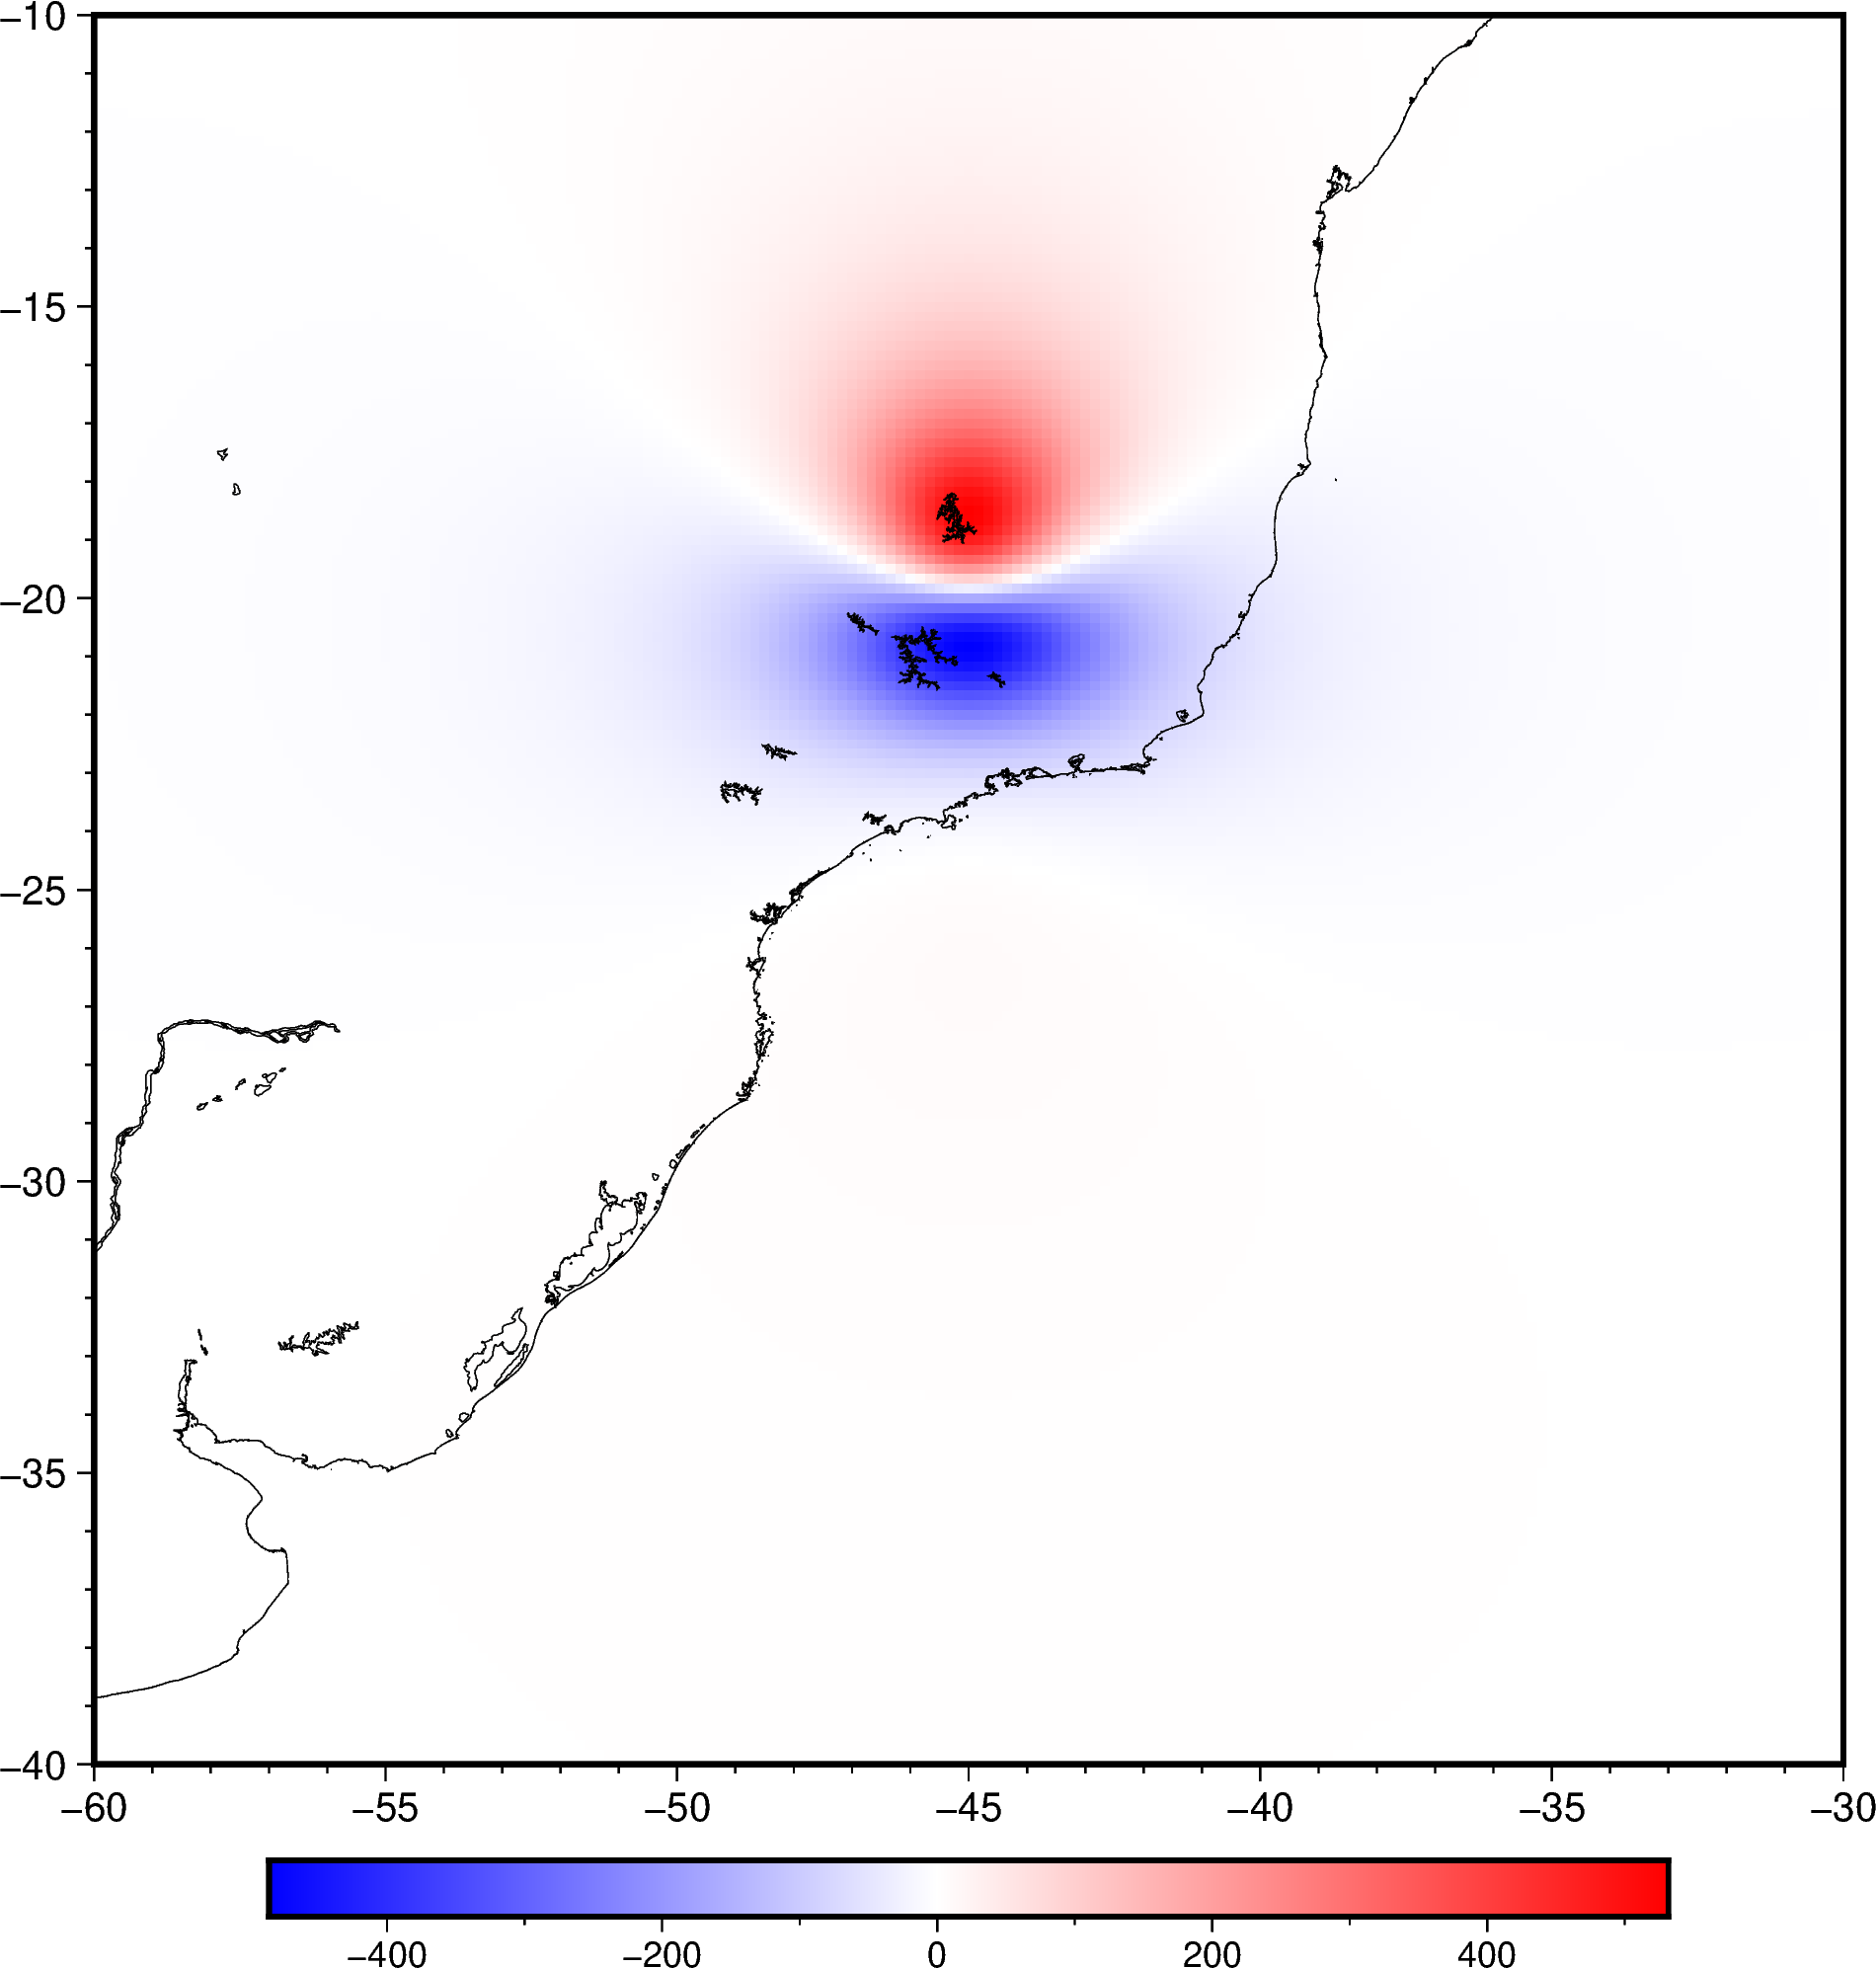

In [3]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Simple equivalent source inversion

Try recovering the dipole field with a simple single layer inversion.

In [4]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.02 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

10.609597962563587 nT


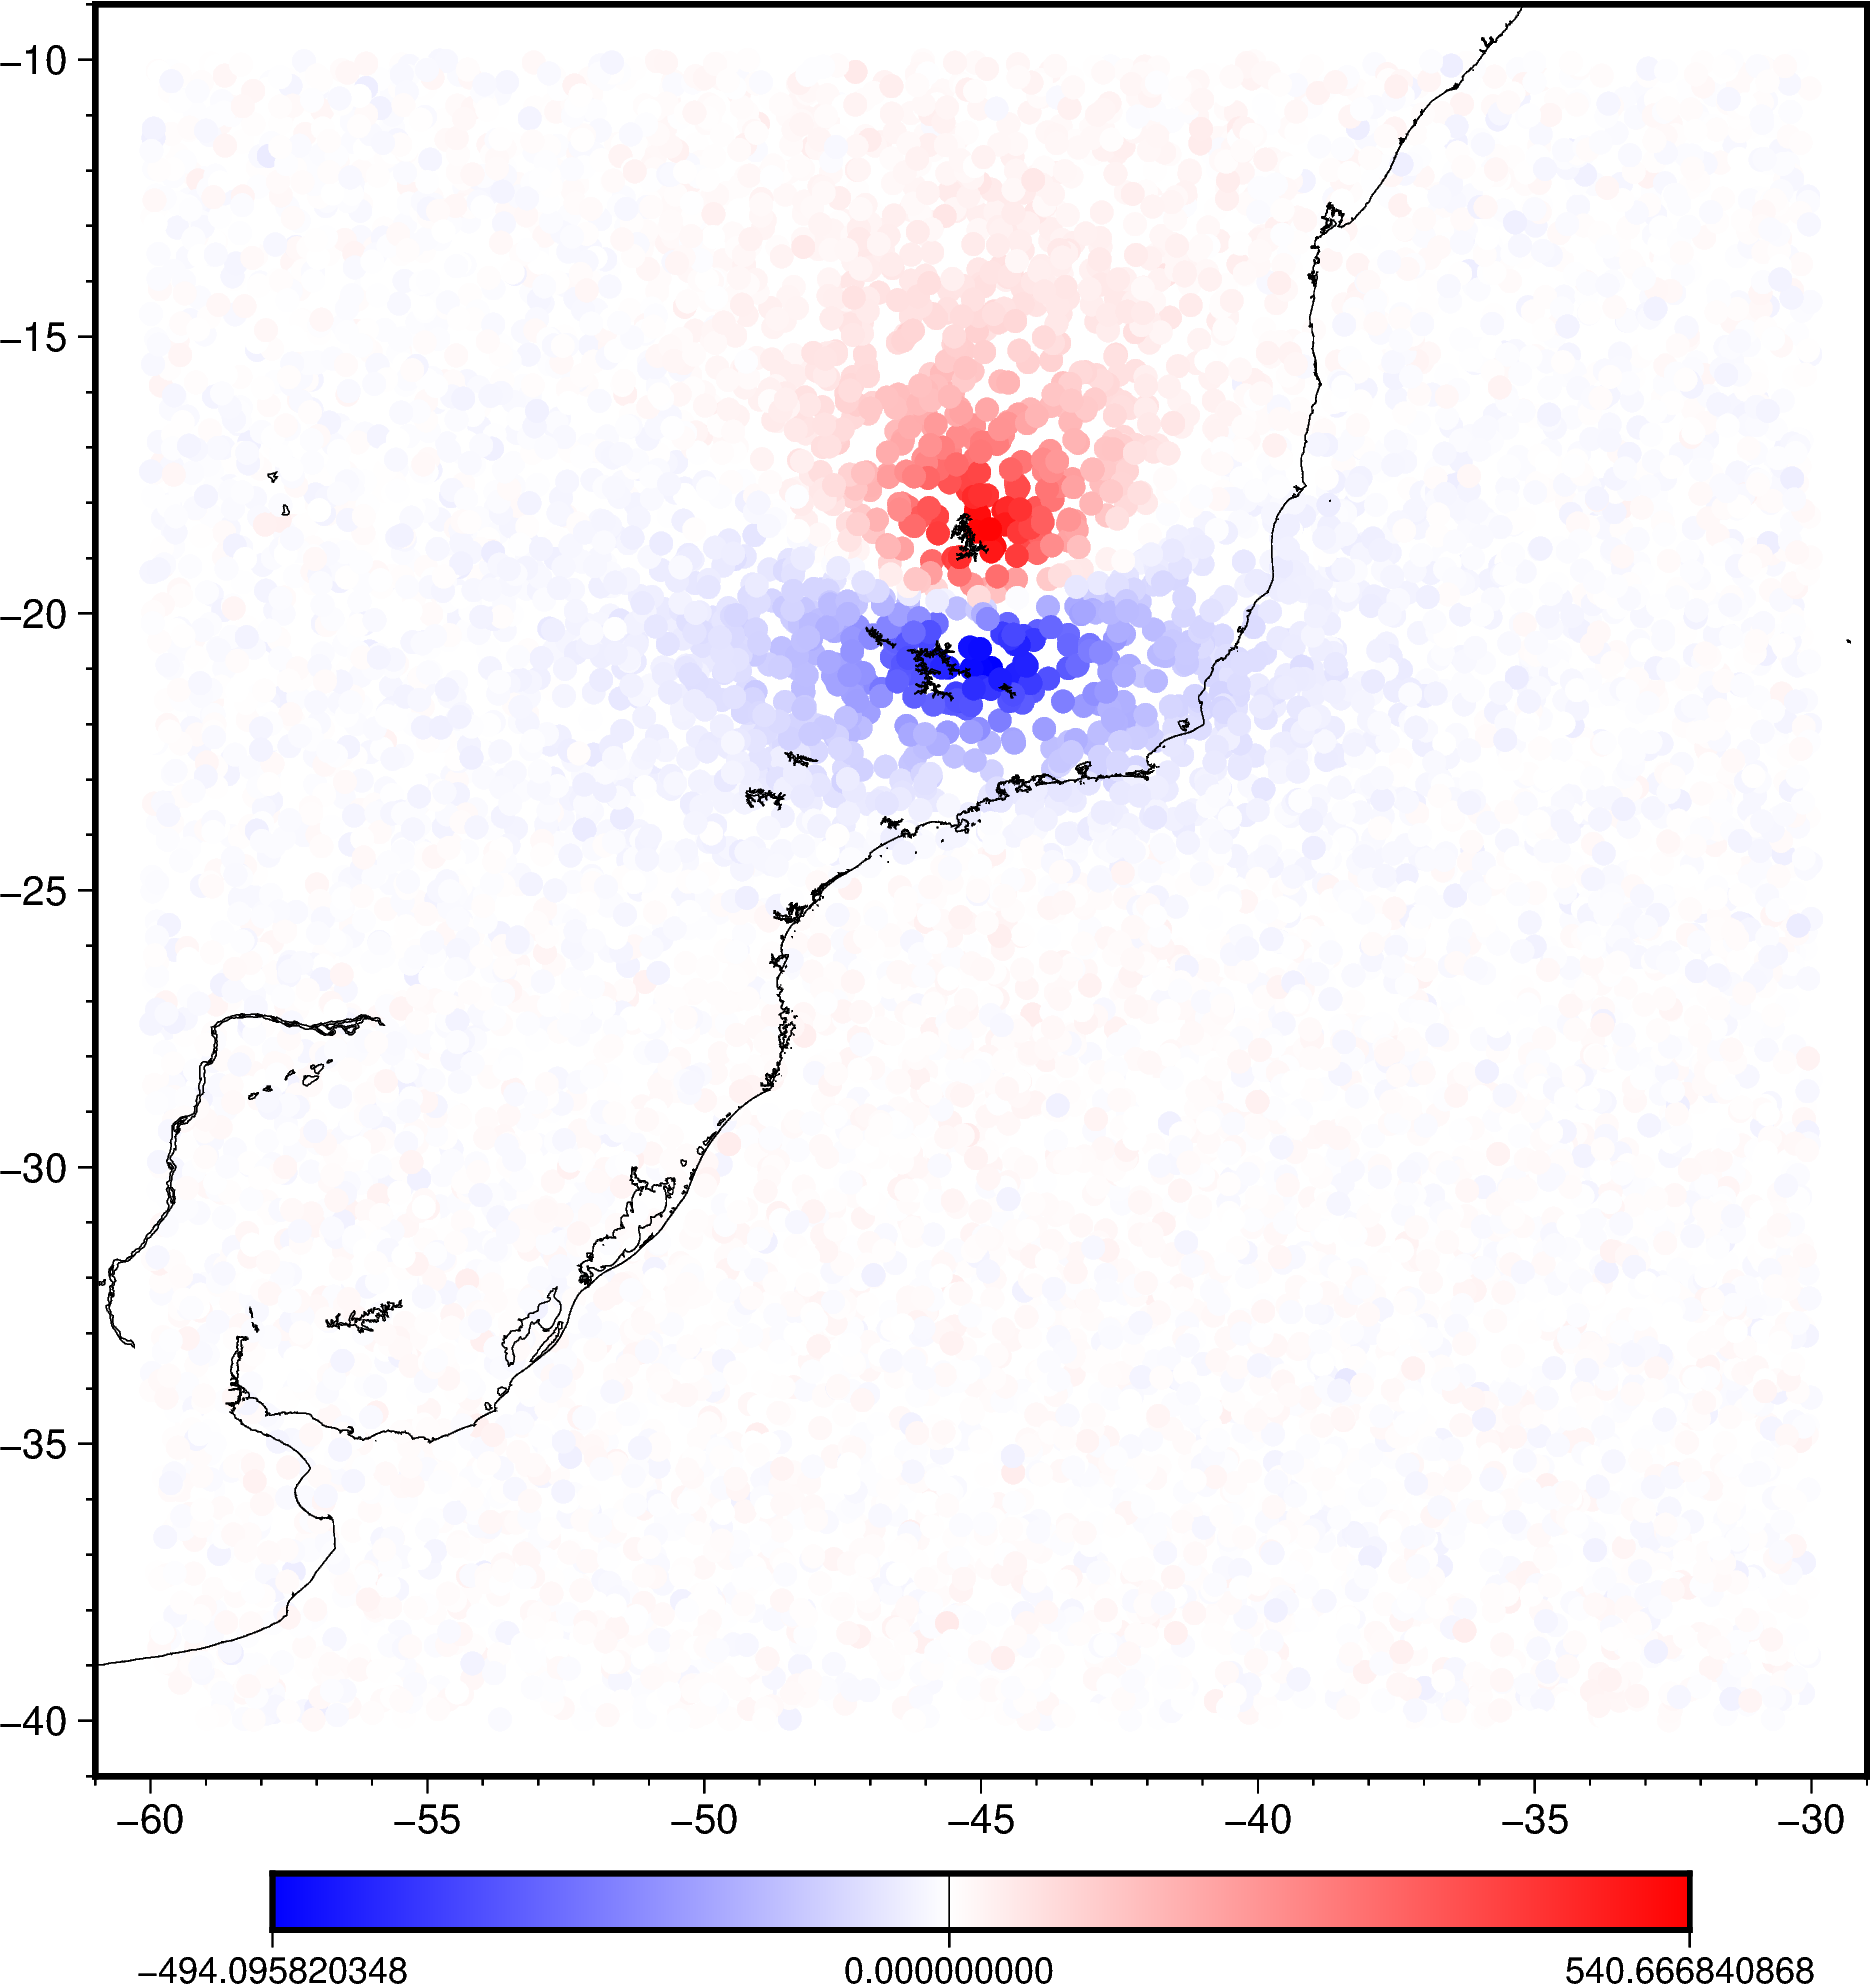

In [5]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.2c", cmap=True, frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Run the inversion.

In [6]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_64.fit(coordinates, inclination, declination, data)


CPU times: user 2min 35s, sys: 13.7 s, total: 2min 49s
Wall time: 21.5 s


Timer unit: 1e-09 s

Total time: 21.2892 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1       1150.0   1150.0      0.0          if dtype is not None:
   430                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431                                                

Run the inversion - 32 bits

In [7]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

CPU times: user 1min 22s, sys: 4.46 s, total: 1min 26s
Wall time: 11.6 s


Timer unit: 1e-09 s

Total time: 11.604 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1       2753.0   2753.0      0.0          if dtype is not None:
   430         1    5816855.0 5.82e+06      0.1              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431         1    2073546.0 2.07e+06      0.0        

In [ ]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 9


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados



--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits    8.0  10.800732  2.472122   8.335812   9.032155  10.103181   
64 bits    8.0  18.458432  2.891417  16.010532  16.865147  17.243156   

               75%        max  
Versão                         
32 bits  12.026546  14.806828  
64 bits  18.830058  23.438898  


Versão  Rodada    Duração
0   64 bits       2  17.541316
1   64 bits       3  17.217365
2   64 bits       4  16.983237
3   64 bits       5  23.438898
4   64 bits       6  16.510875
5   64 bits       7  17.268947
6   64 bits       8  22.696284
7   64 bits       9  16.010532
8   32 bits       1  11.376912
9   32 bits       3   9.212061
10  32 bits       4   9.260856
11  32 bits       5  13.975448
12  32 bits       6   8.335812
13  32 bits       7   8.492436
14  32 bits       8  10.945506
15  32 bits       9  14.806828

Plotting the statistics


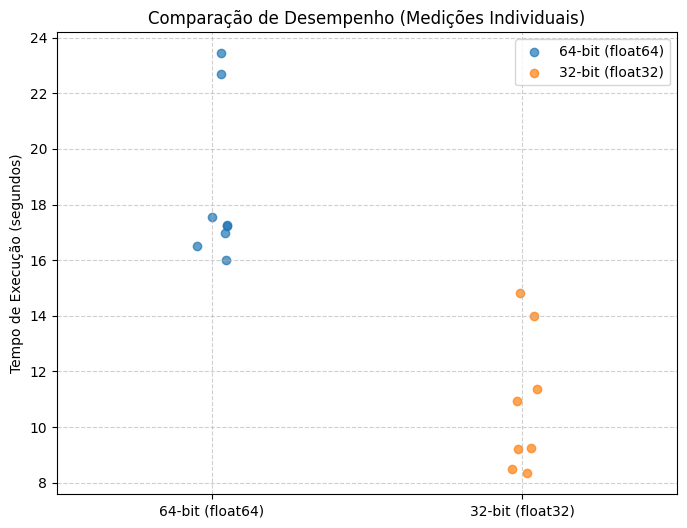

/tmp/ipykernel_13235/346234464.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


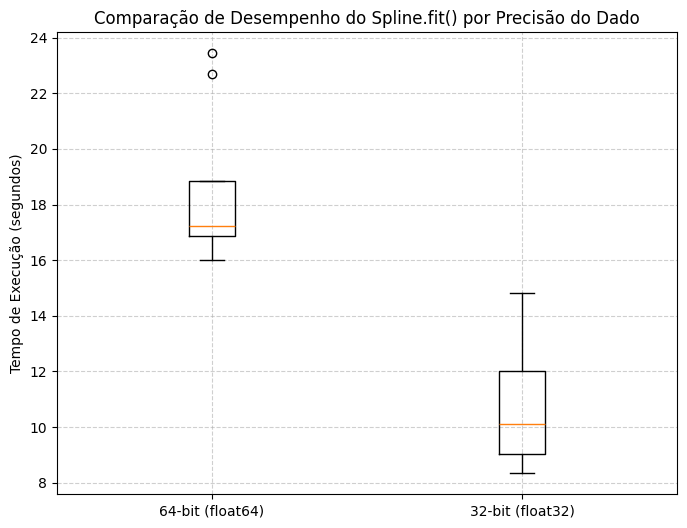

In [ ]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_1.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_1.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


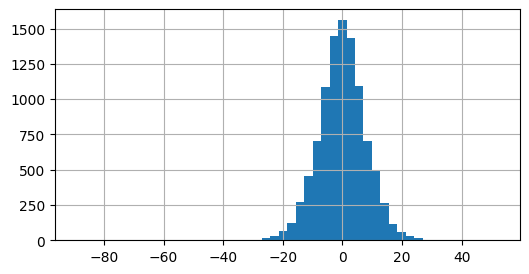

32 bits


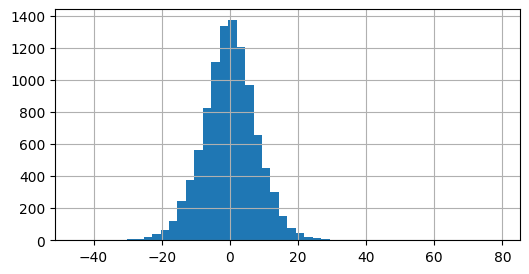

In [27]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

In [28]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

64 bits


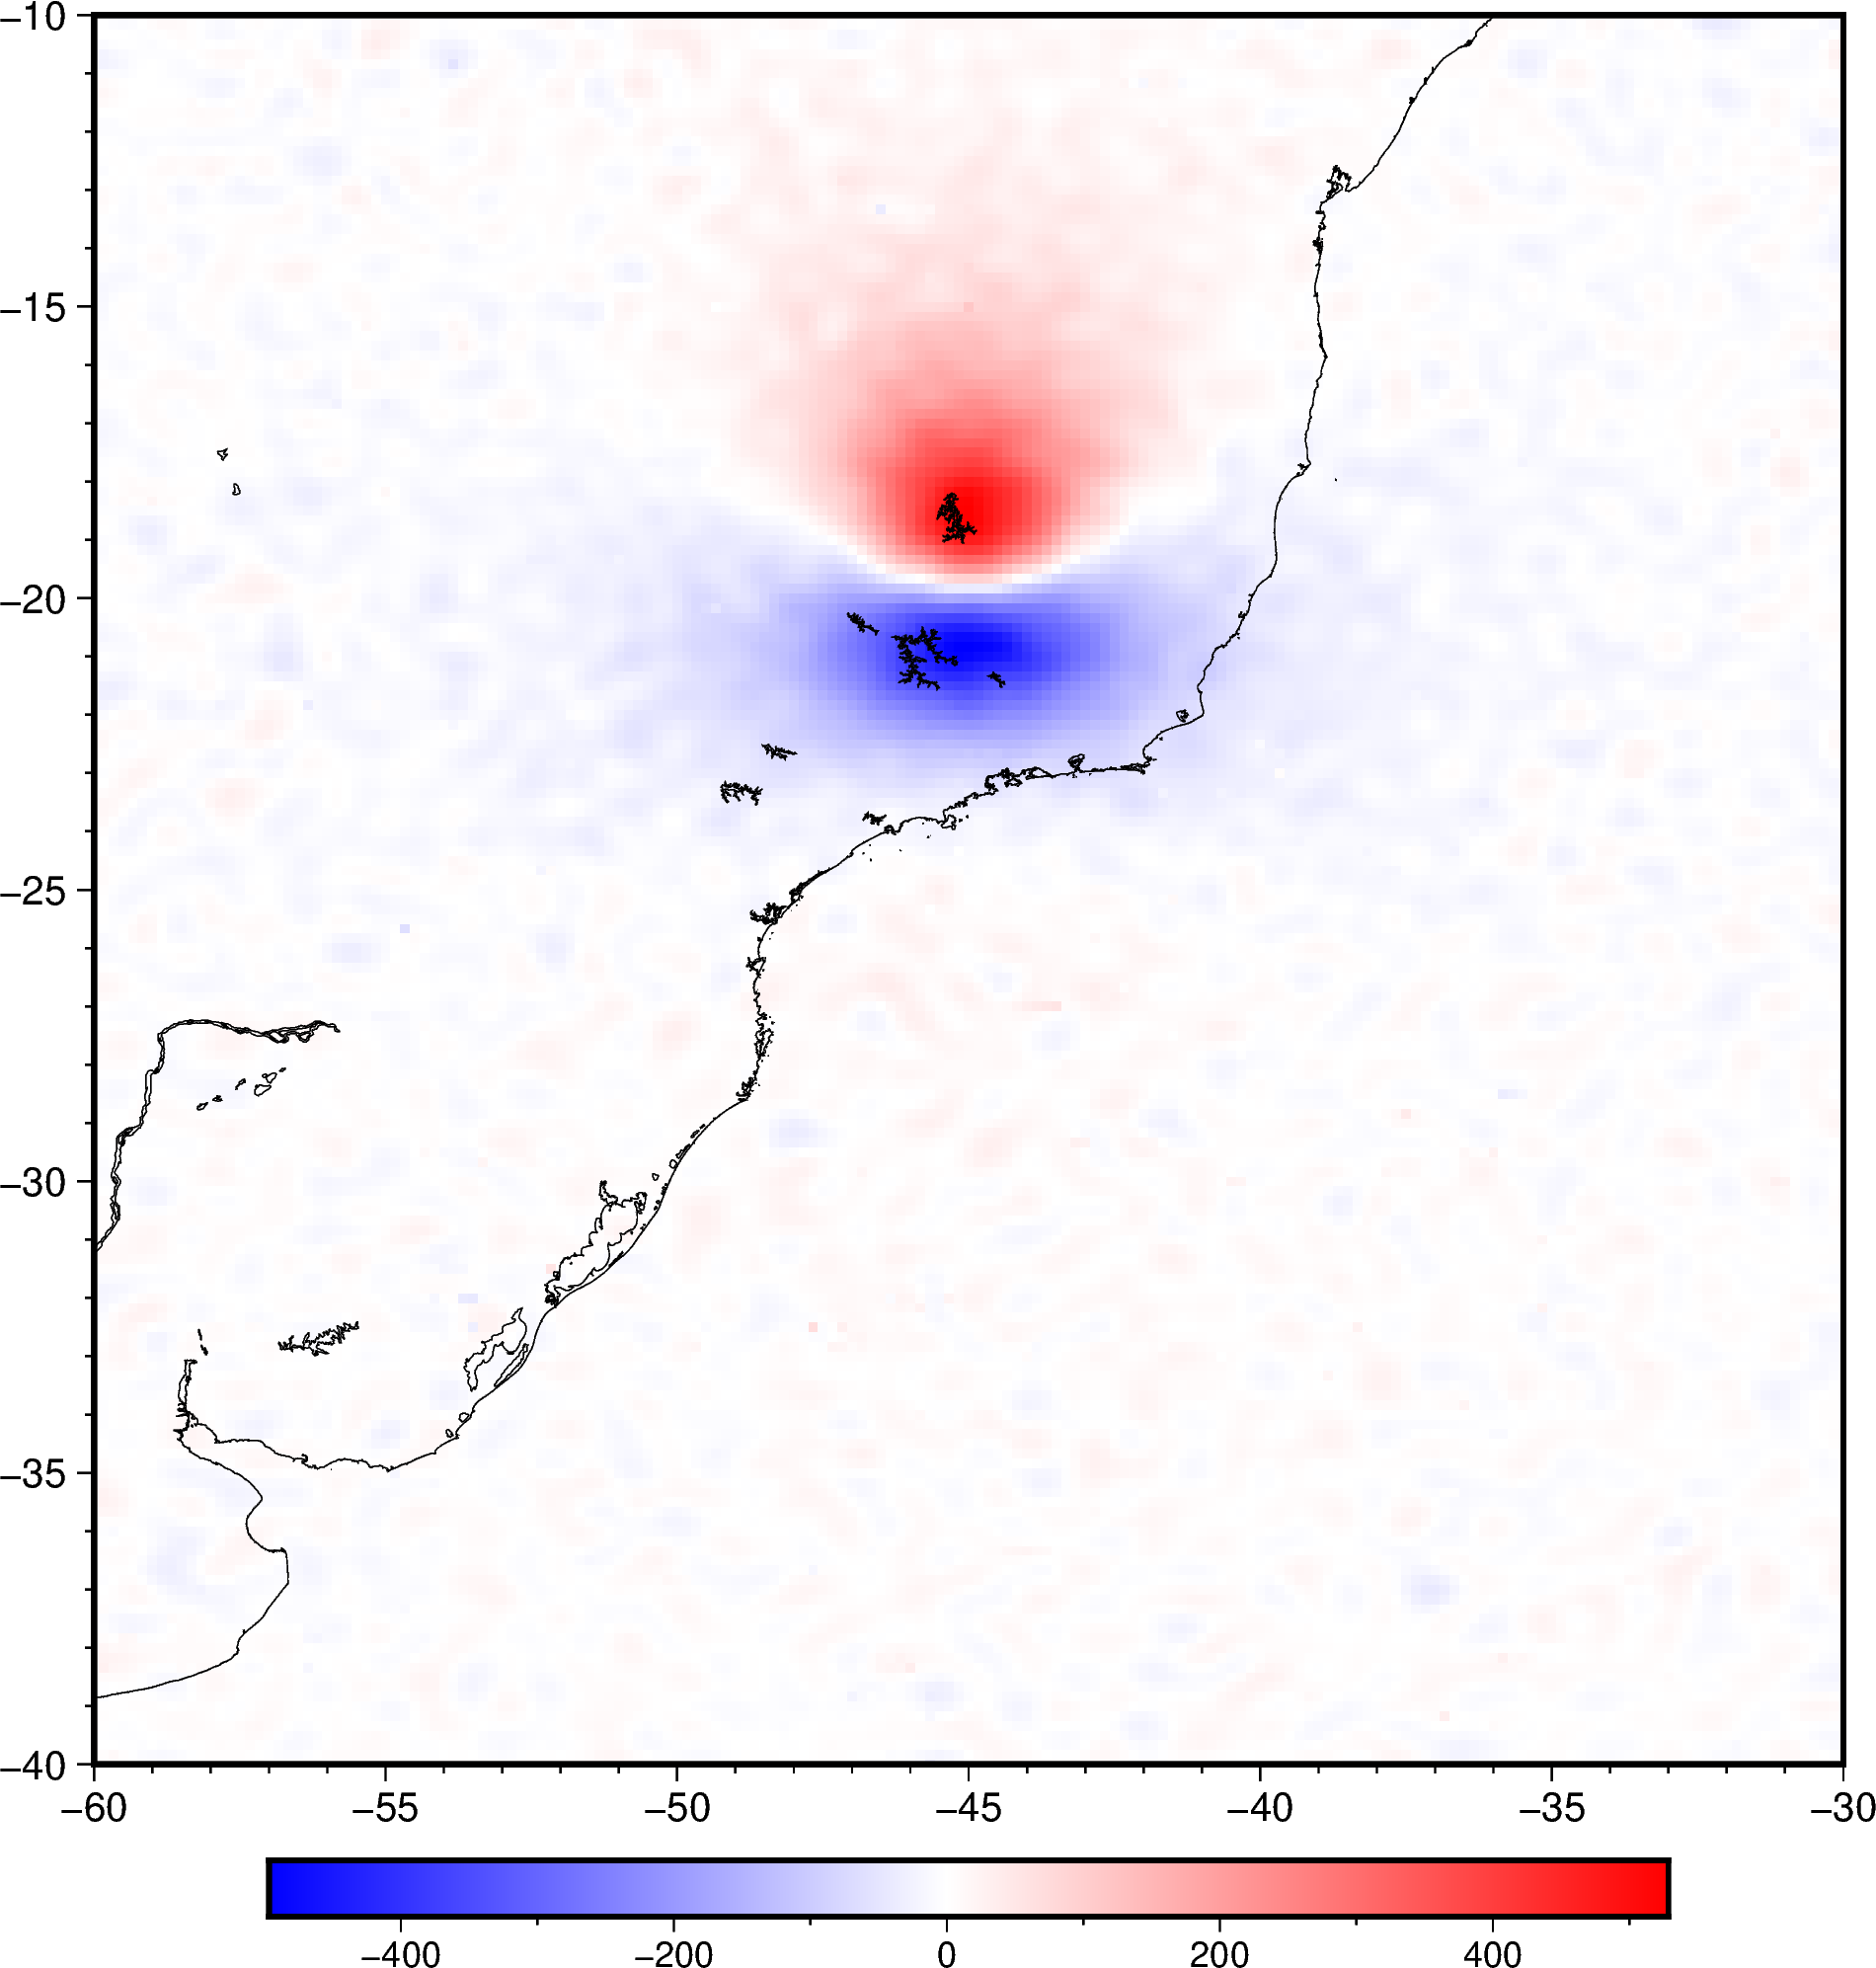

32 bits


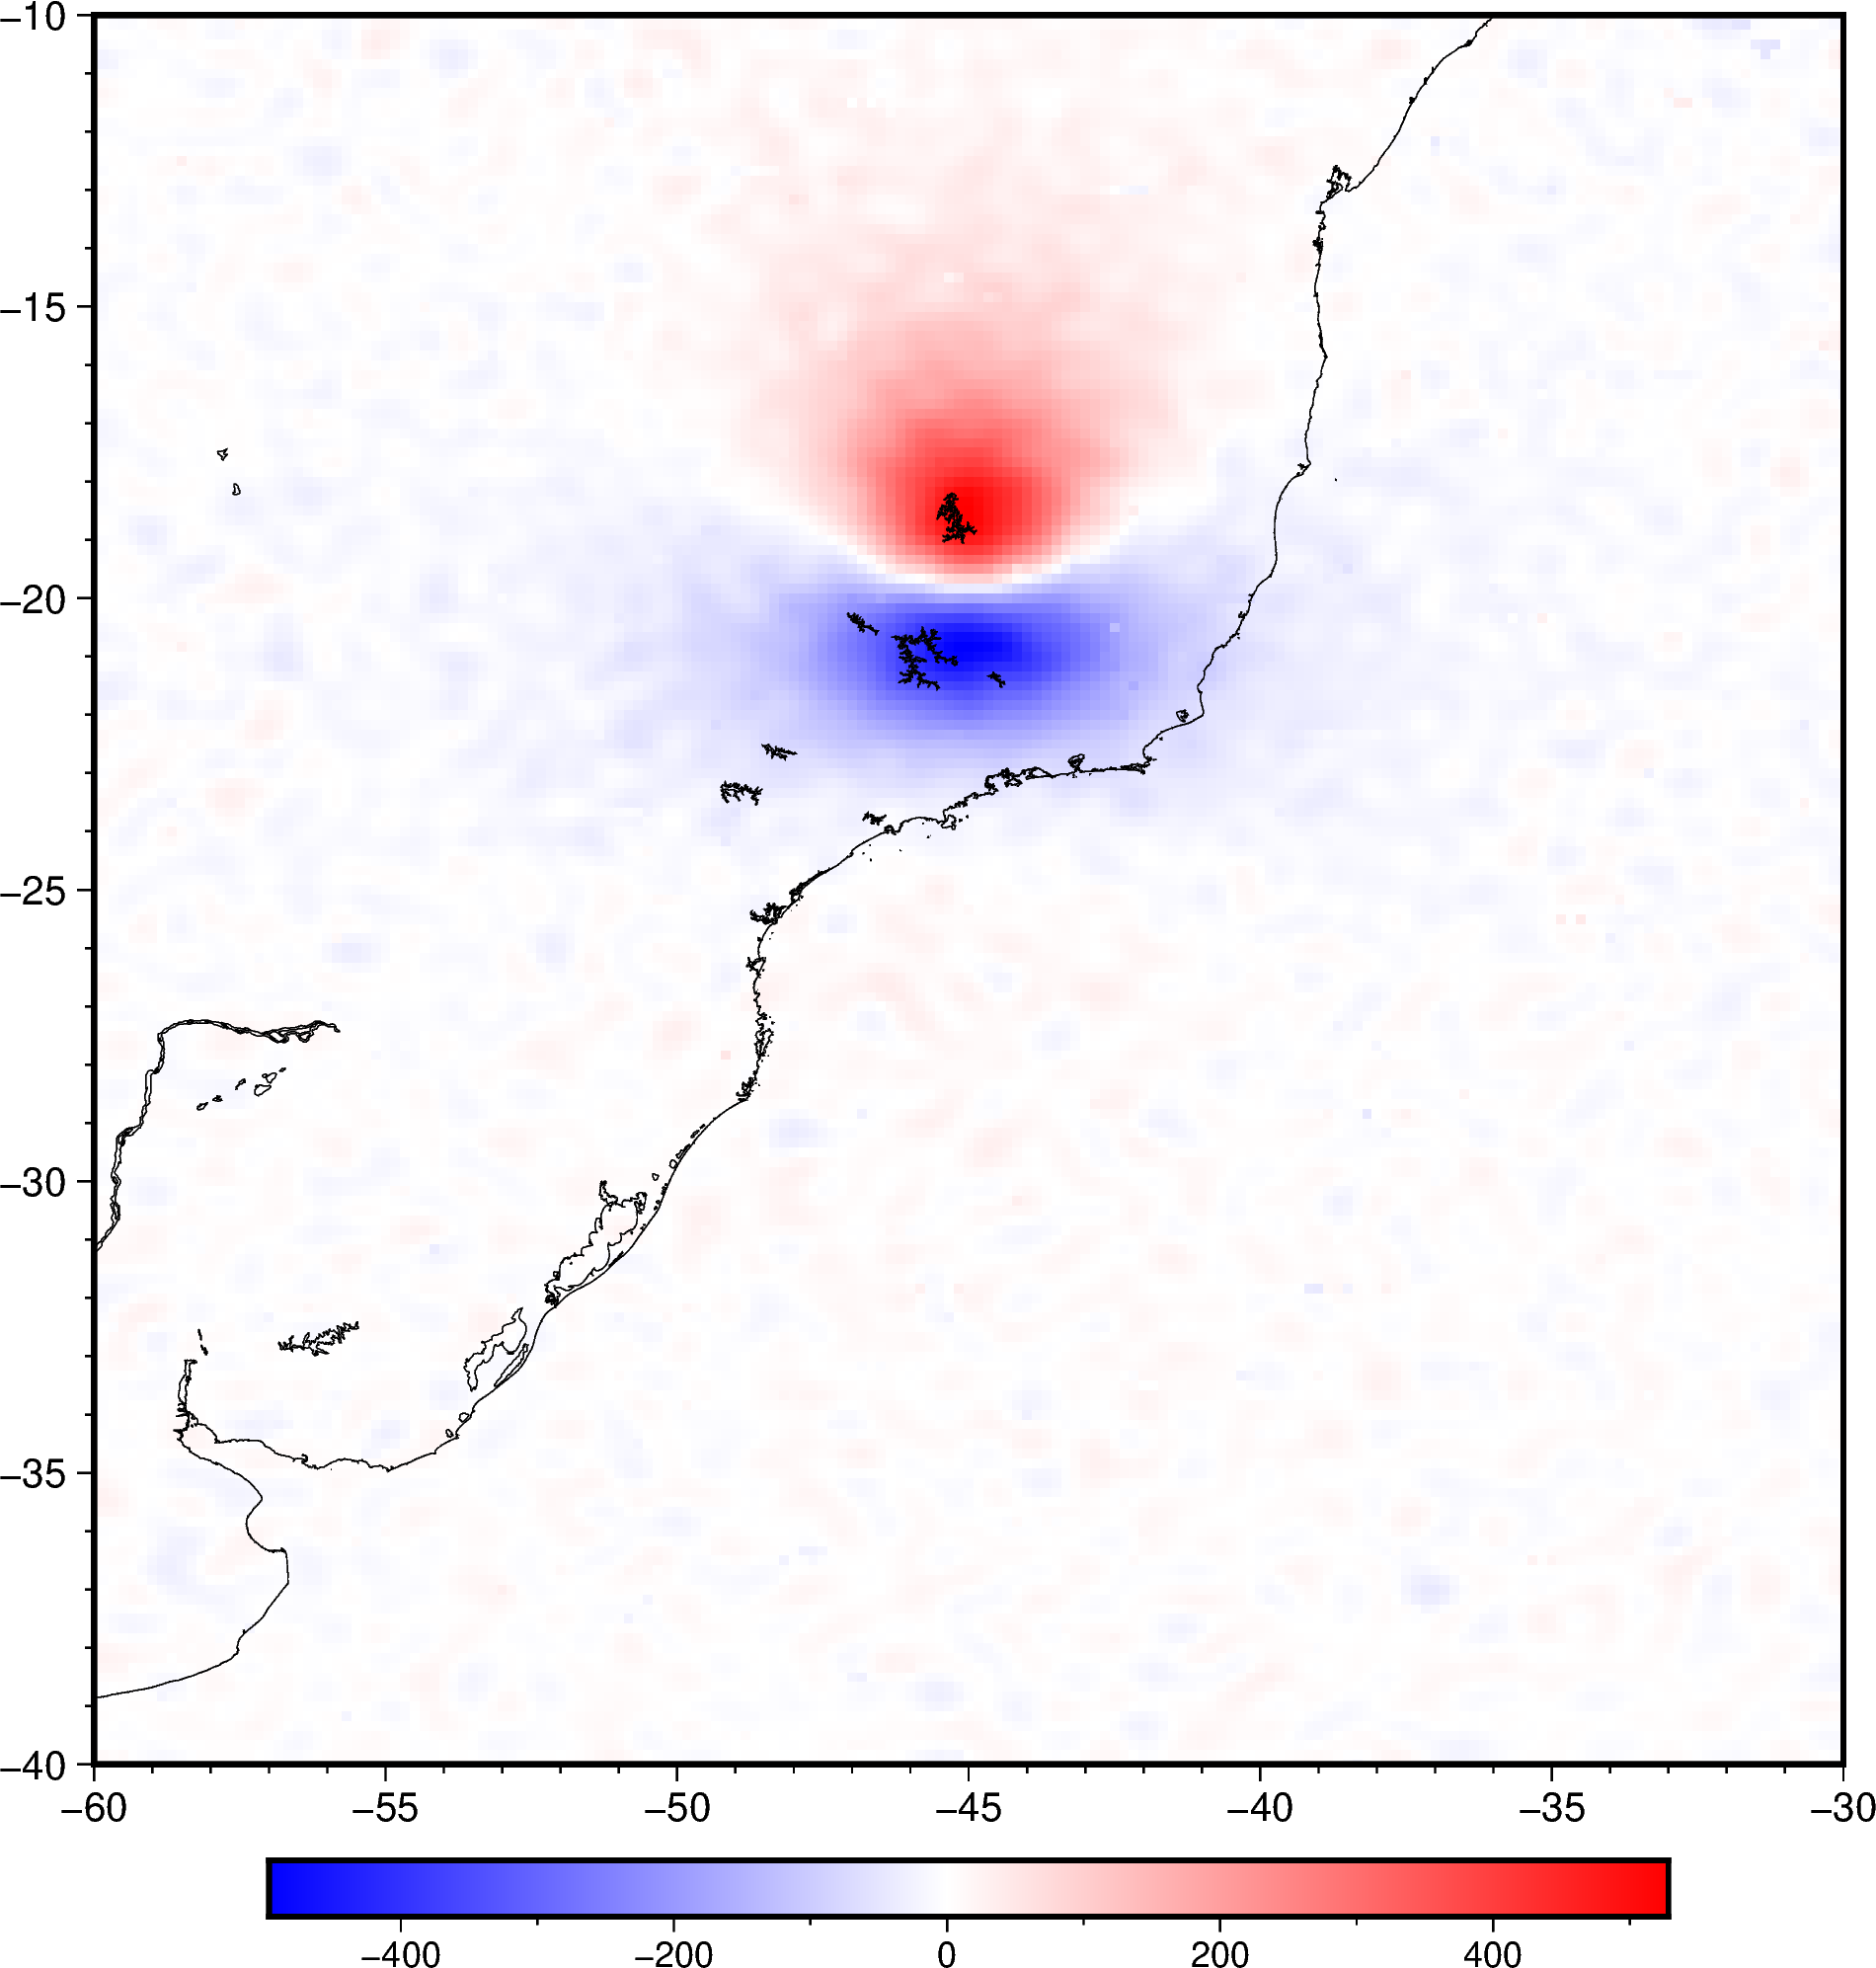

In [29]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [30]:
# --- 1. Extração dos Dados Numéricos ---

# A função de cálculo do erro funciona com os arrays NumPy que estão
# dentro dos seus grids xarray. Acessamos eles com o atributo '.values'.
valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

# O primeiro argumento é o nosso "gabarito" (maior precisão)
# O segundo é a versão que queremos comparar
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 5.374801839069721
A Raiz do Erro Quadrático Médio (RMSE) é: 2.3184 nT


Show the difference.

64 bits


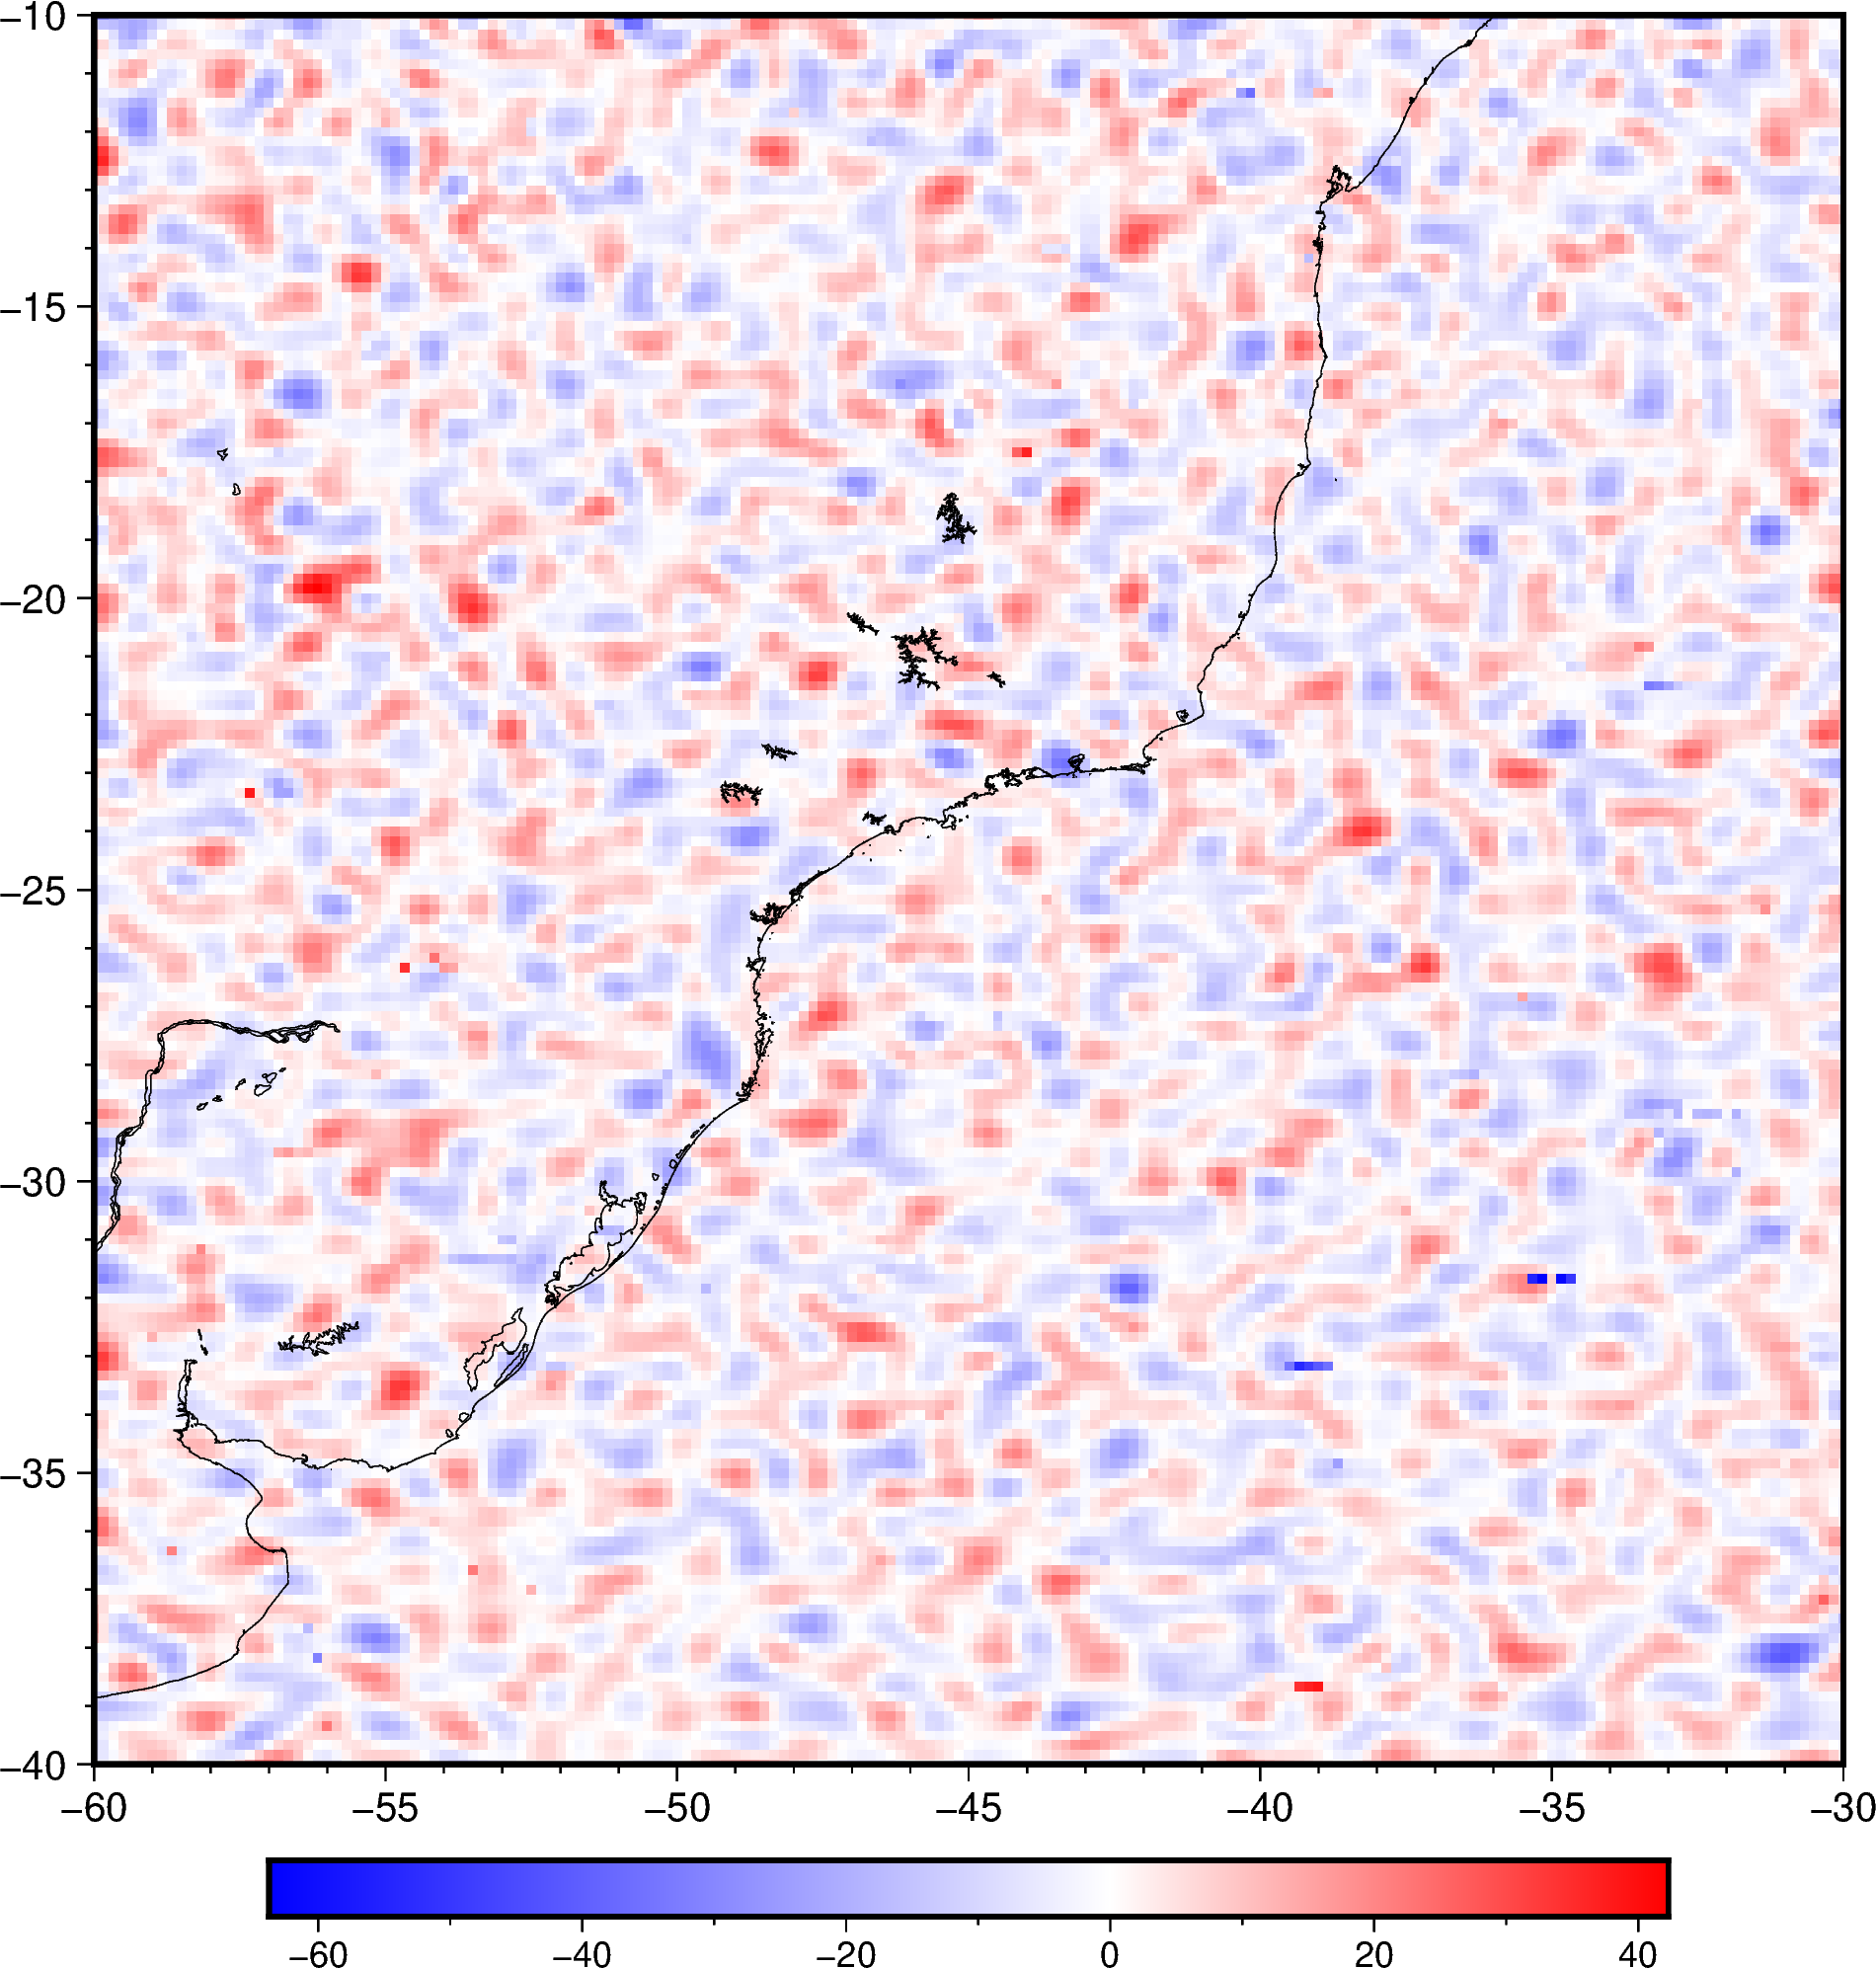

32 bits


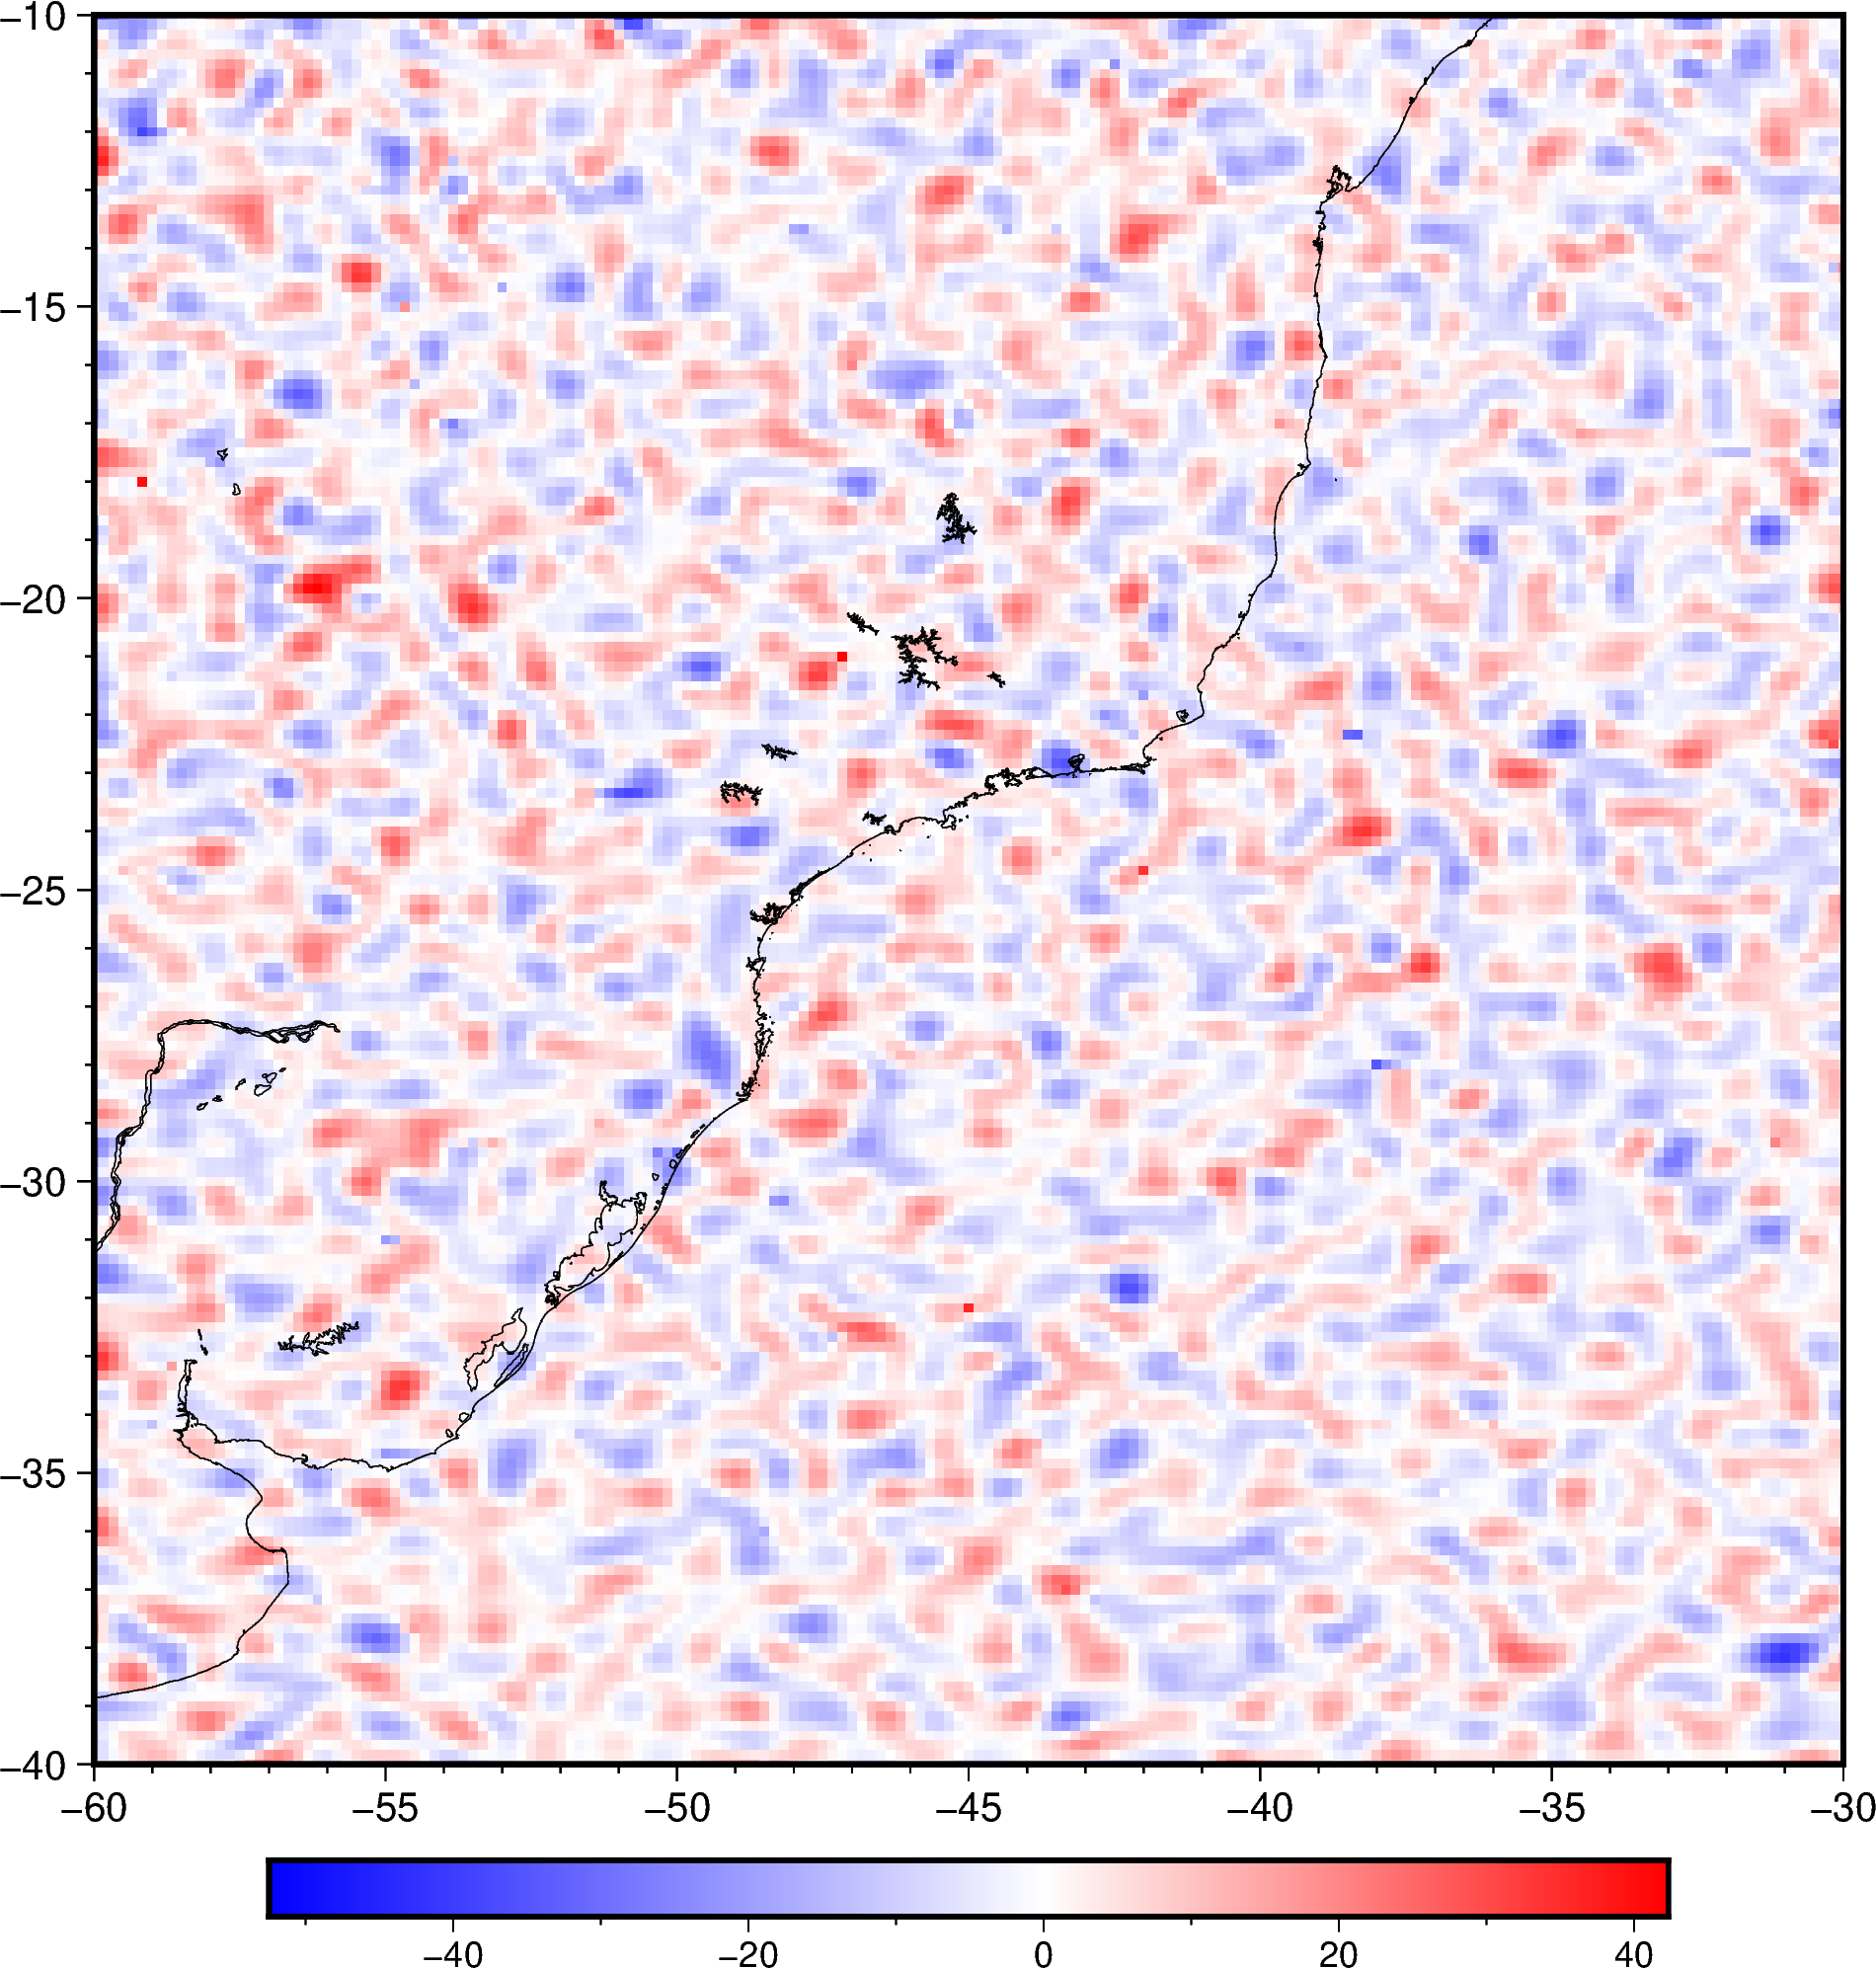

In [14]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Gradient-boosting

In [ ]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f eqs_64.fit(coordinates, inclination, declination, data, dtype="float64")
print(eqs_64.window_size_)

Output()

1000000.0
CPU times: user 1min 43s, sys: 458 ms, total: 1min 43s
Wall time: 10.9 s


In [ ]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")
print(eqs_32.window_size_)

Output()

1000000.0
CPU times: user 1min 22s, sys: 146 ms, total: 1min 22s
Wall time: 8.91 s


In [ ]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 9


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()


--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits    8.0  10.069720  1.495951   8.719107   8.905693   9.380065   
64 bits    8.0  15.194137  1.652570  13.734303  13.919136  14.721039   

               75%        max  
Versão                         
32 bits  11.365751  12.582344  
64 bits  15.786225  18.058655  


Versão  Rodada    Duração
0   64 bits       2  13.805495
1   64 bits       3  15.265269
2   64 bits       4  13.957017
3   64 bits       5  13.734303
4   64 bits       6  17.260877
5   64 bits       7  14.176808
6   64 bits       8  15.294675
7   64 bits       9  18.058655
8   32 bits       1   9.109917
9   32 bits       3   9.650212
10  32 bits       4  12.582344
11  32 bits       5   8.719107
12  32 bits       6   8.766822
13  32 bits       7  11.434566
14  32 bits       8  11.342813
15  32 bits       9   8.951984

Plotting the statistics


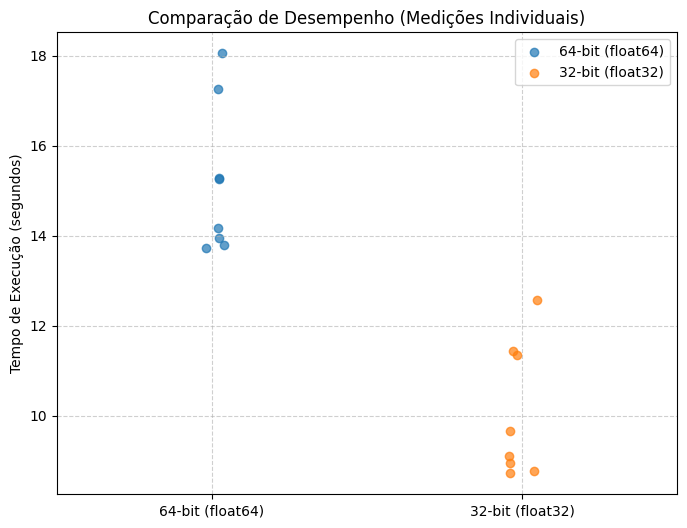

/tmp/ipykernel_13235/2216002869.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


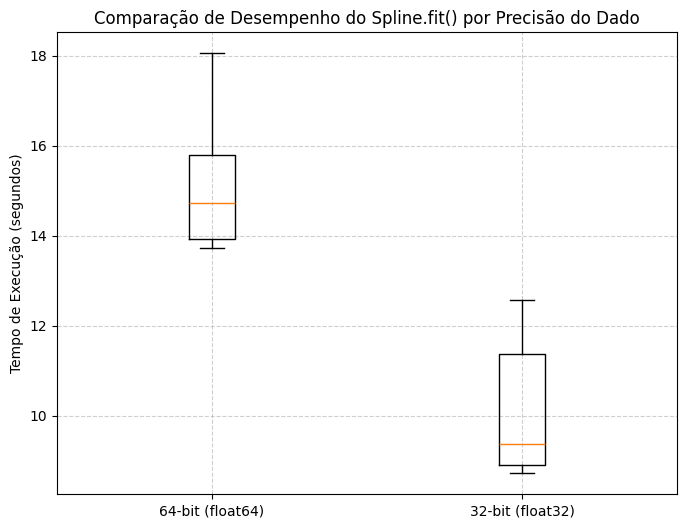

In [ ]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_2.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_2.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


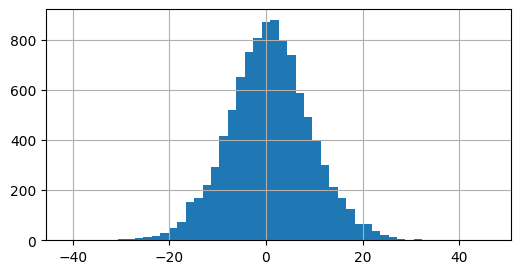

32 bits


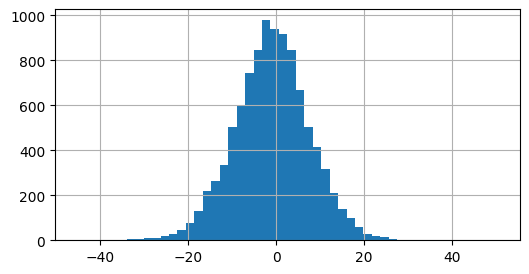

In [17]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()


print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [ ]:

total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid


total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

64 bits
32 bits


64 bits


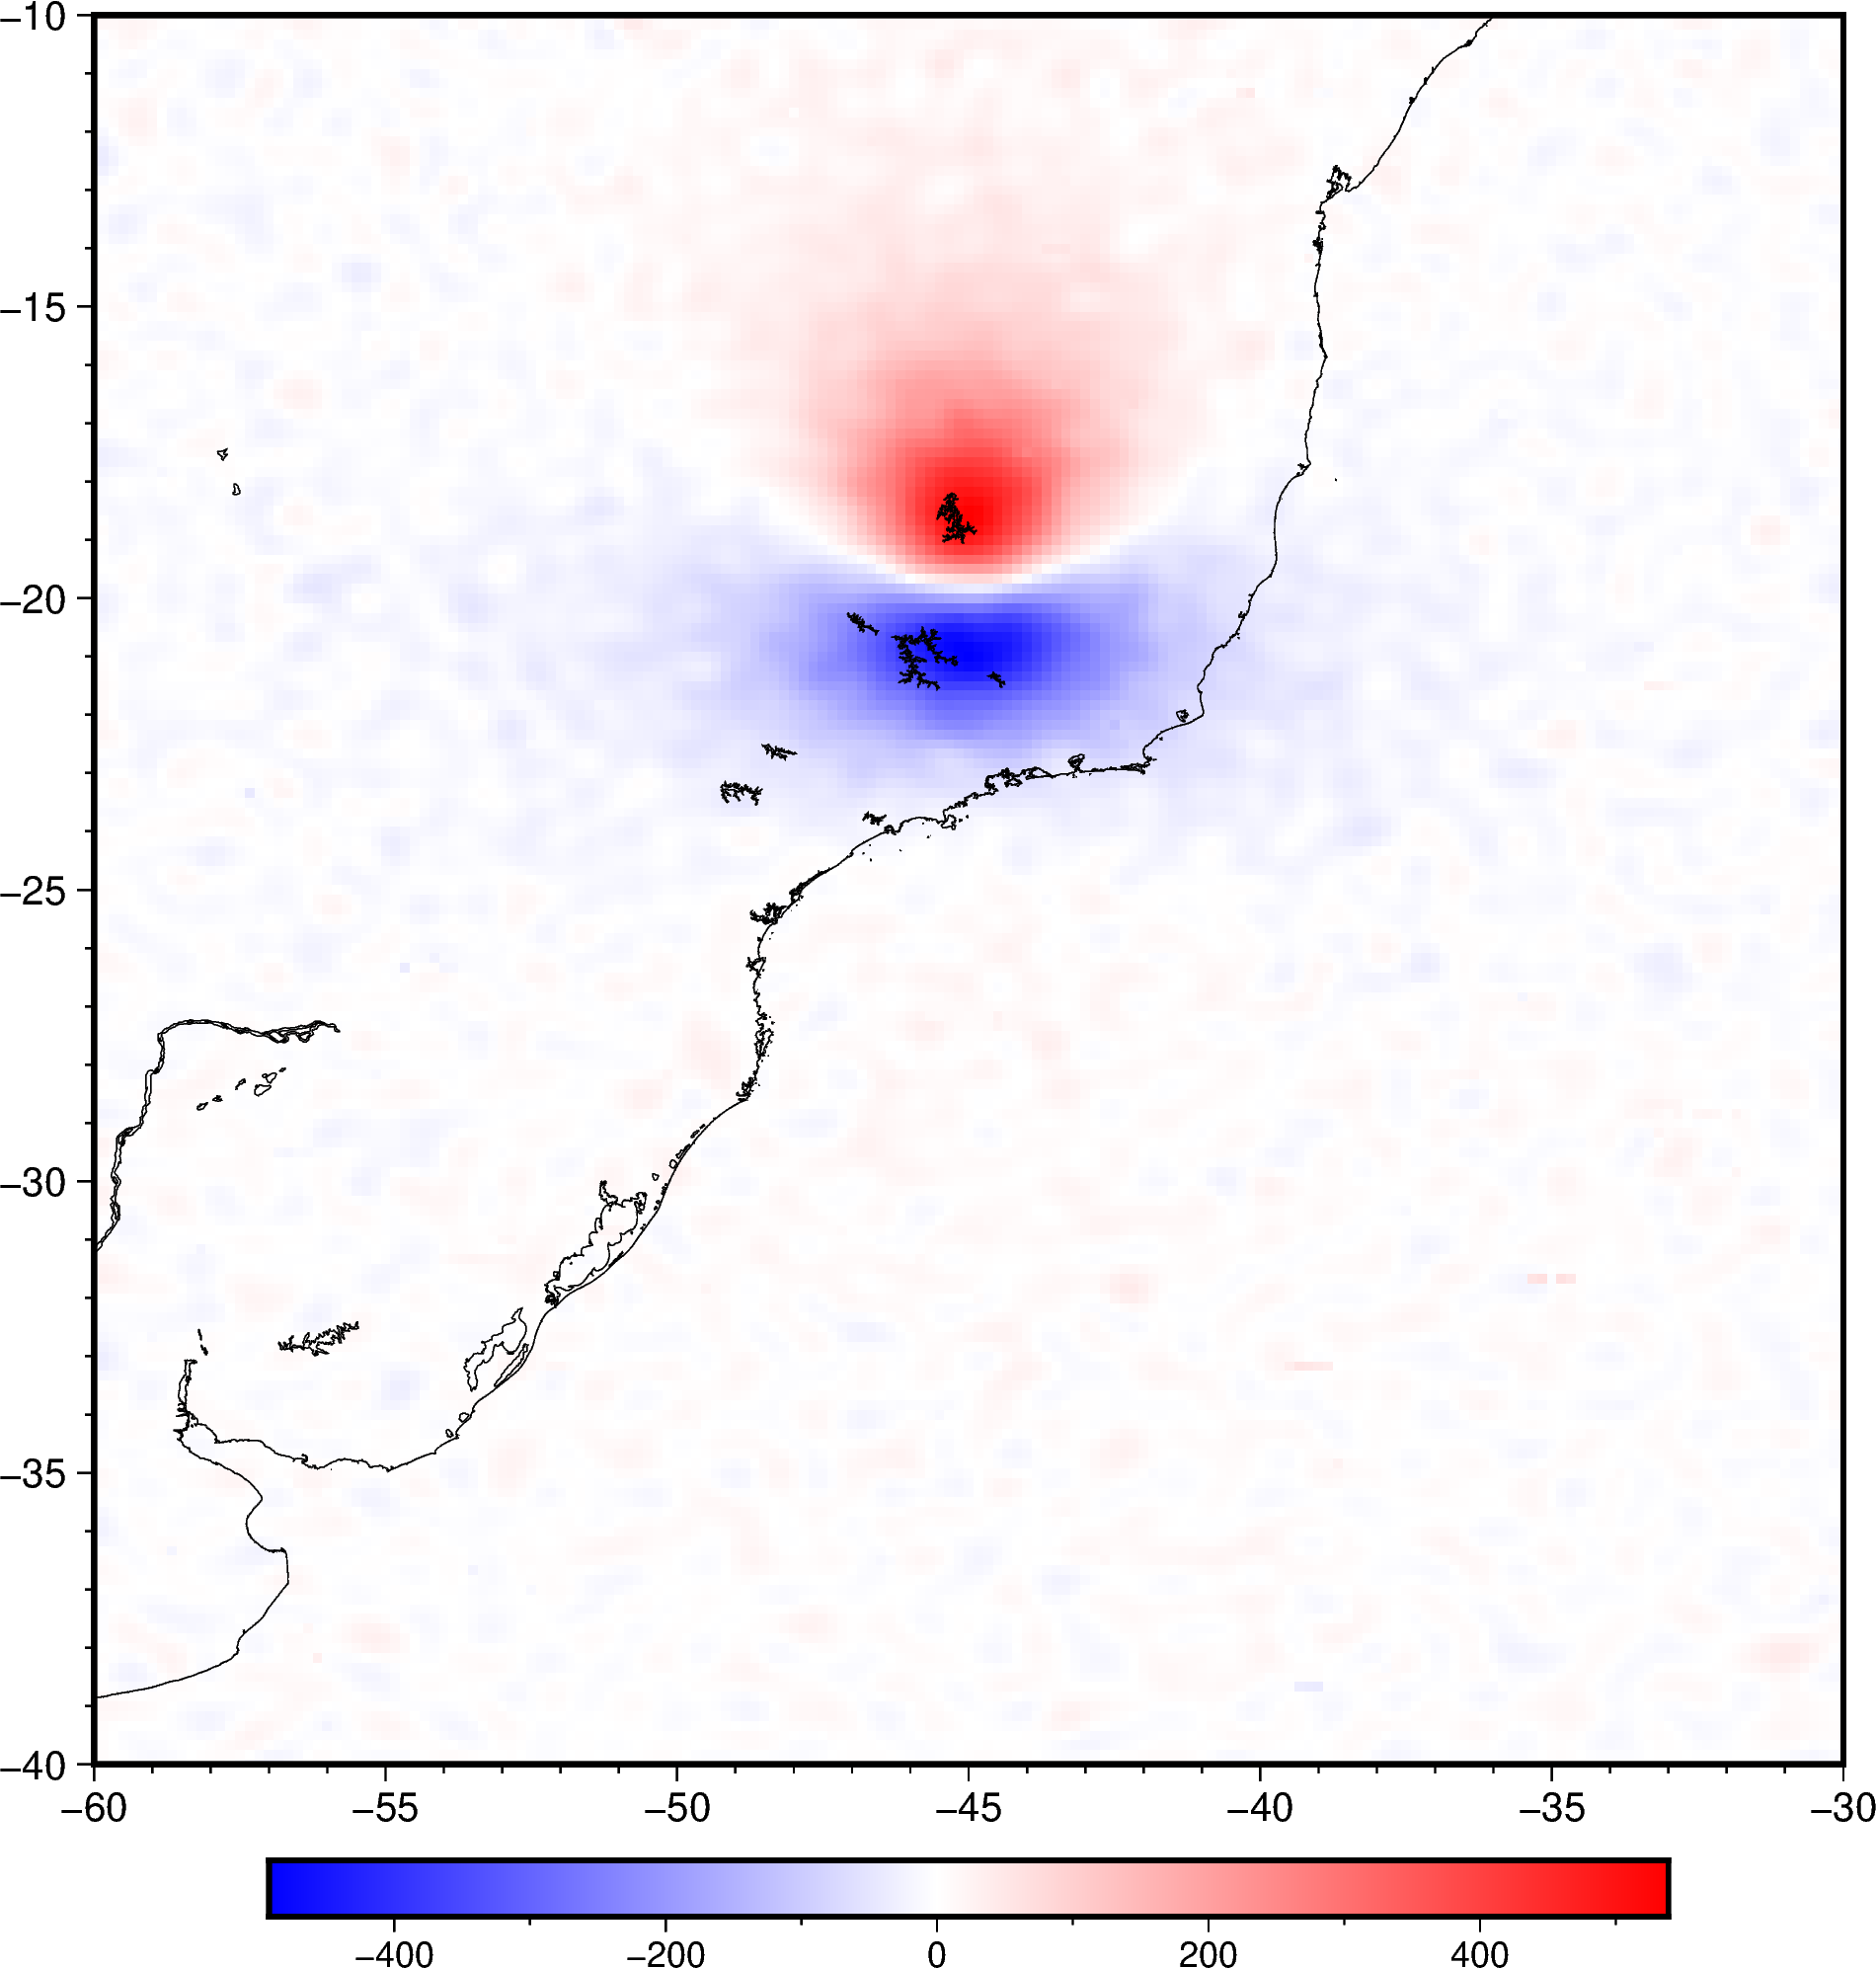

32 bits


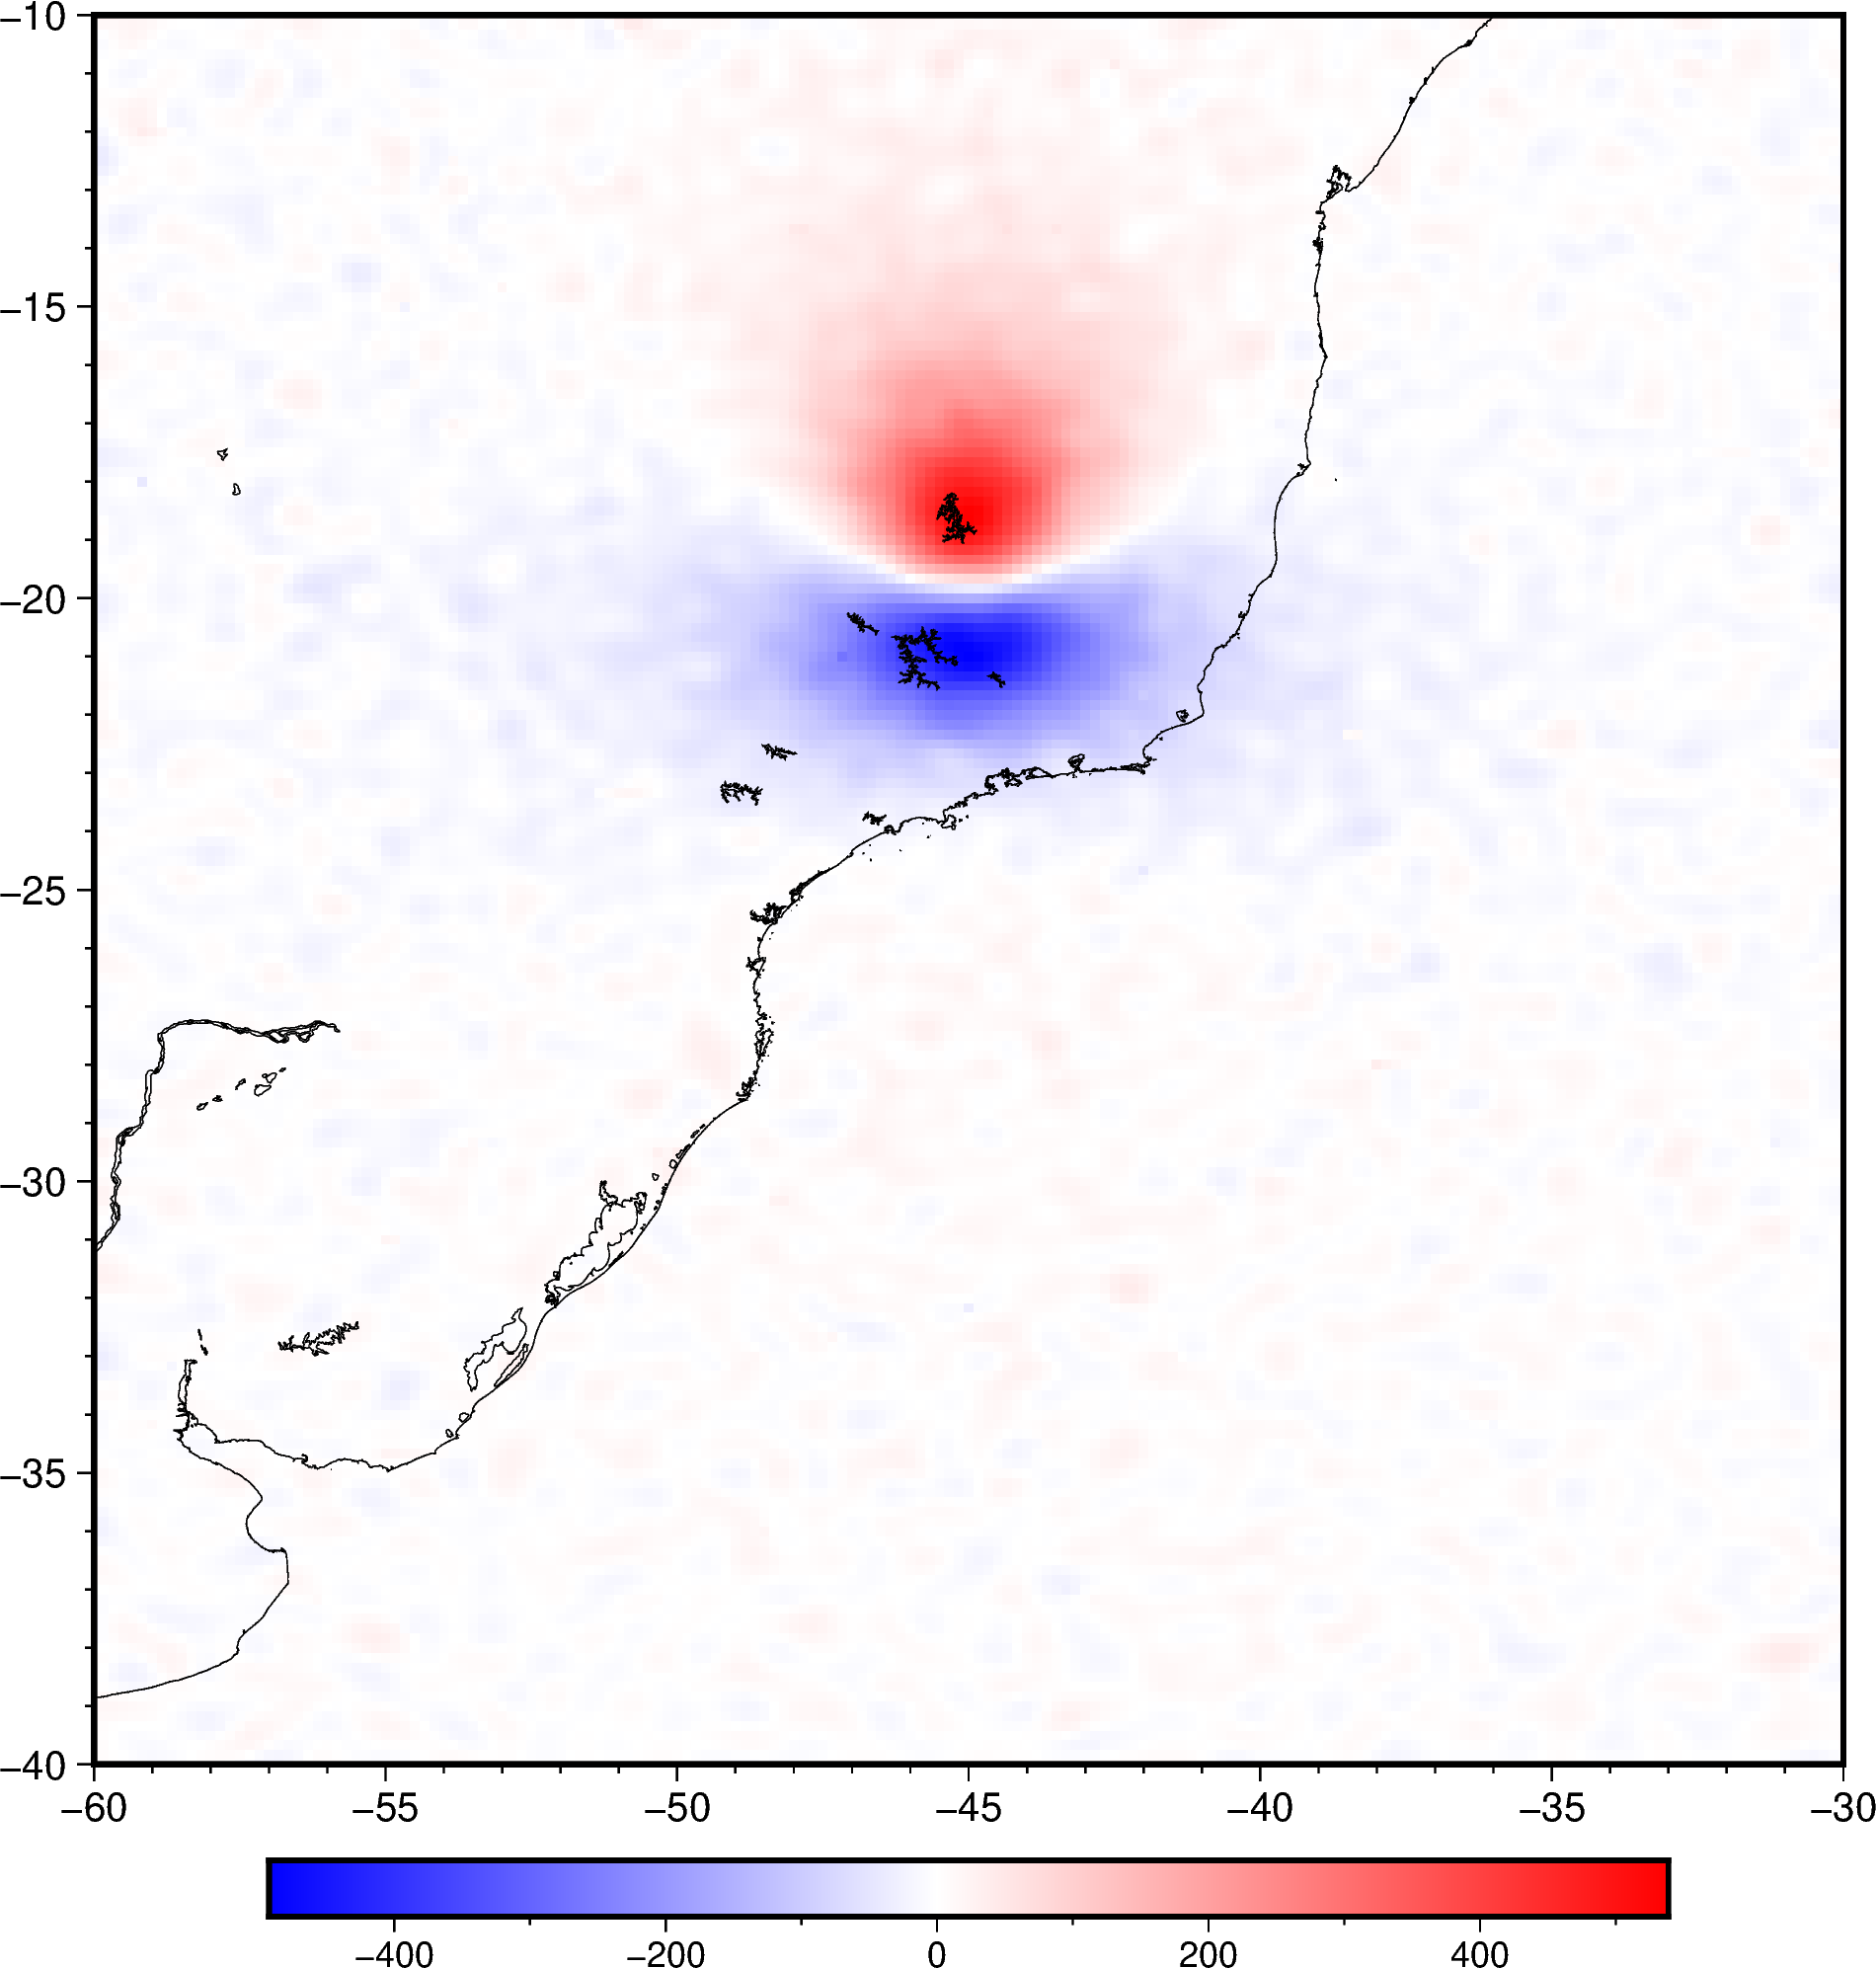

In [19]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [ ]:
# --- 1. Extração dos Dados Numéricos ---

# A função de cálculo do erro funciona com os arrays NumPy que estão
# dentro dos seus grids xarray. Acessamos eles com o atributo '.values'.
valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

# O primeiro argumento é o nosso "gabarito" (maior precisão)
# O segundo é a versão que queremos comparar
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

Show the difference.

64 bits


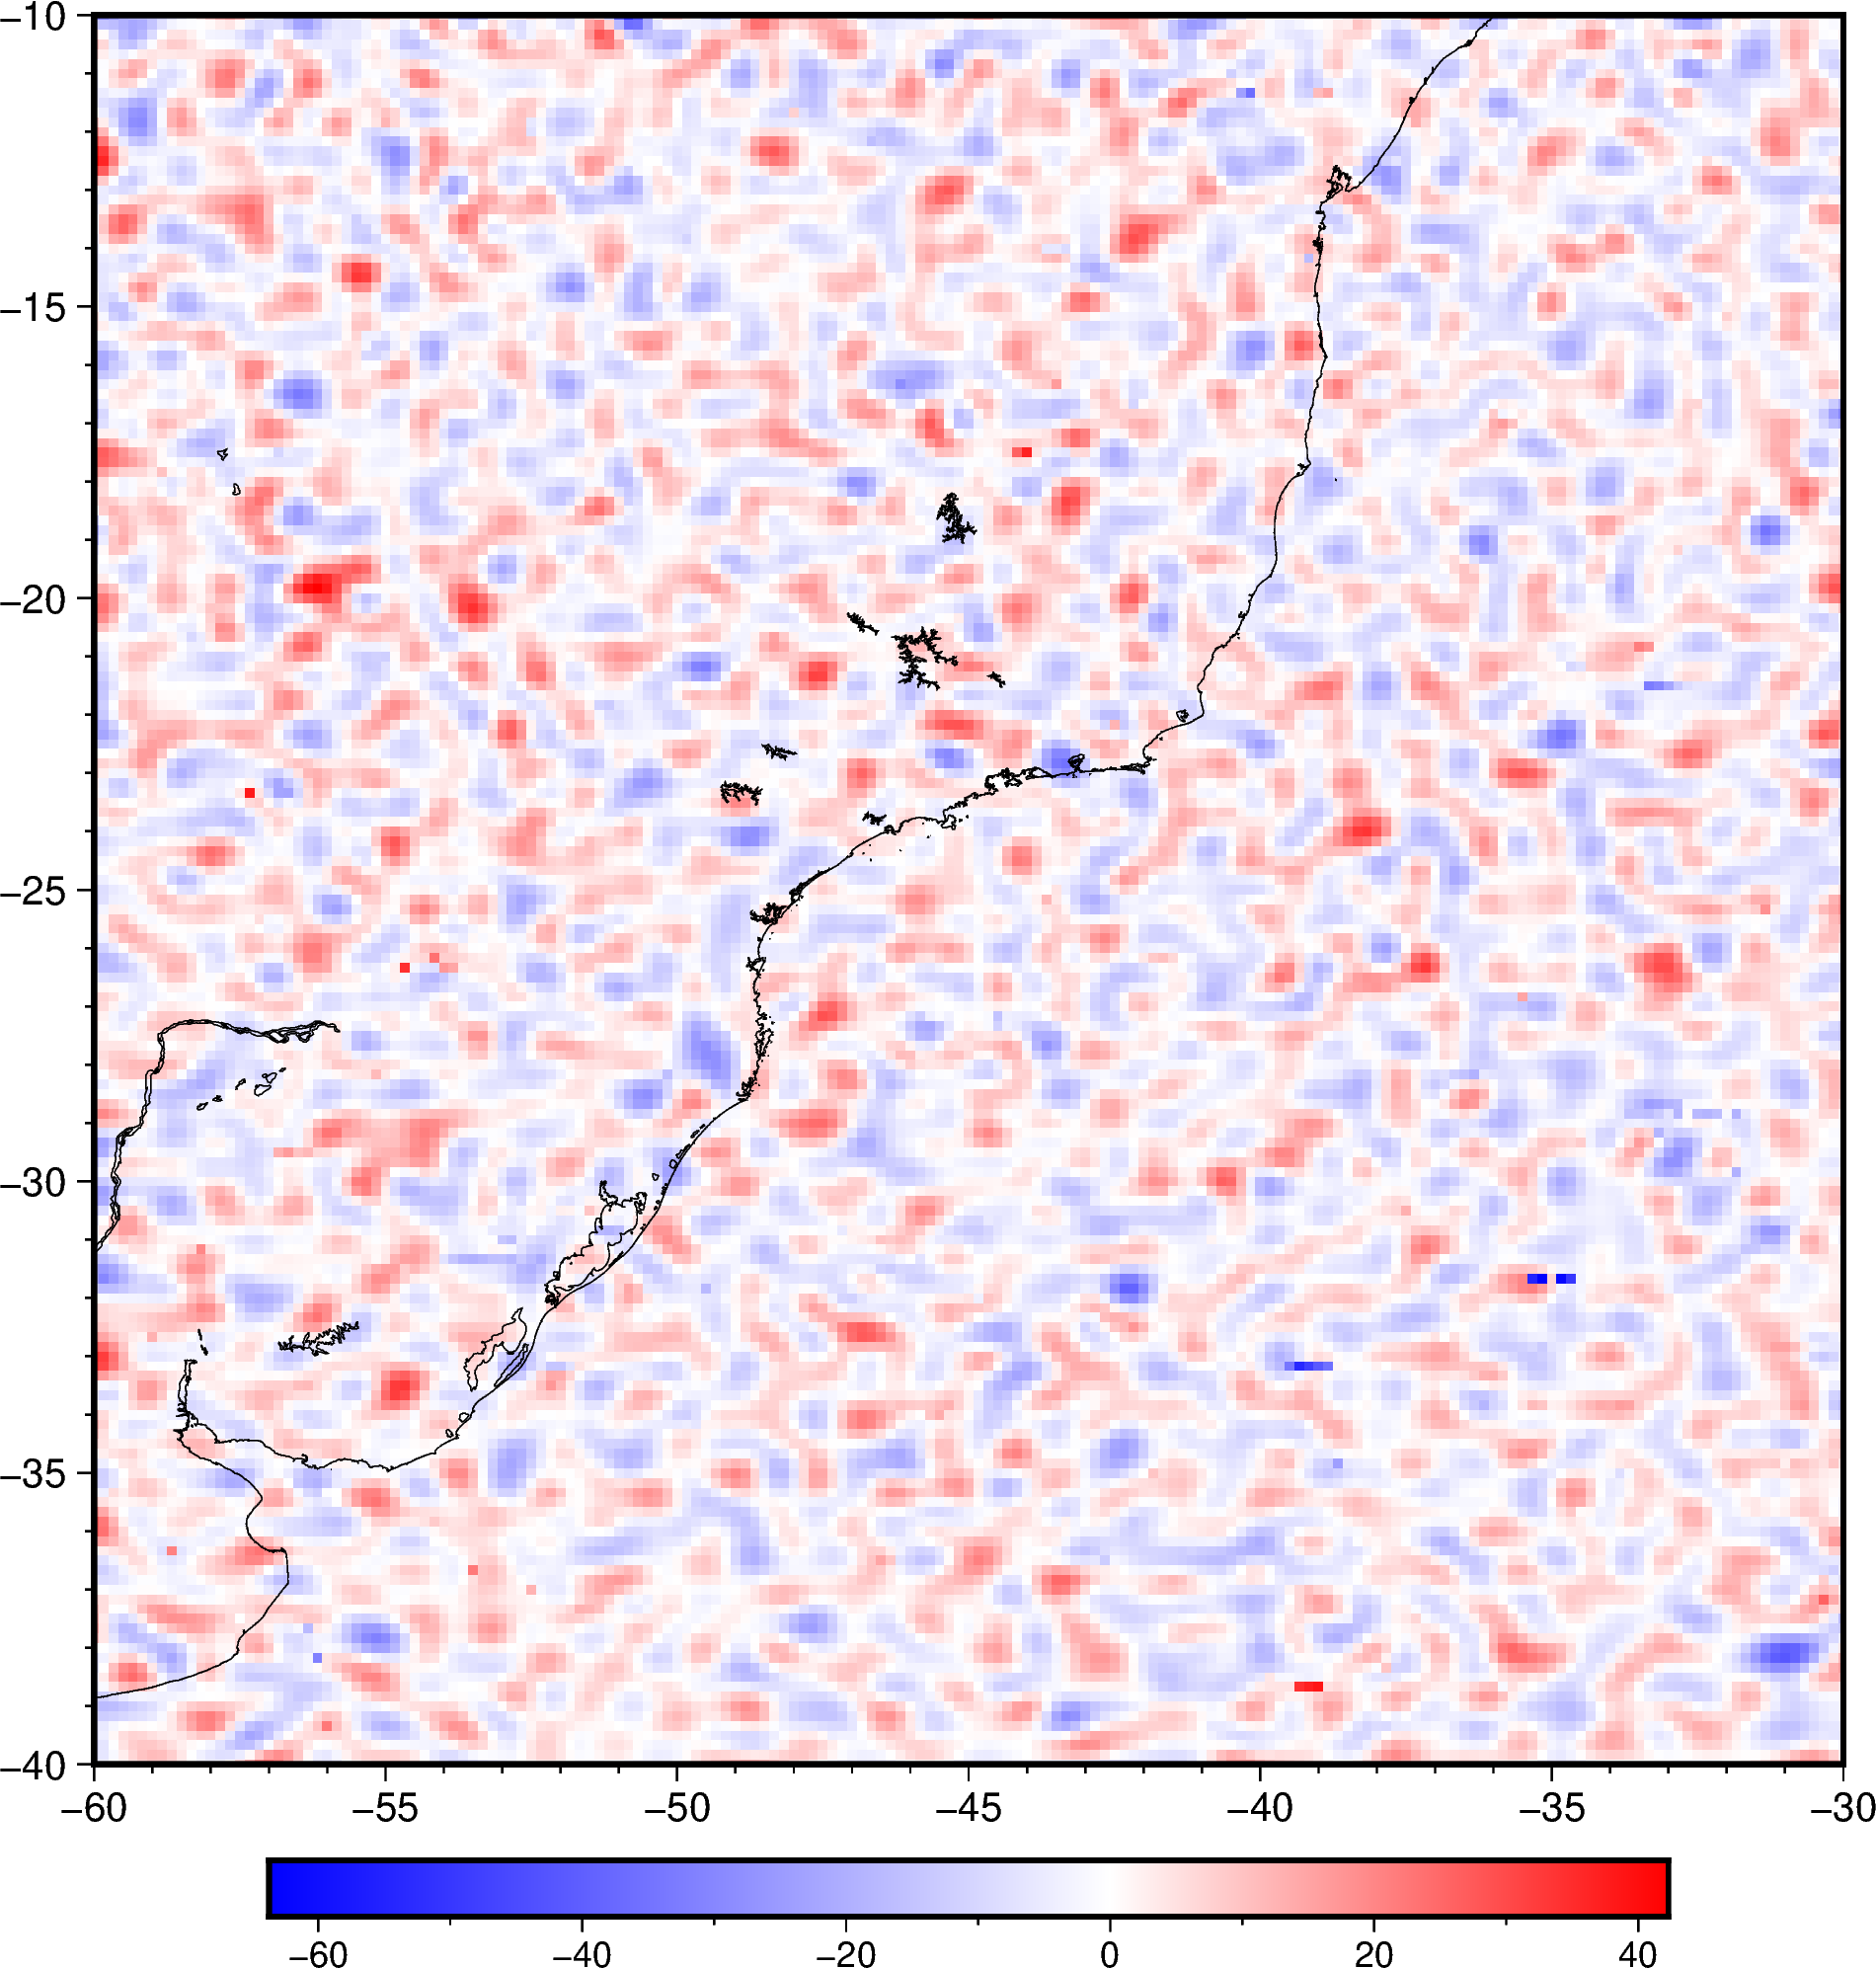

32 bits


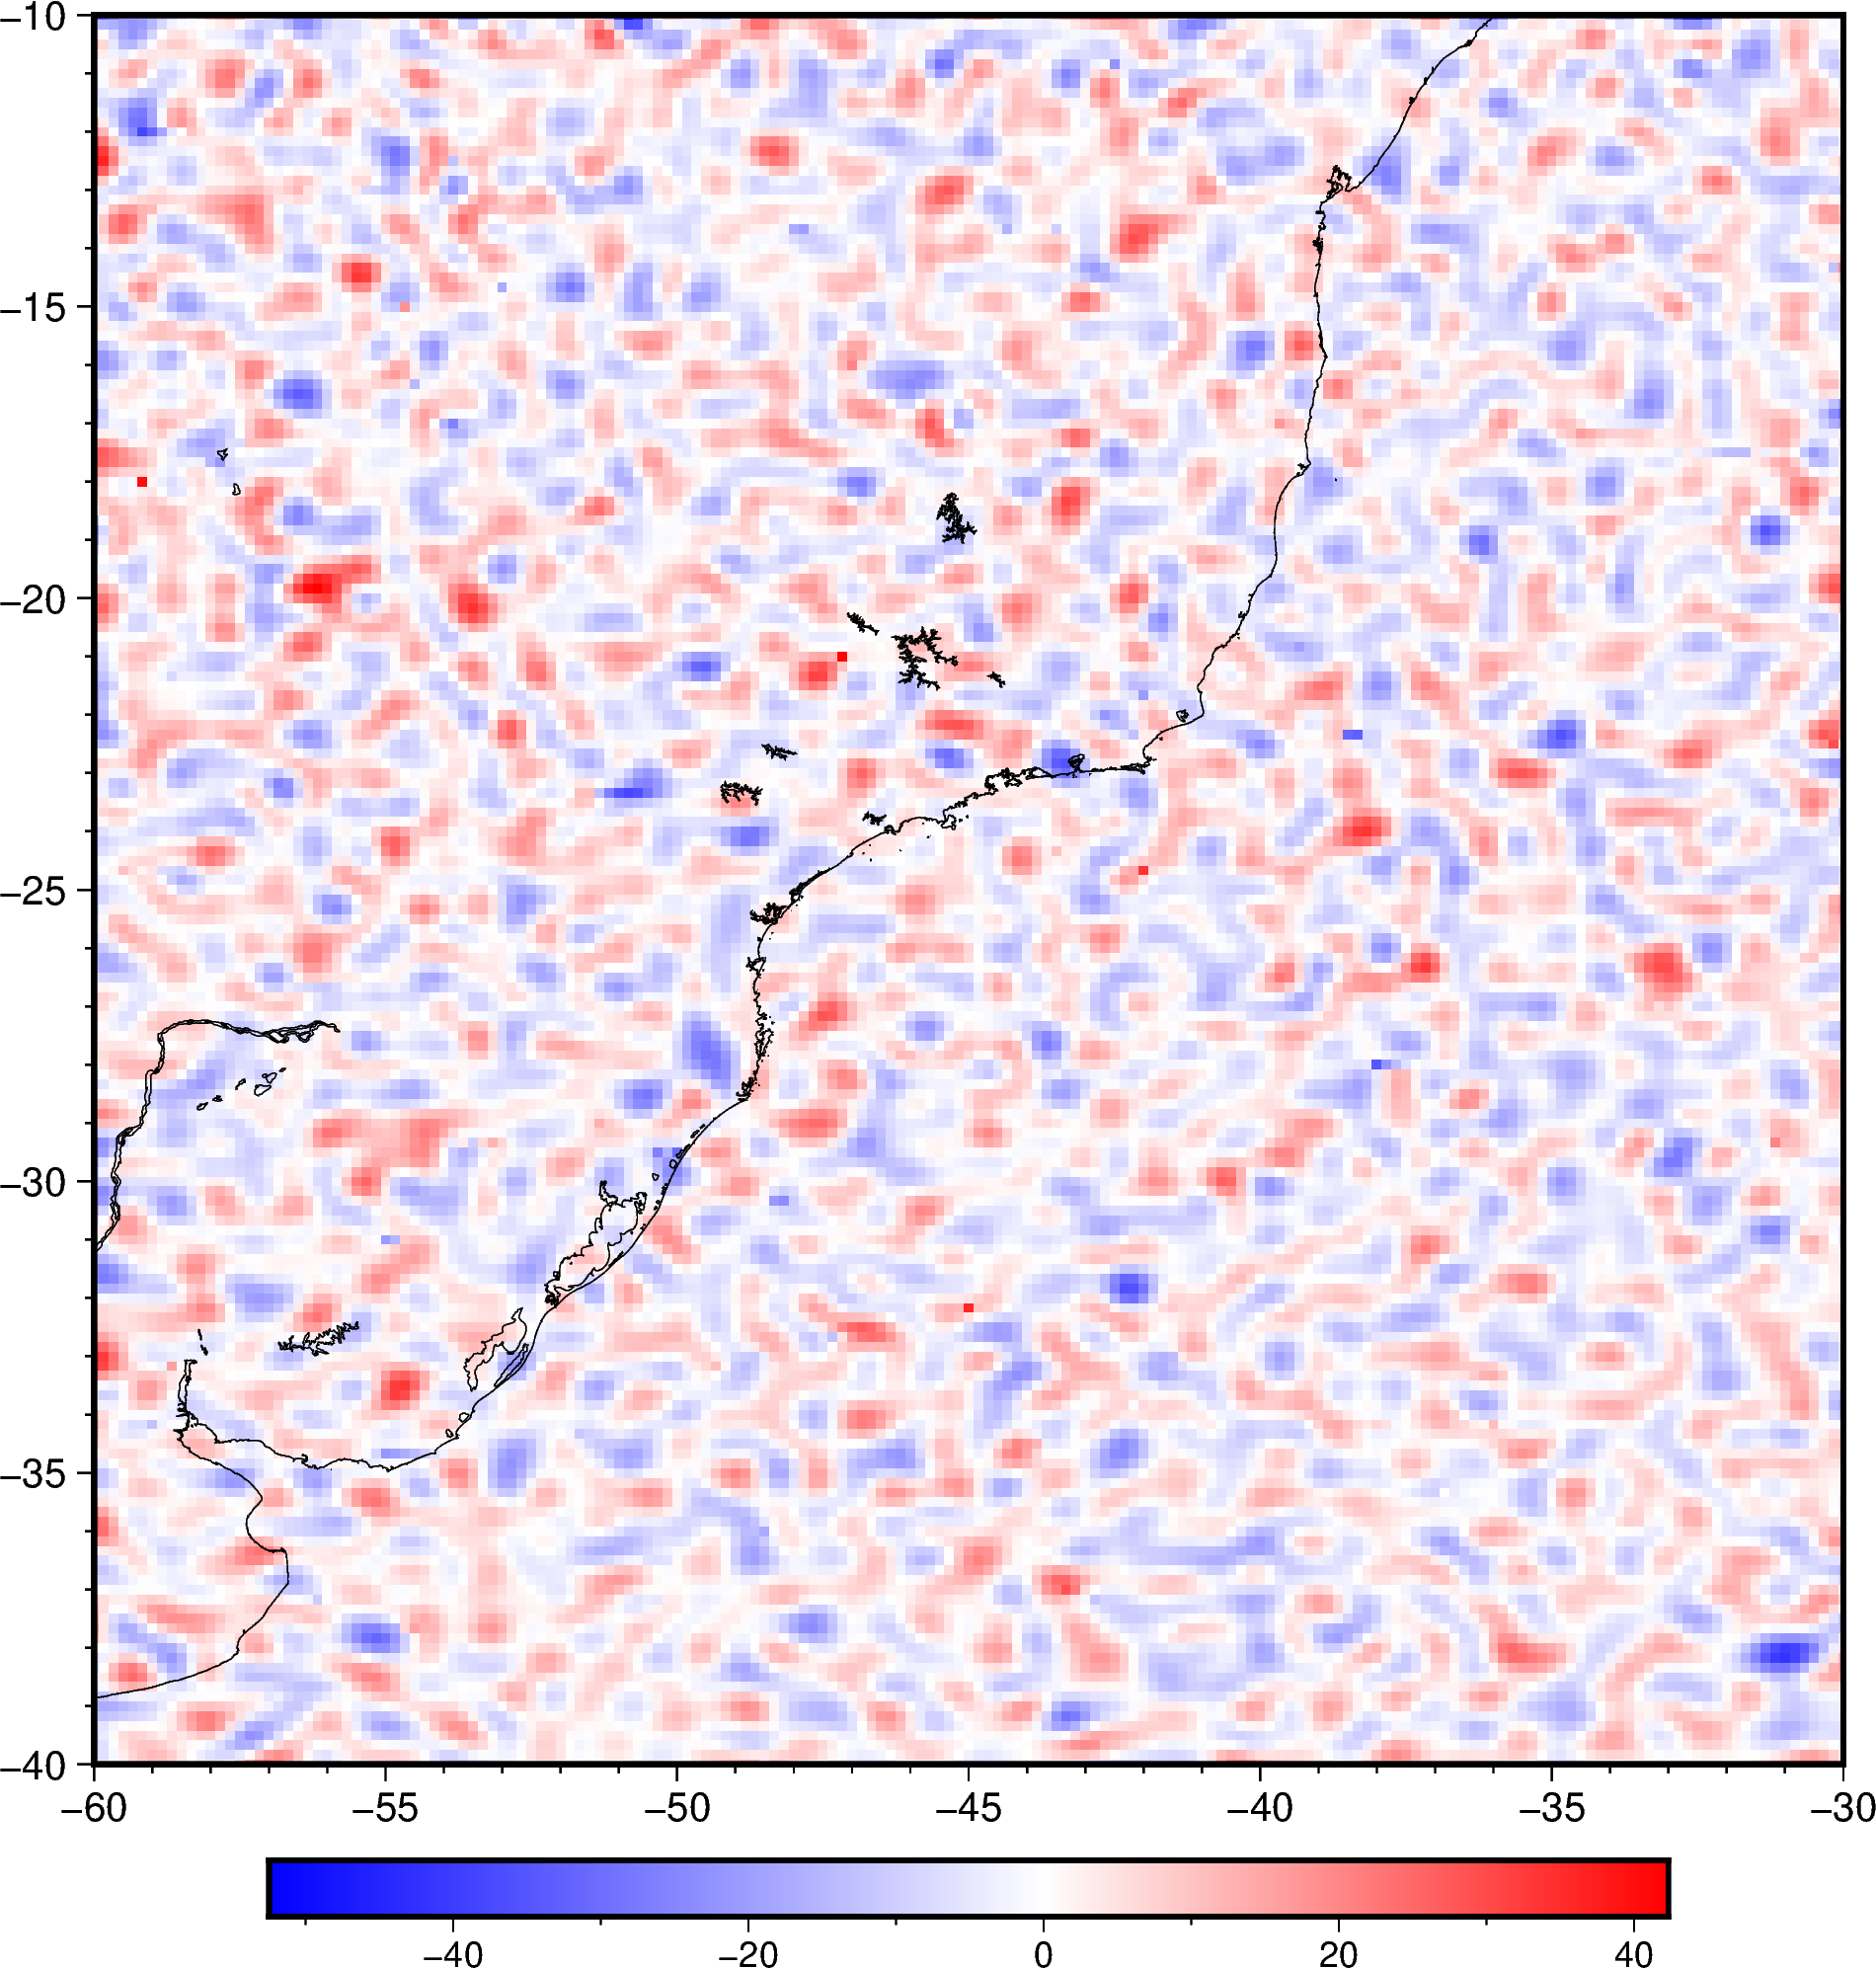

In [20]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Plot the windows.

64 bits


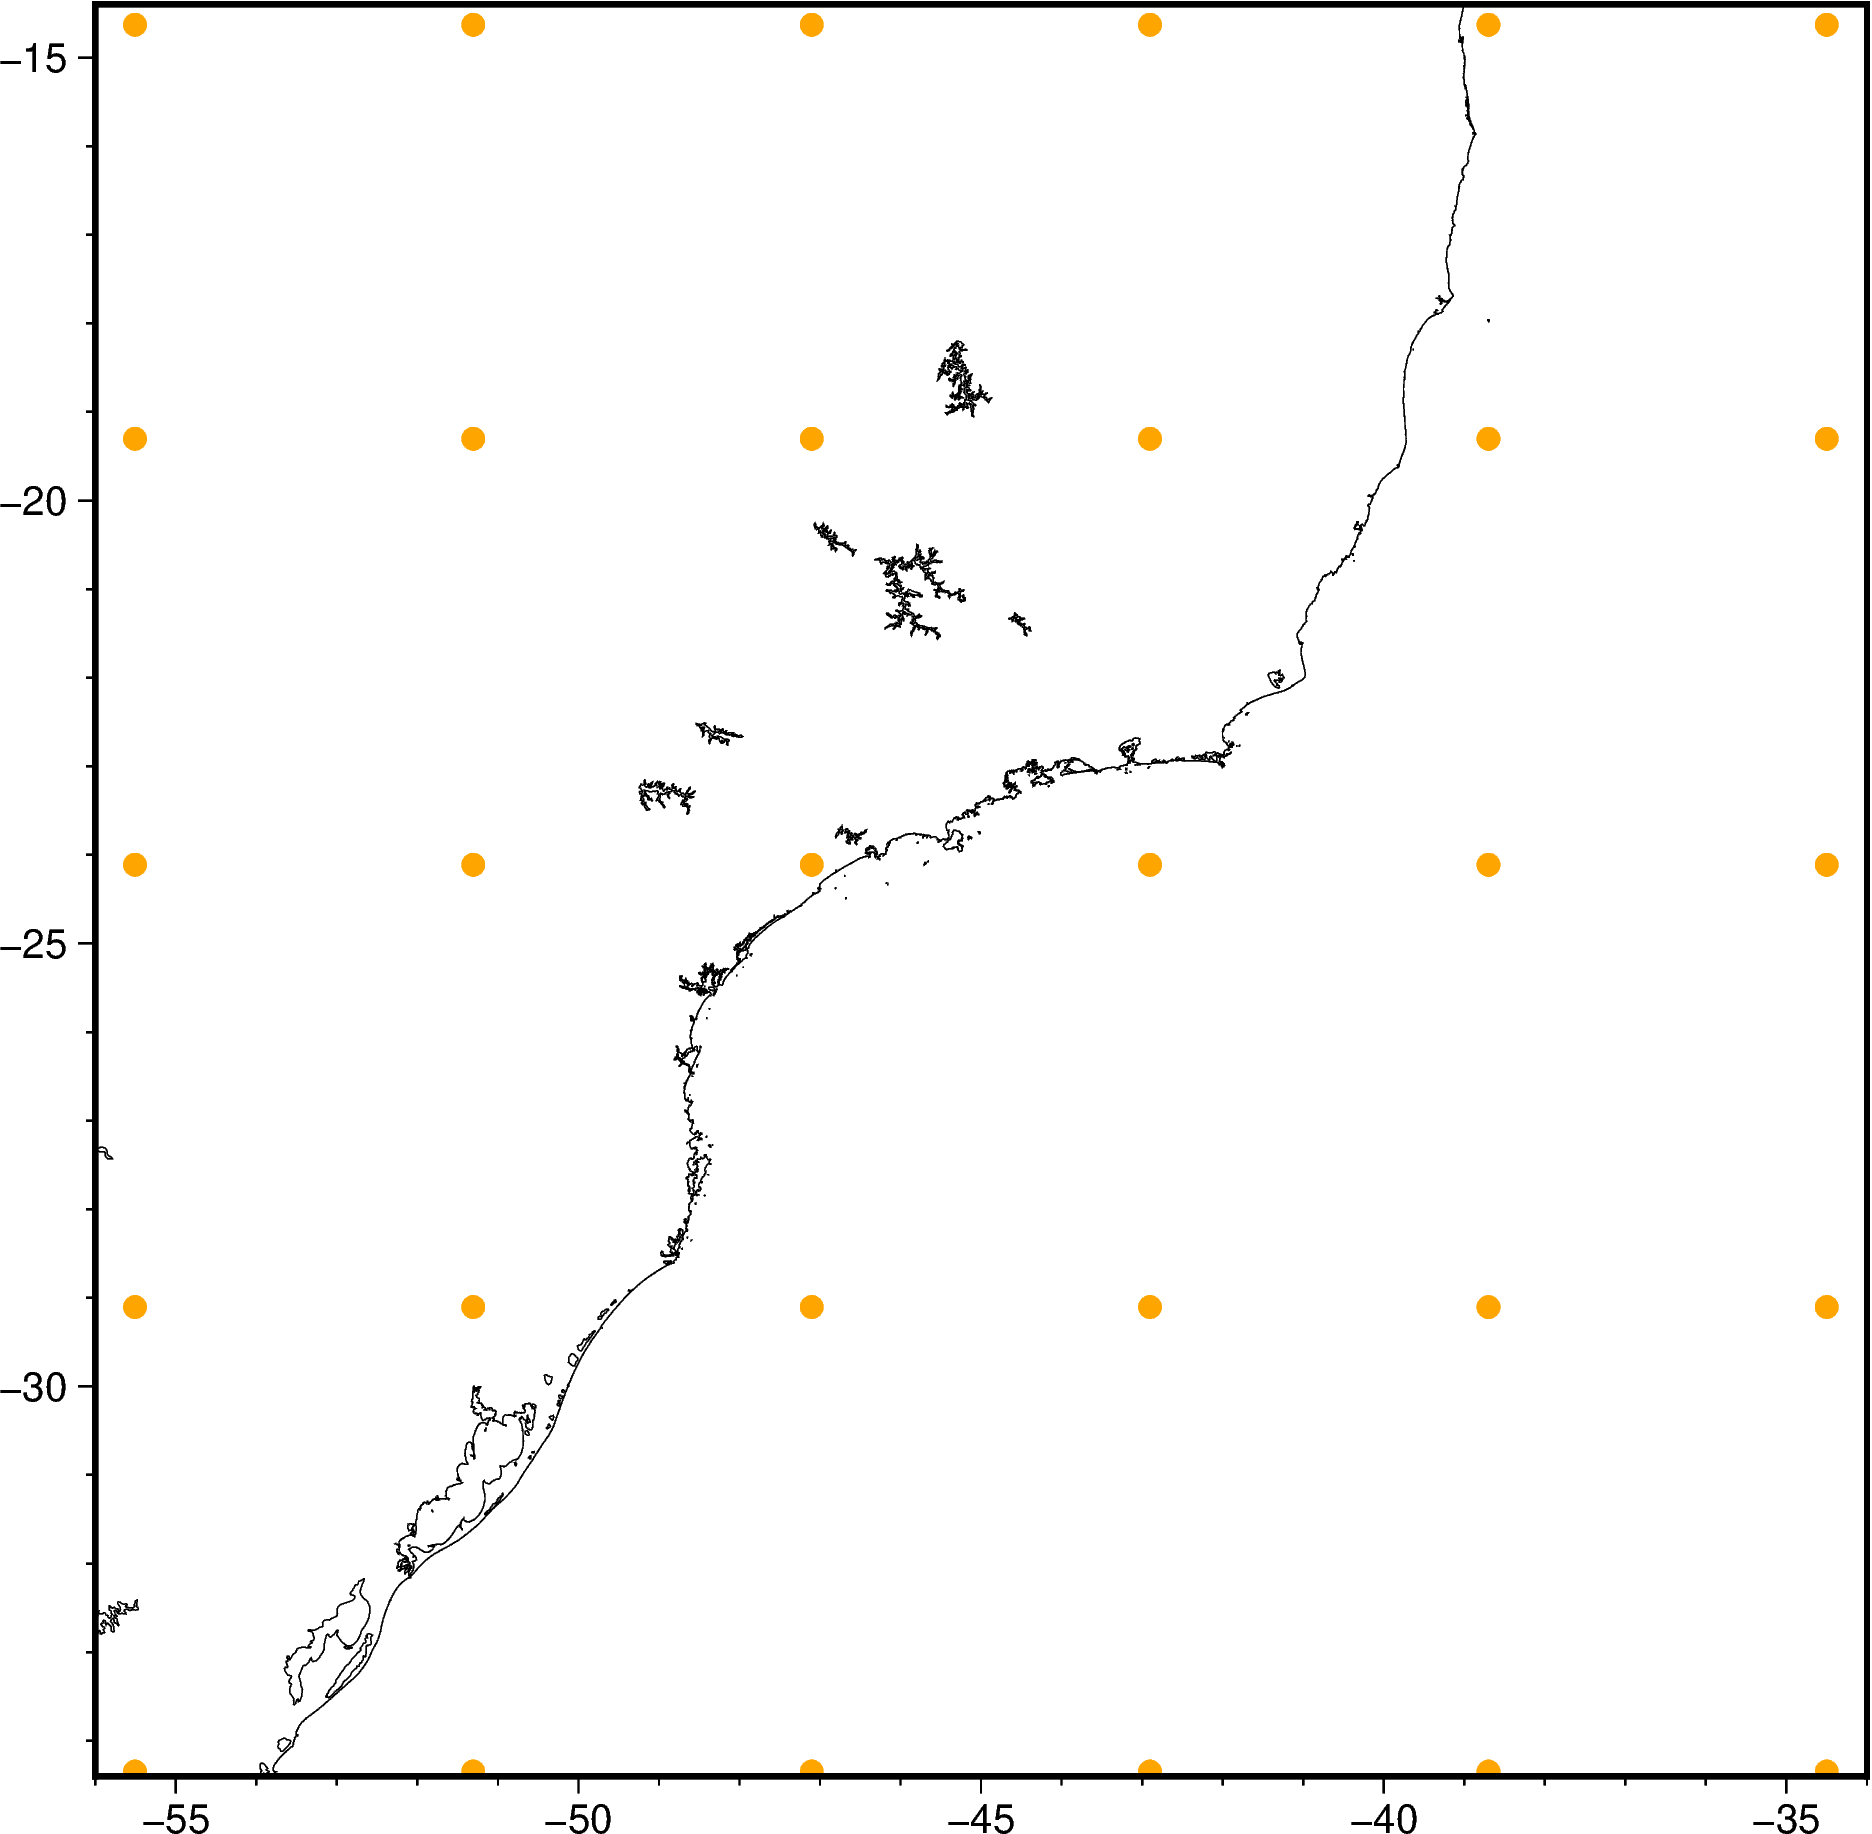

32 bits


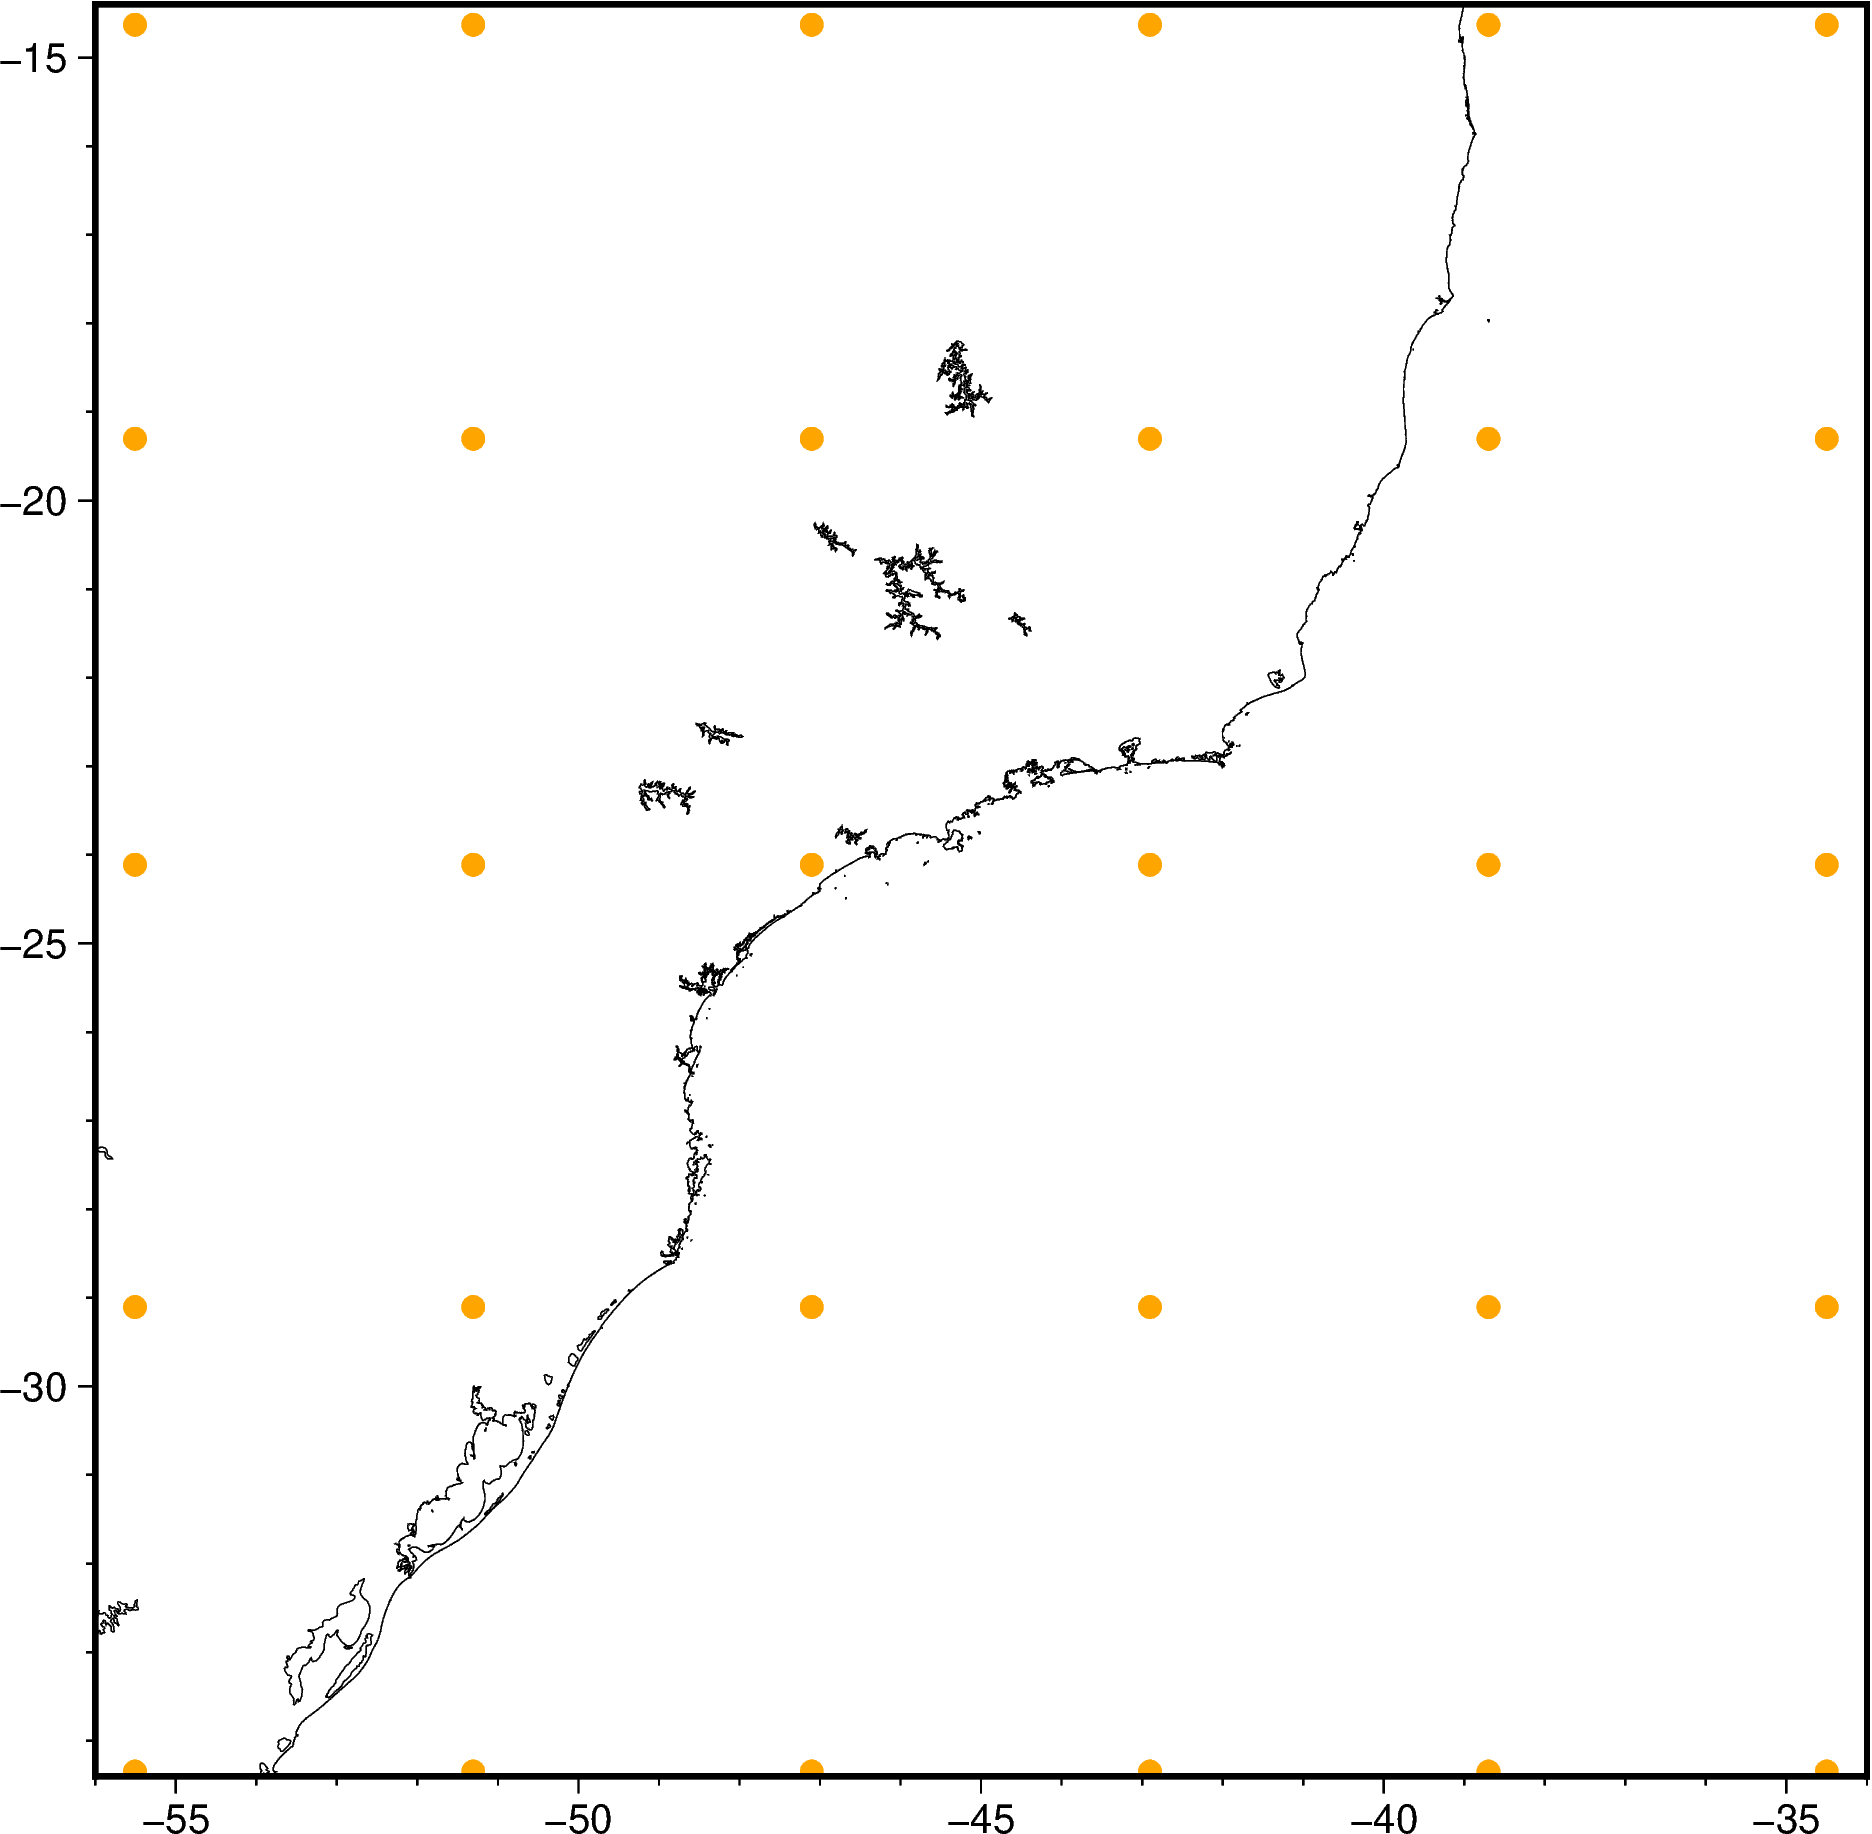

In [ ]:
# Não sei se isso muda de um para o outro averiguar posteriormente
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()


## Test in the poles

In [16]:
region = (0, 360, -90, -60)
grid_coordinates = bd.grid_coordinates(region, spacing=20/60, non_dimensional_coords=200)
dipole = (-66, -79, -200e3)
# Regional field
inclination, declination = -80, 0
dipole_moment = hm.magnetic_angles_to_vec(1e16, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

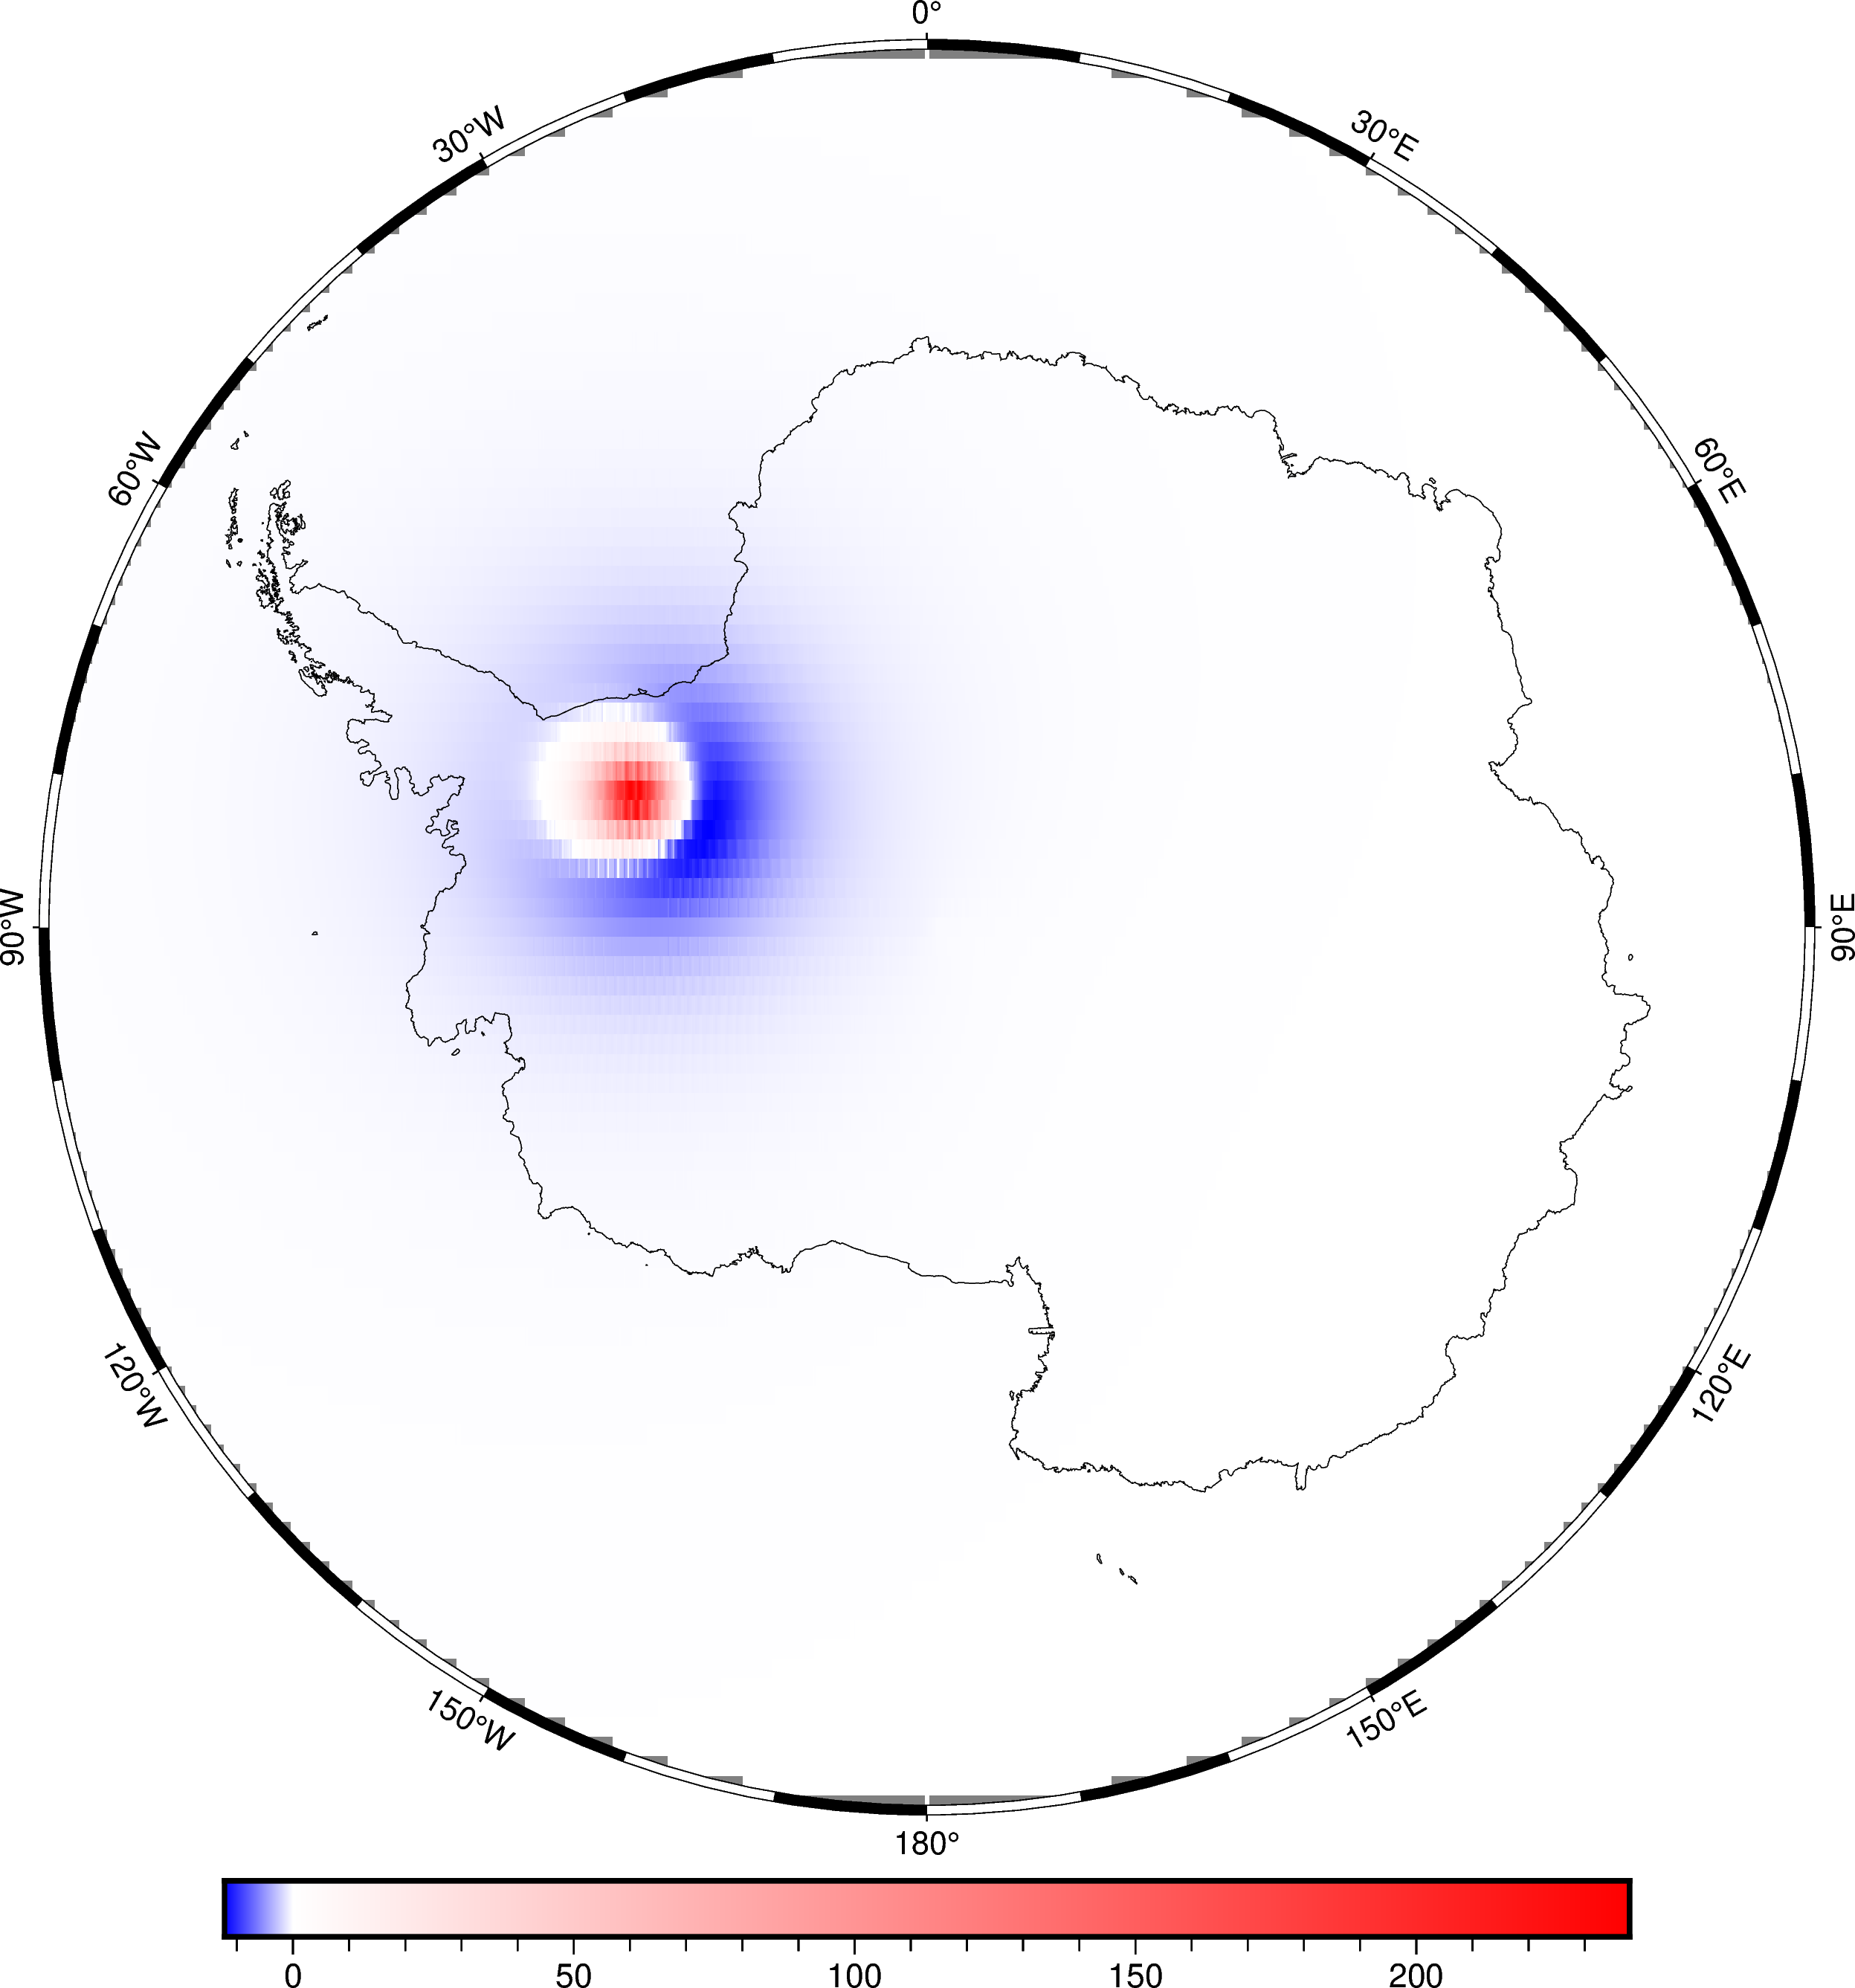

In [17]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

In [18]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.01 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

2.204339993740799 nT


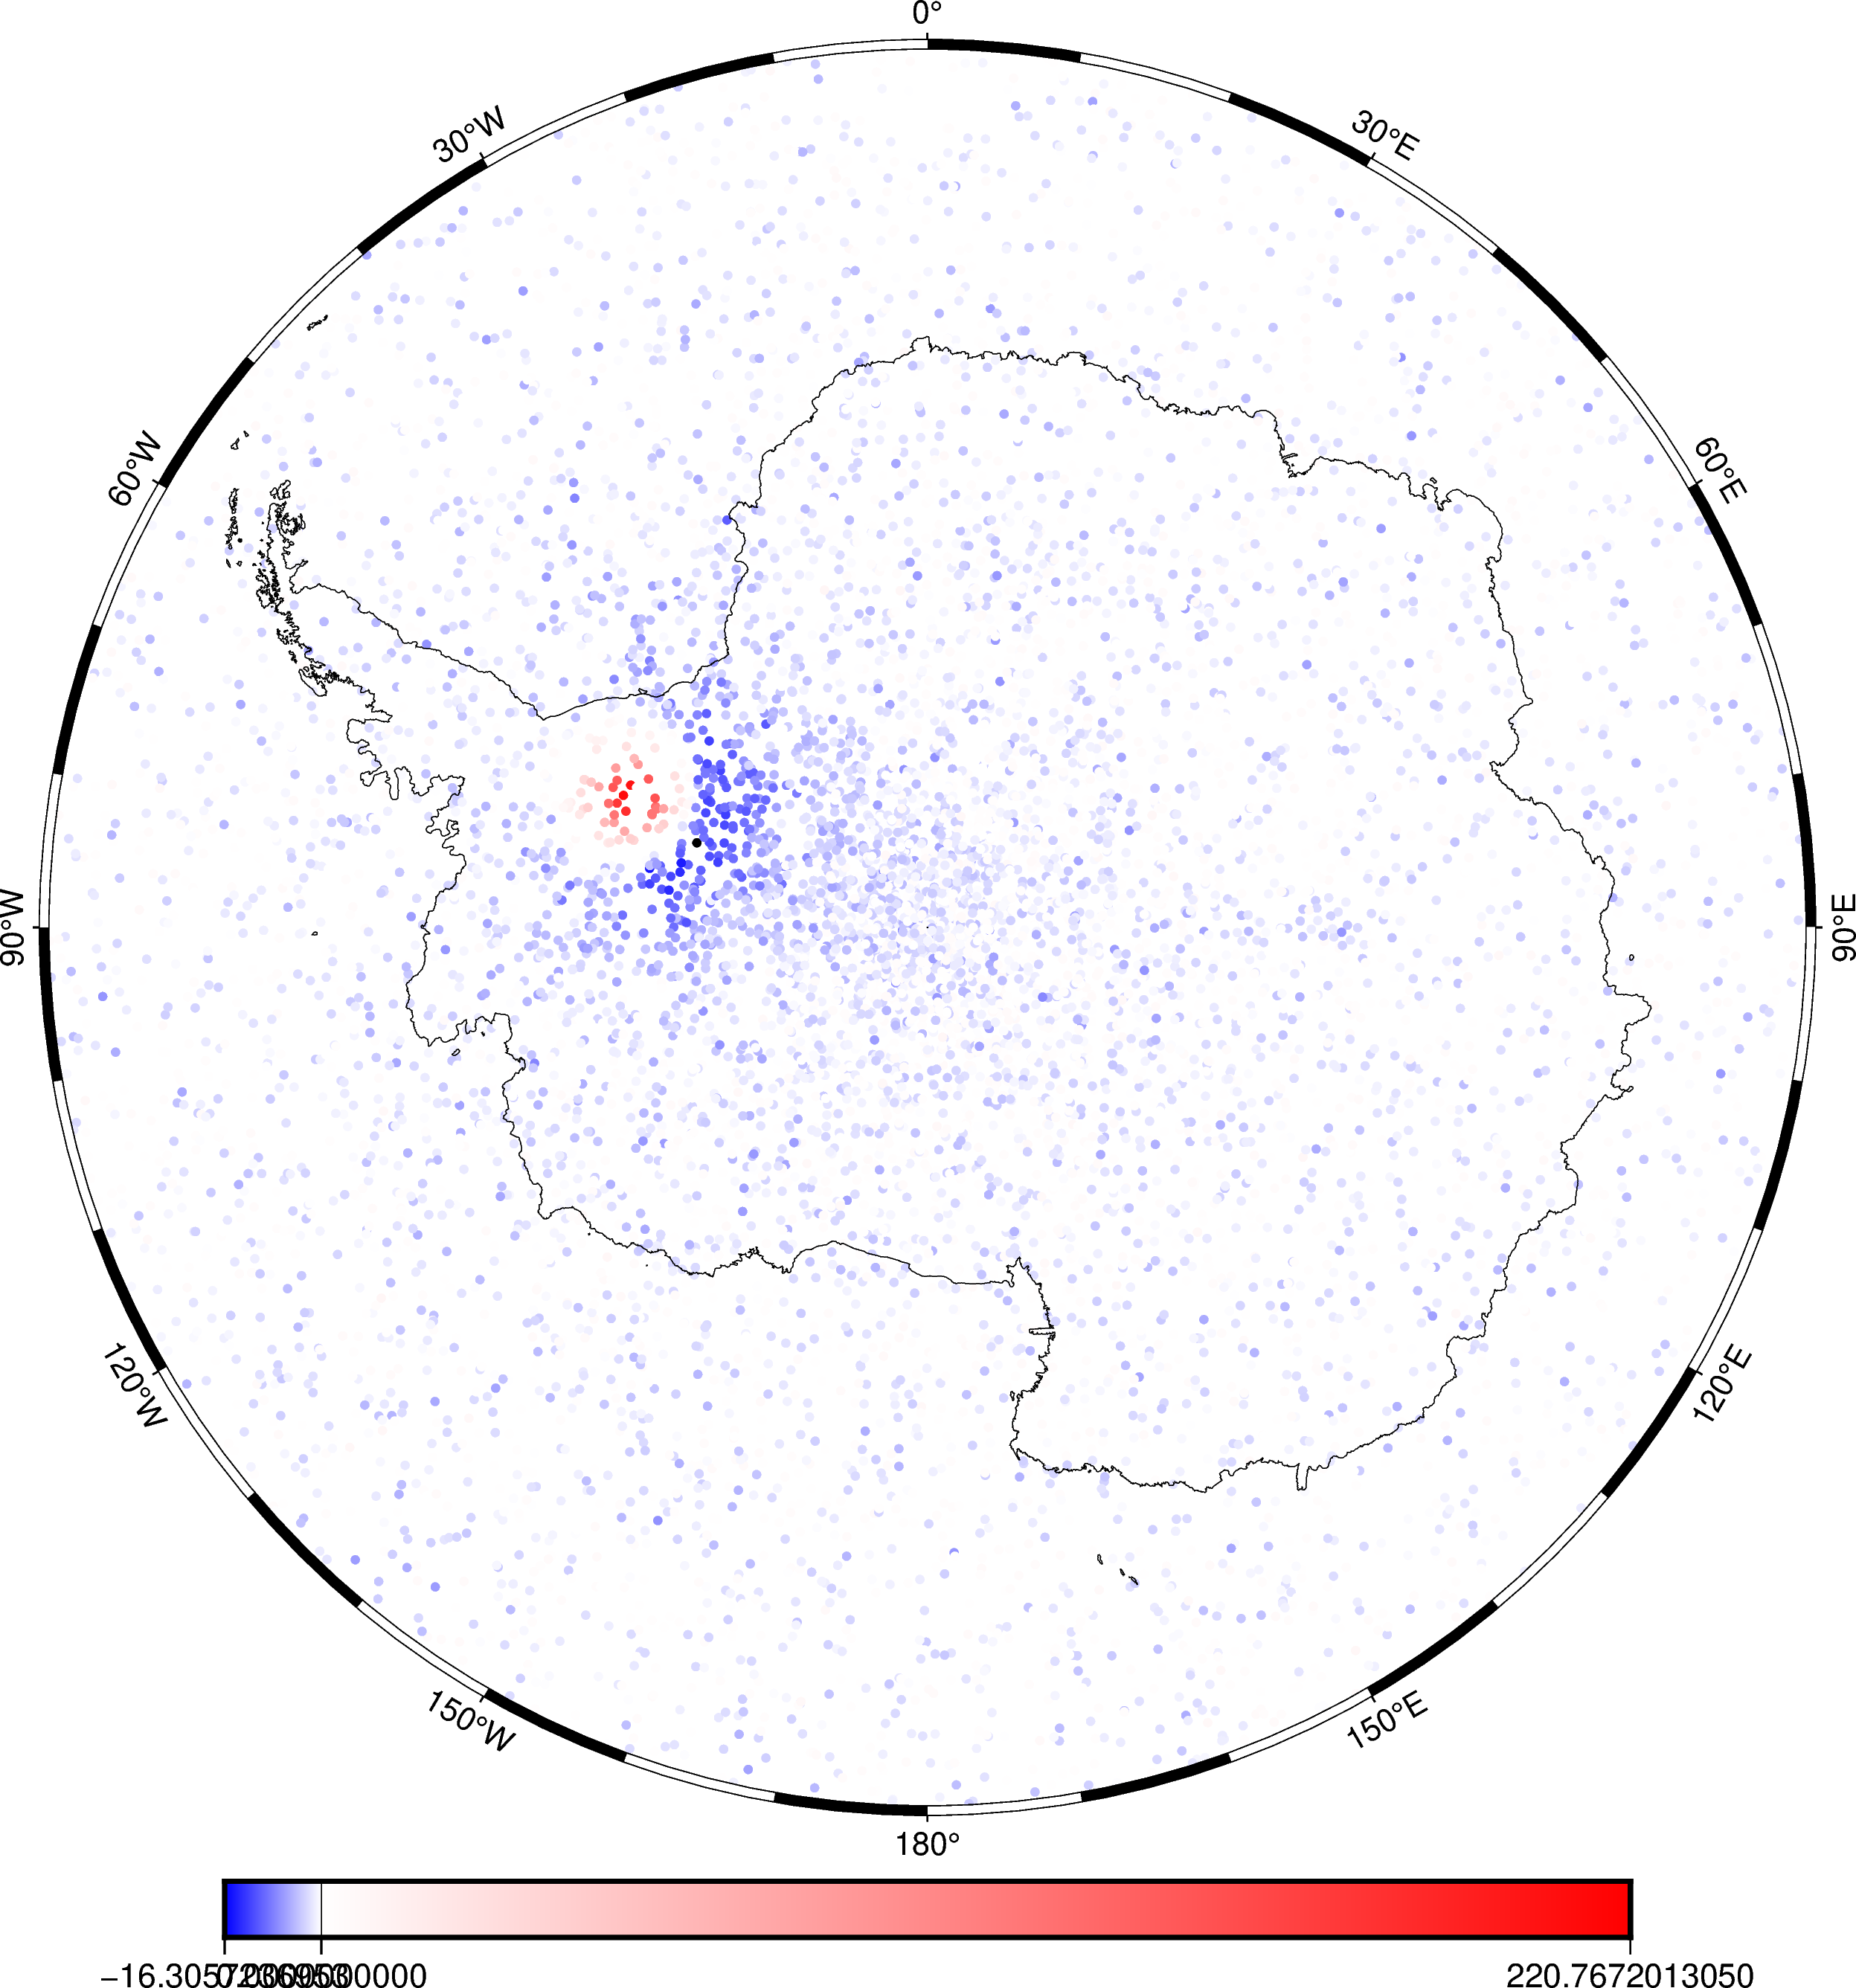

In [19]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.1c", cmap=True, frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles.

In [21]:
proj = pyproj.Proj(
                f"+proj=ups +south")
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_64.fit(coordinates, inclination, declination, data)
print(eqs_64.window_size_)

Output()

4797330.4343510885


Timer unit: 1e-09 s

Total time: 38.8743 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       1685.0   1685.0      0.0          if dtype is not None:
   551                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552                                                       data = np.asarray(data, dtype=dtype)
   5

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles. - 32 bits

In [22]:
proj = pyproj.Proj(
                f"+proj=ups +south")

eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")
print(eqs_32.window_size_)

Output()

4797330.456840022


Timer unit: 1e-09 s

Total time: 21.1982 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       2861.0   2861.0      0.0          if dtype is not None:
   551         1    8405215.0 8.41e+06      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1    3373138.0 3.37e+06      0.0              data = np.asarray(data, dtype=dtype)
   5

In [26]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 4


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })



Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:48

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:38

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:36

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:35

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:19

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:20

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:20

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:19

In [ ]:
# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados

--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão 

Traceback (most recent call last):
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/threading.py", line 1381, in invoke_excepthook
    hook(args)
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/rich/file_proxy.py", line 43, in write
    with console:
         ^^^^^^^
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/rich/console.py", line 870, in __exit__
    self._exit_buffer()
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/rich/console.py", line 826, in _exit_buffer
    self._check_buffer()
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/rich/console.py", line 2038, in _check_buffer
    self._write_buffer()
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site-packages/rich/console.py", line 2054, in _write_buffer
    display(self._buffer, self._render_buffer(self._buffer[:]))
  File "/home/bpereiras/miniconda3/envs/hpc-env/lib/python3.12/site

--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão ---
--- Estatísticas Descritivas por Versão 

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

RecursionError: maximum recursion depth exceeded

Plotting the statistics

In [ ]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Comparação de Desempenho (Medições Individuais)')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_3.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('Comparação de Desempenho do Spline.fit() por Precisão do Dado')
ax.set_ylabel('Tempo de Execução (segundos)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_3.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


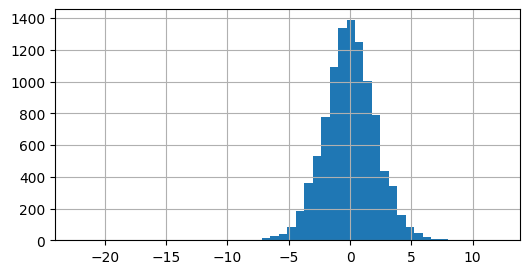

32 bits


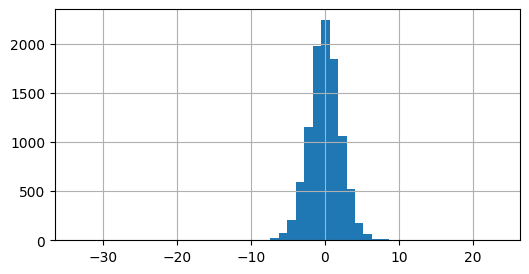

In [9]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [10]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

64 bits


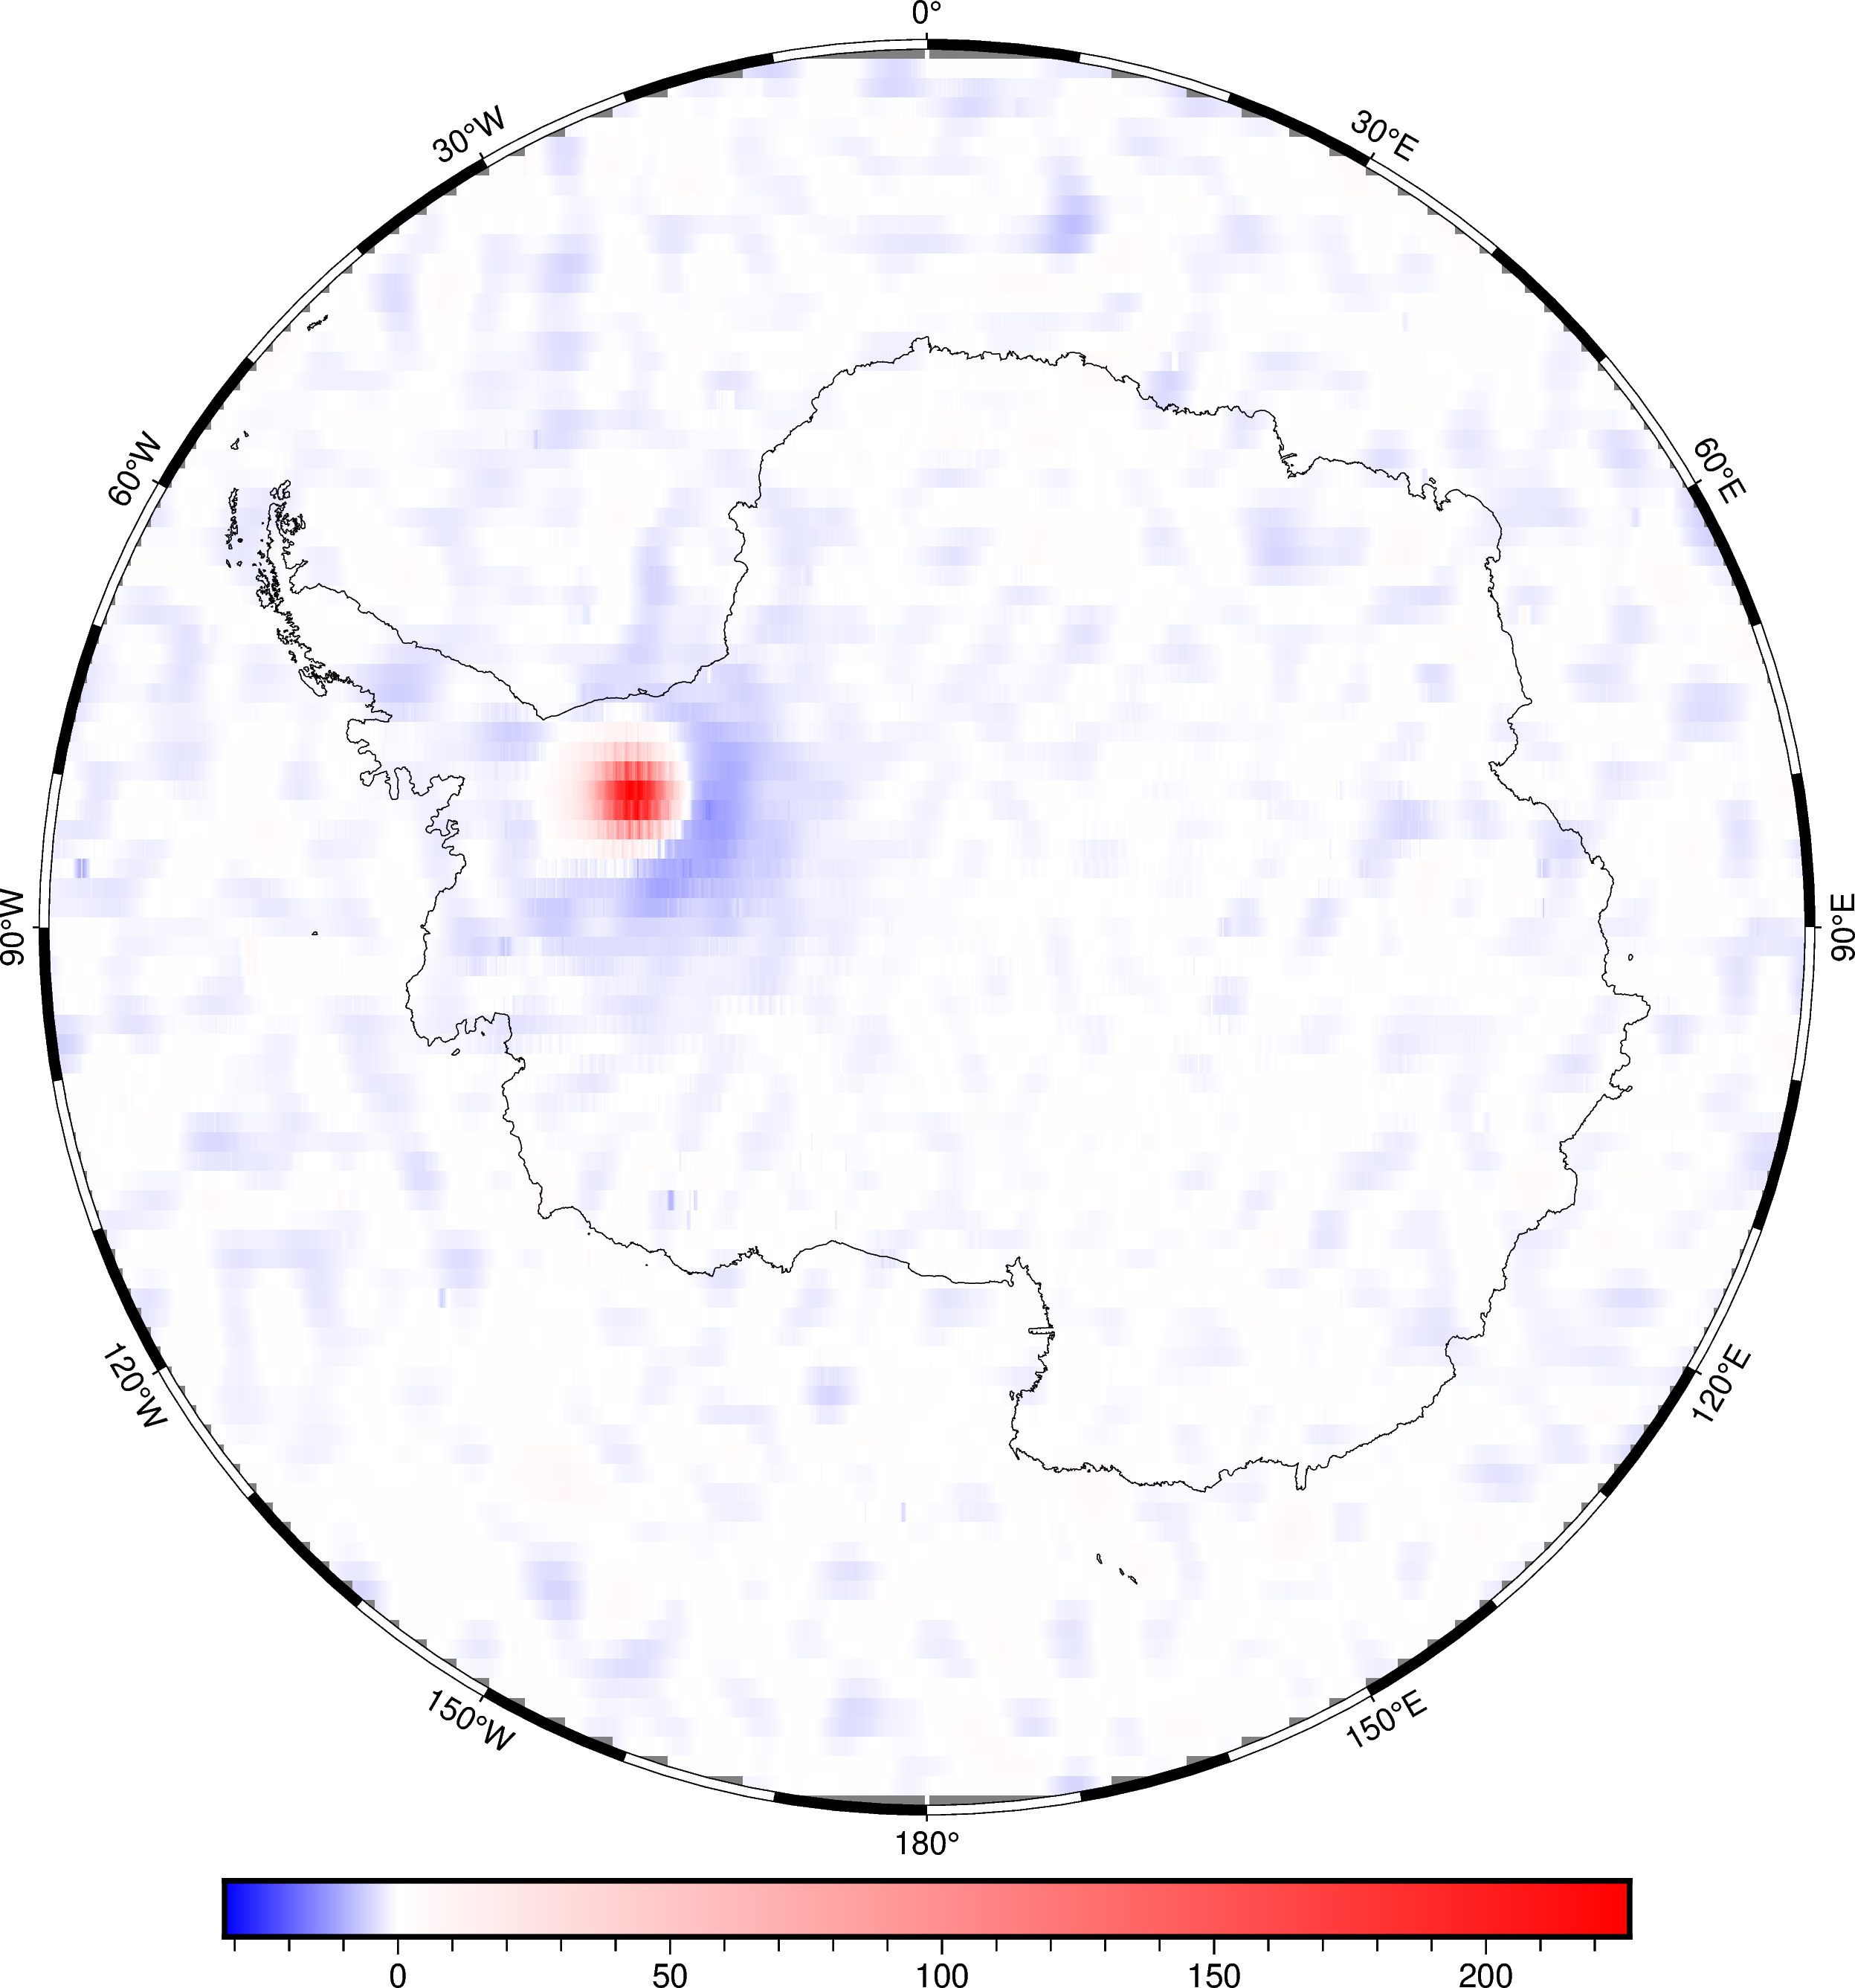

32 bits


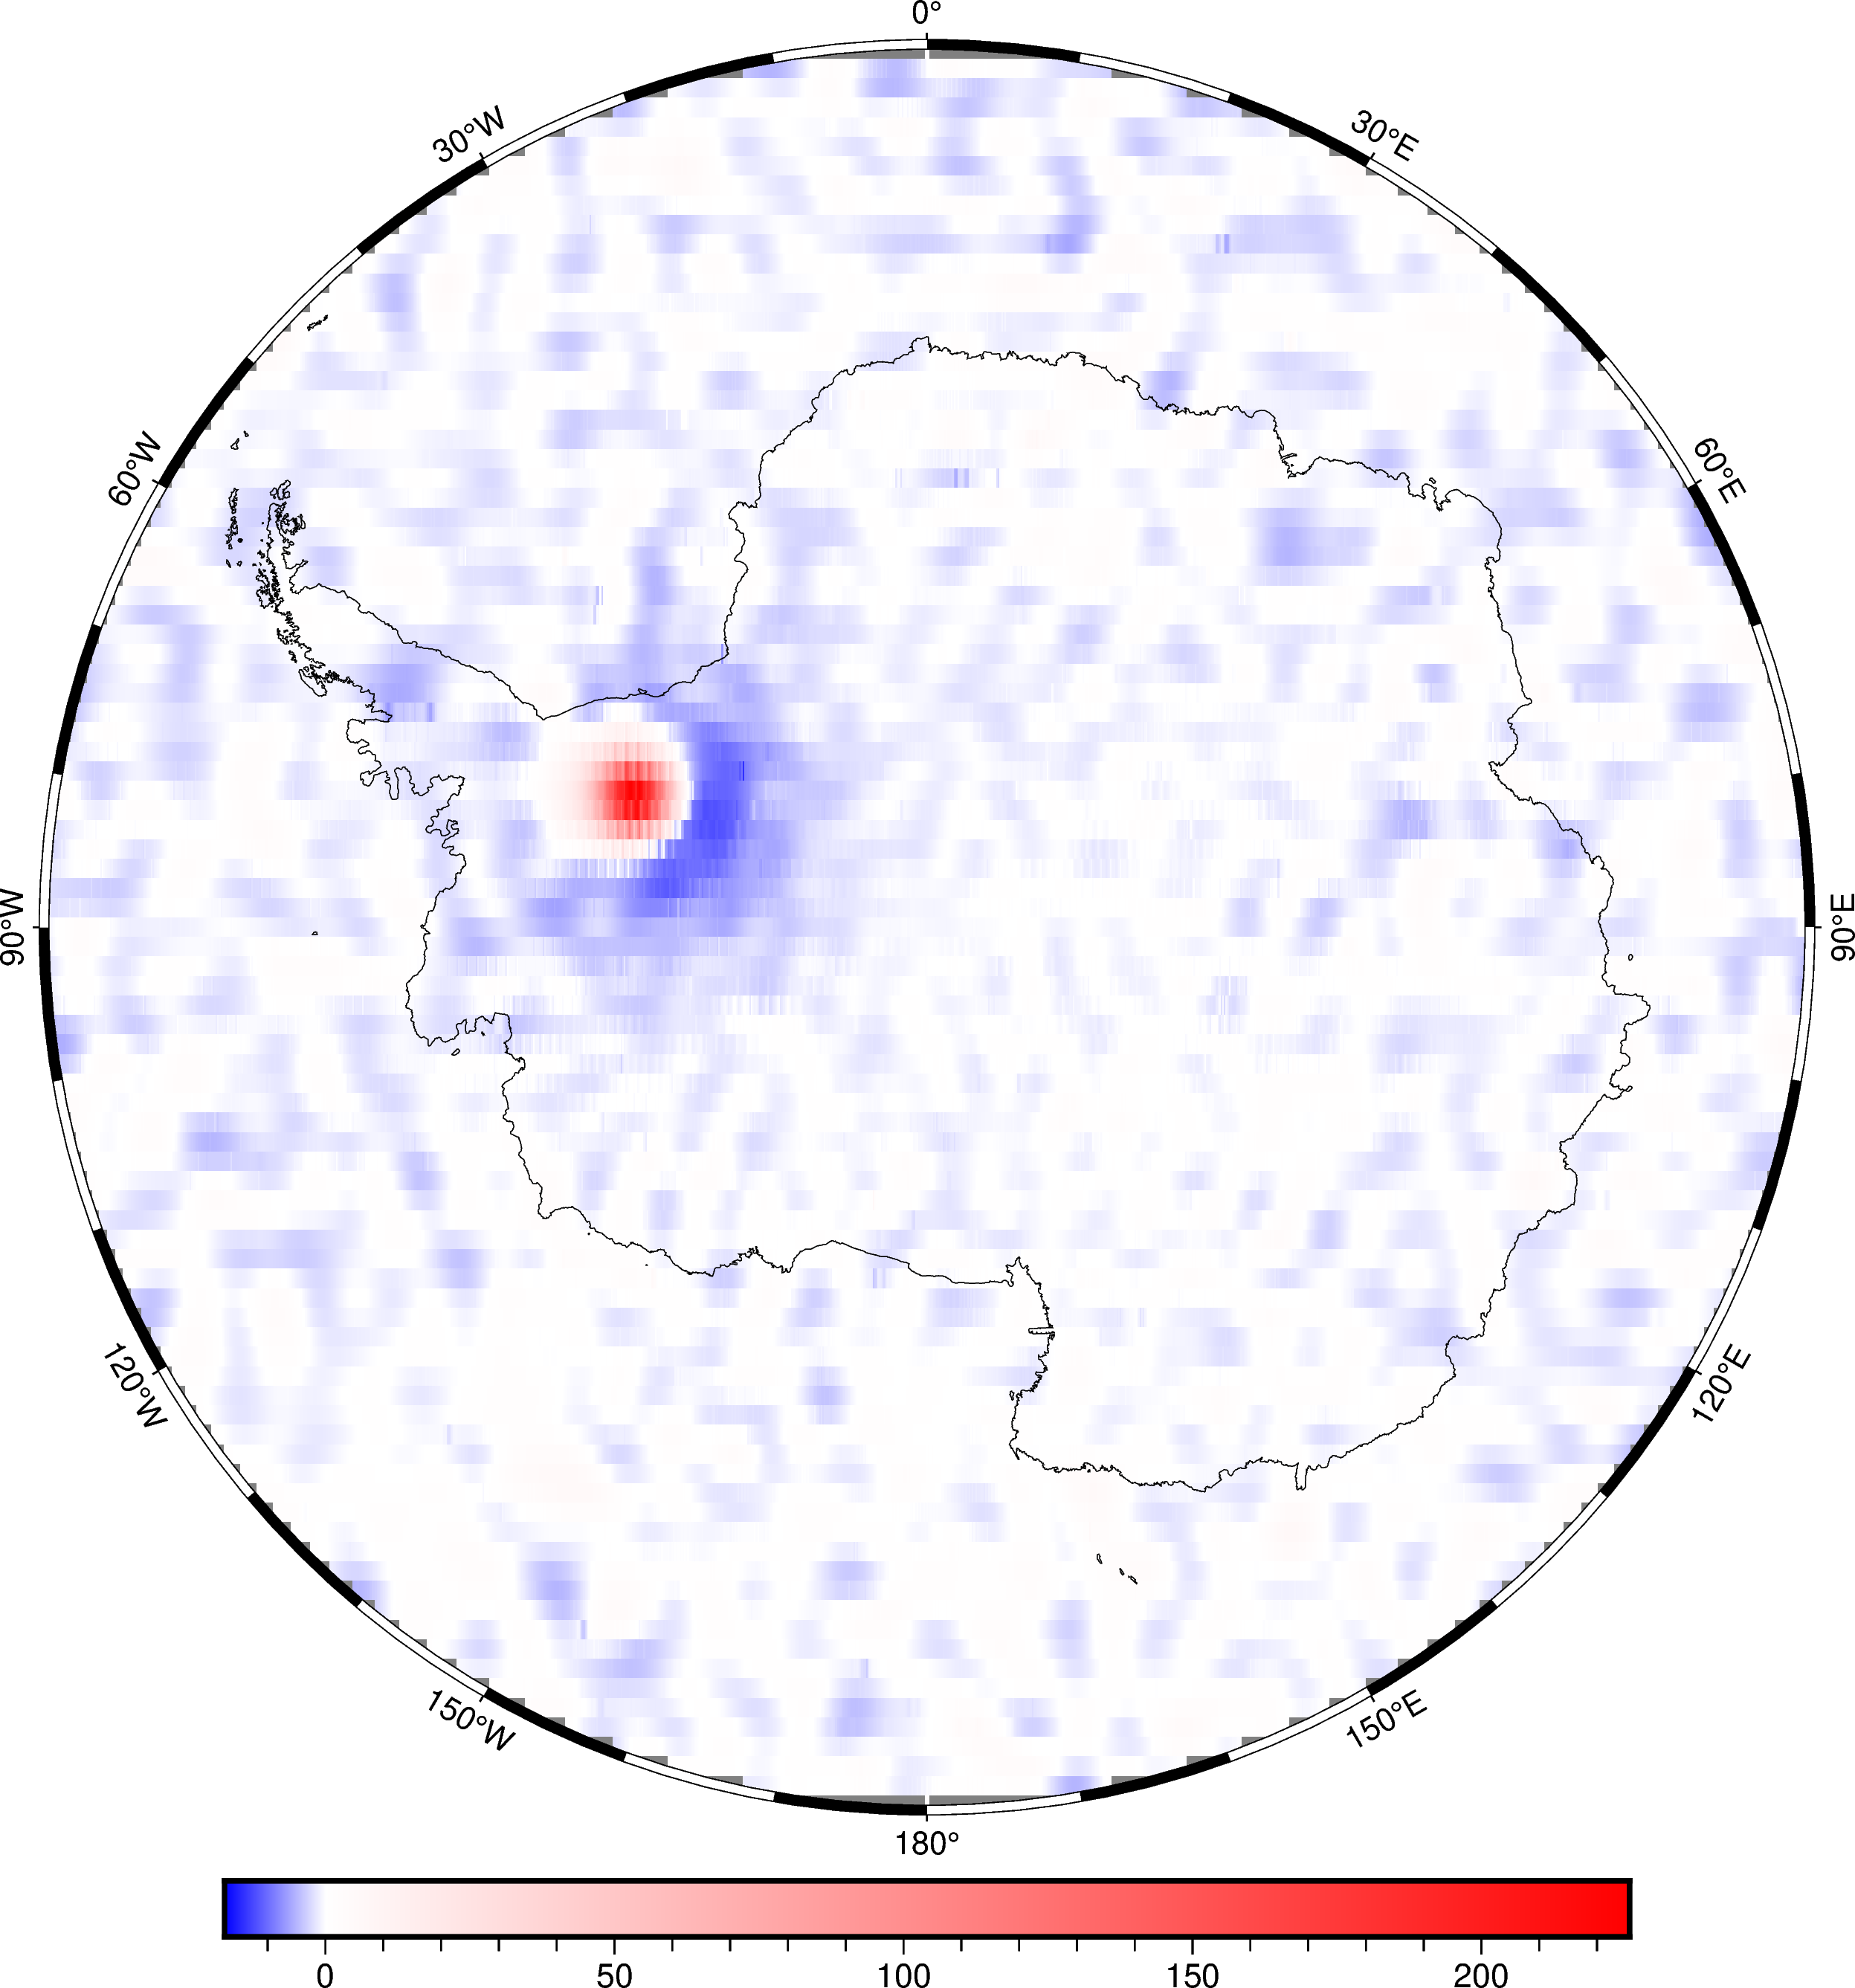

In [11]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_64, cmap="polar+h", frame=True , projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_32, cmap="polar+h", frame=True , projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Diferença da precisão

In [17]:
# --- 1. Extração dos Dados Numéricos ---

# A função de cálculo do erro funciona com os arrays NumPy que estão
# dentro dos seus grids xarray. Acessamos eles com o atributo '.values'.
valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

# O primeiro argumento é o nosso "gabarito" (maior precisão)
# O segundo é a versão que queremos comparar
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 0.2152348121592734
A Raiz do Erro Quadrático Médio (RMSE) é: 0.4639 nT


Show the difference

64 bits


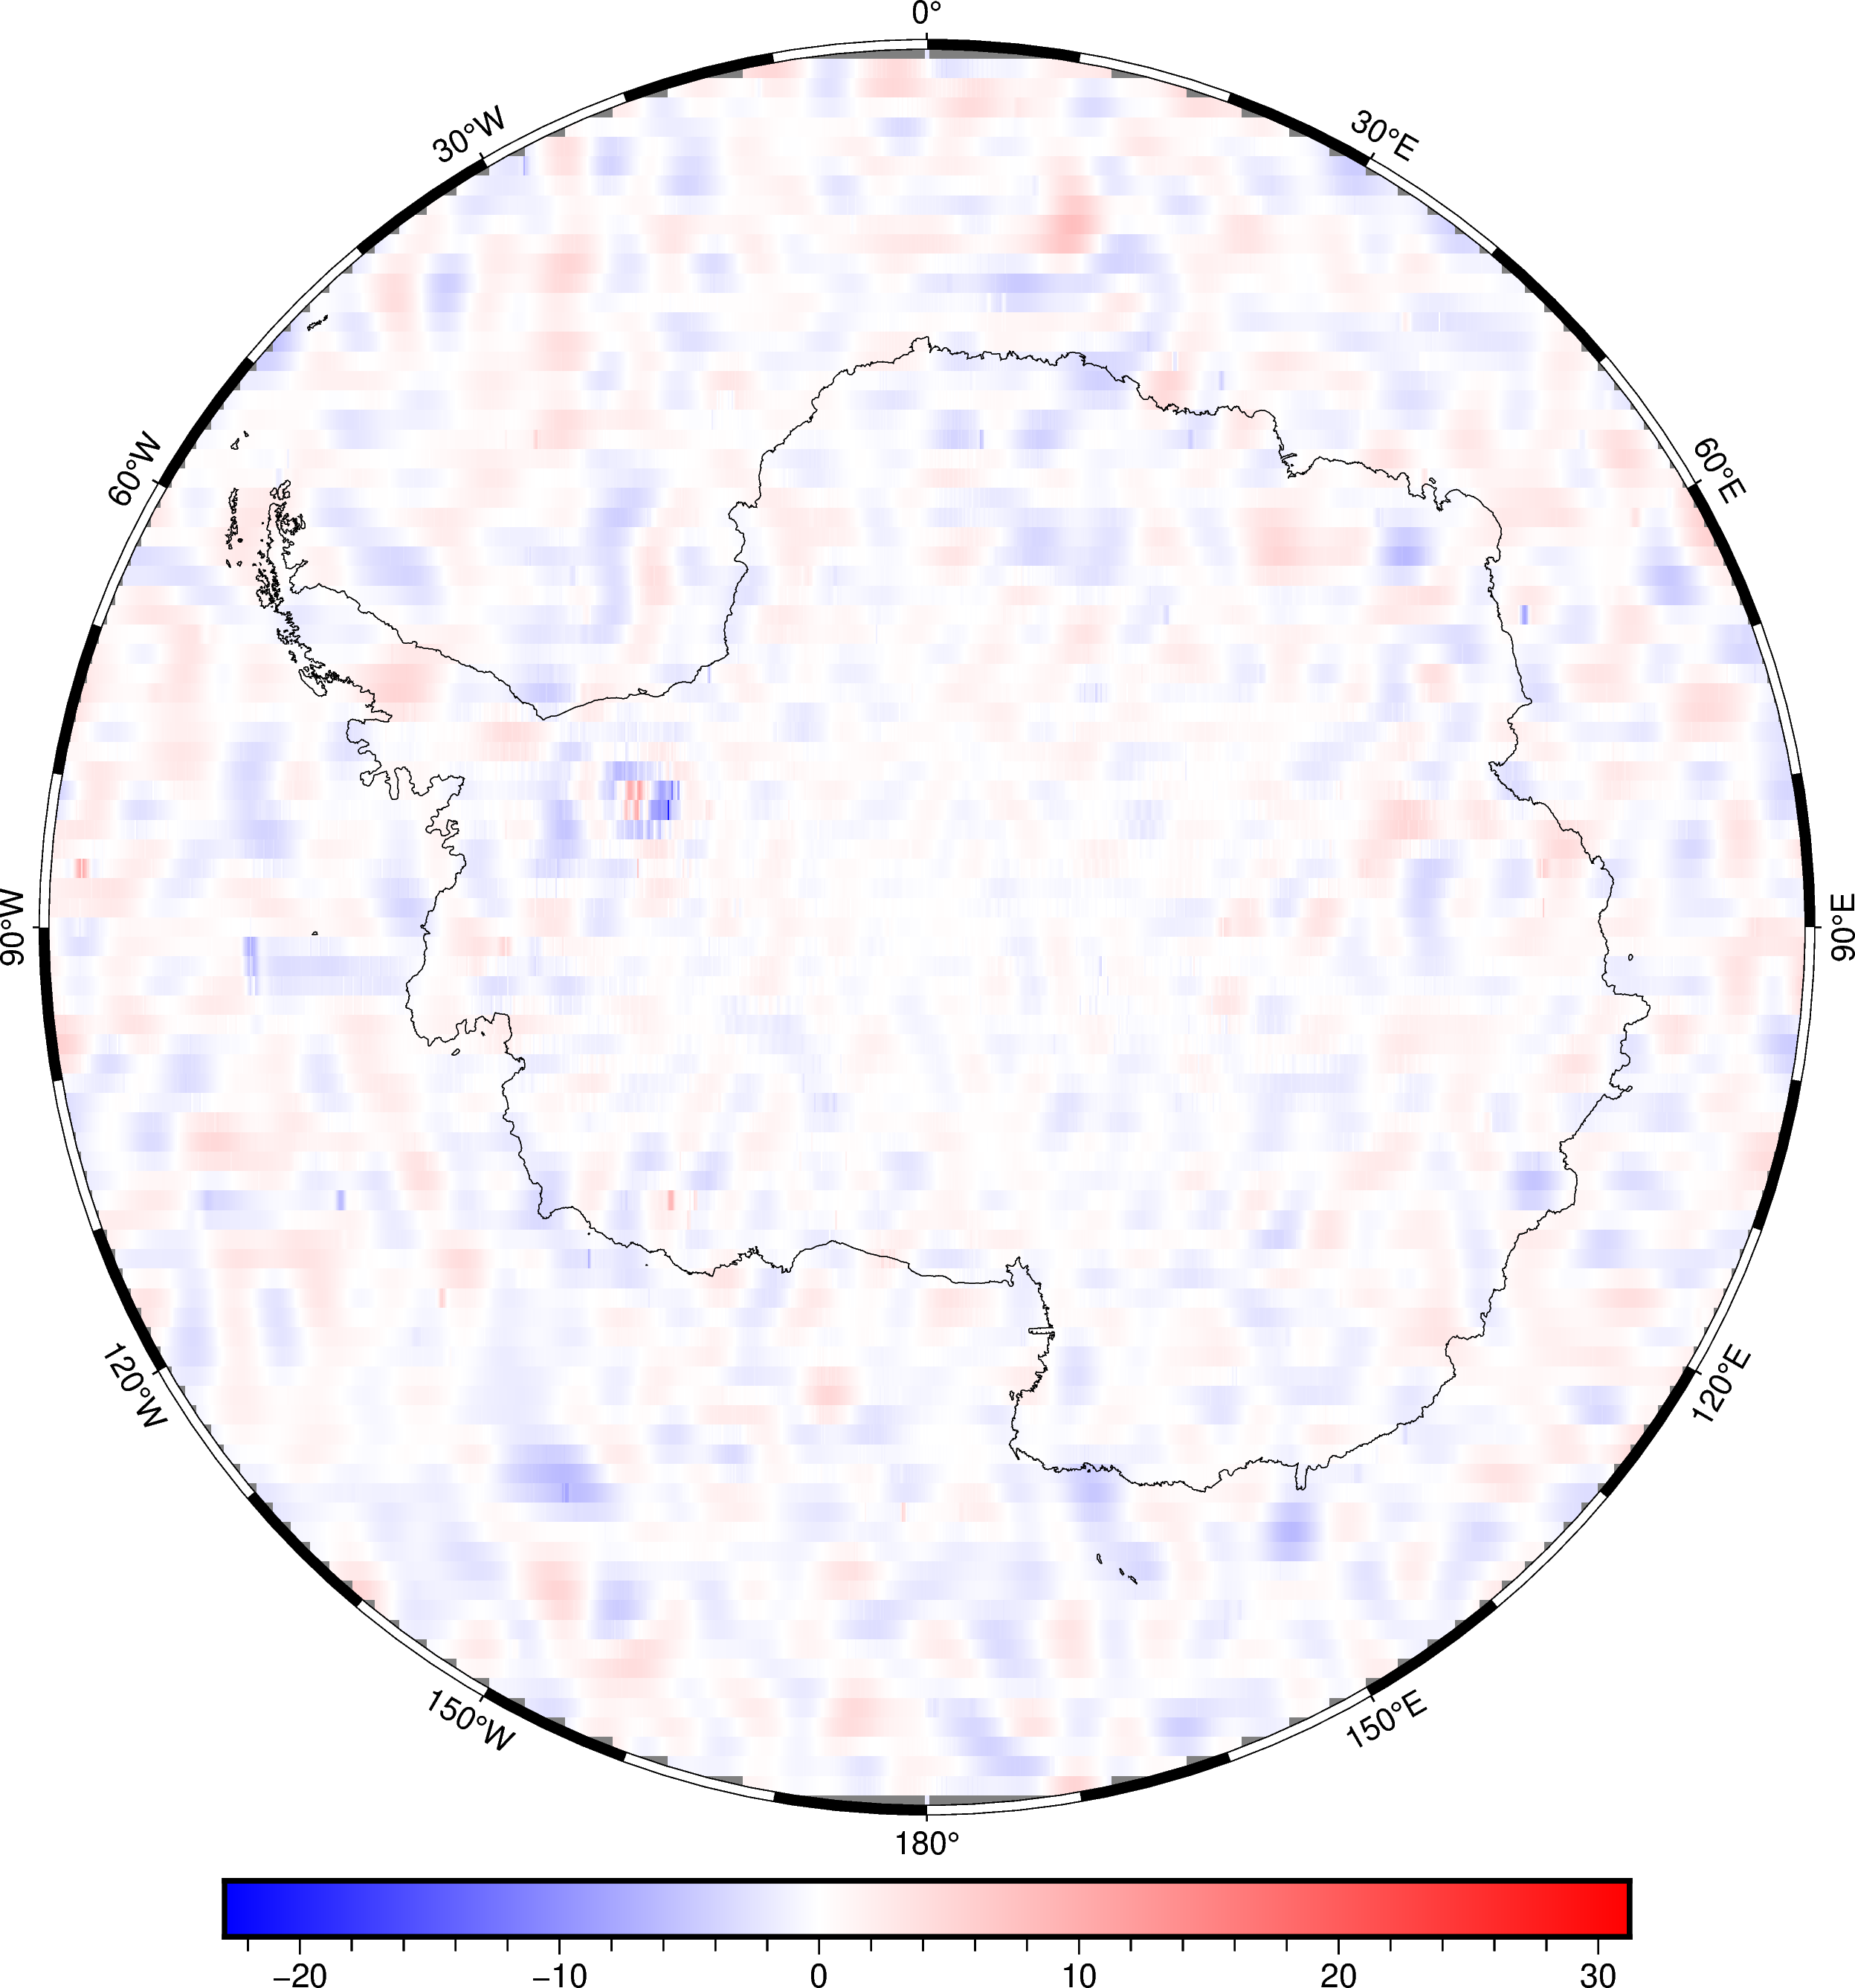

32 bits


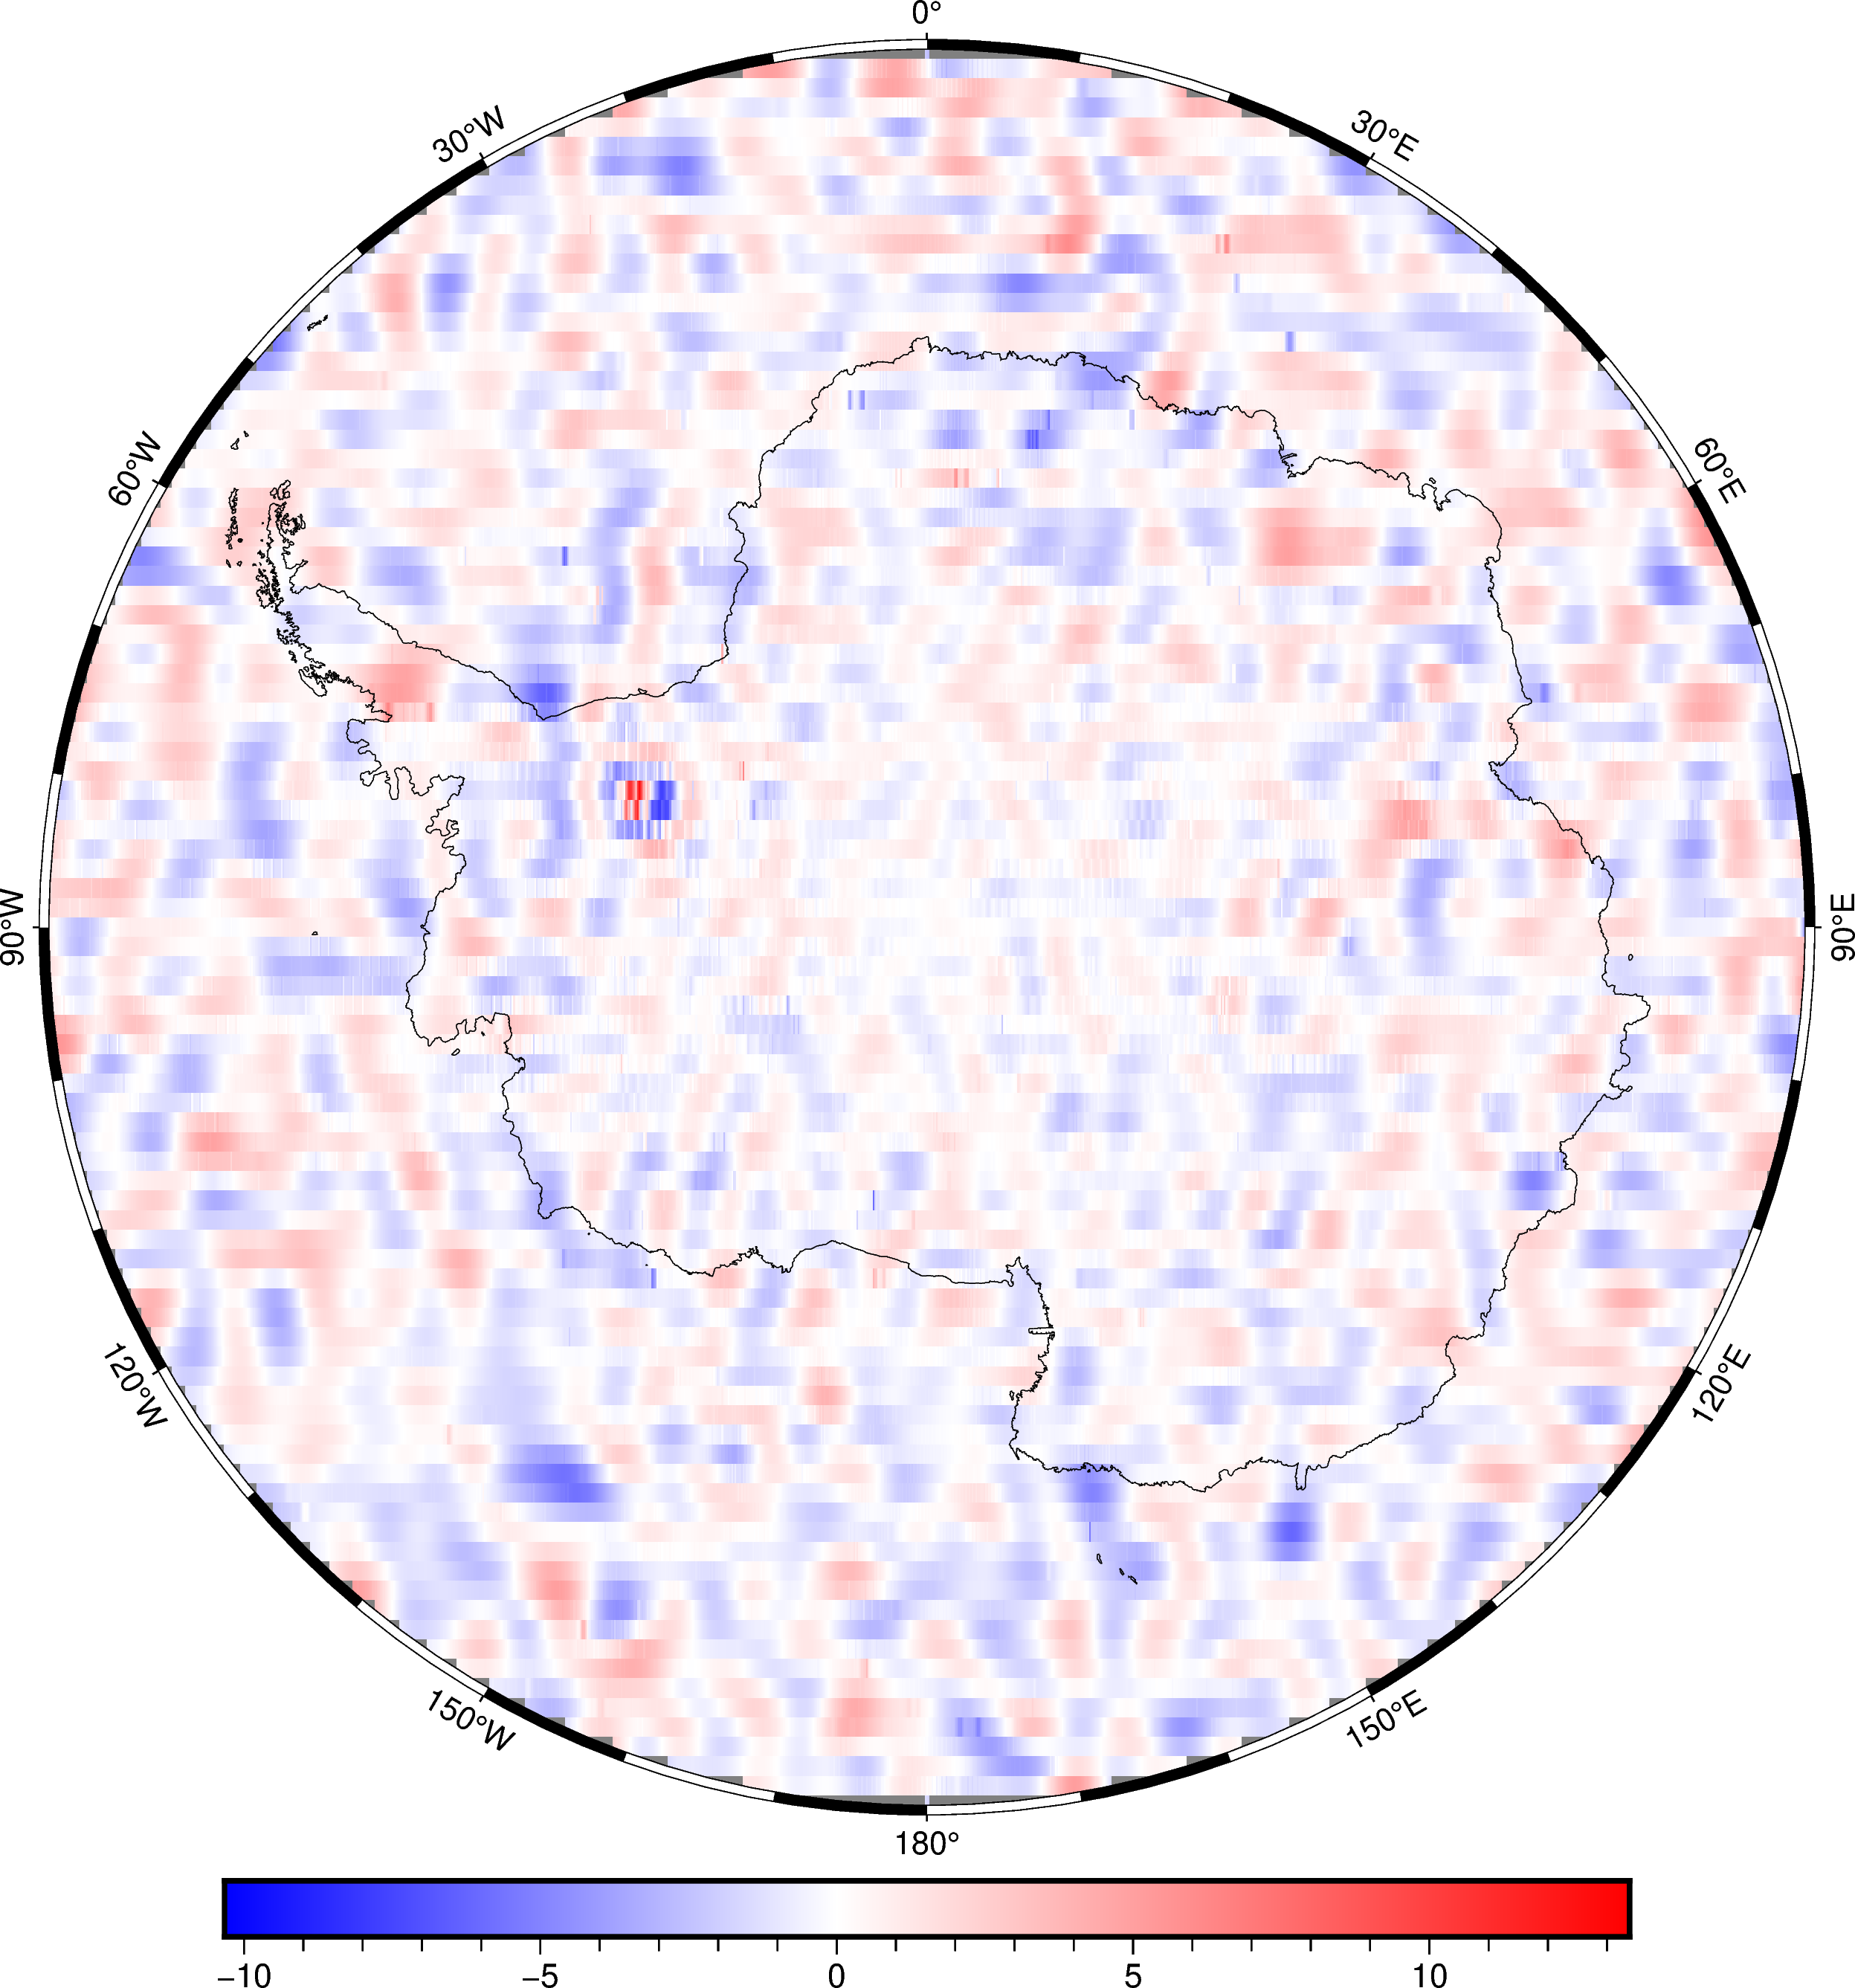

In [12]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_64, cmap="polar+h", frame=True , projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()


print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_32, cmap="polar+h", frame=True , projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Plot the windows.

64 bits


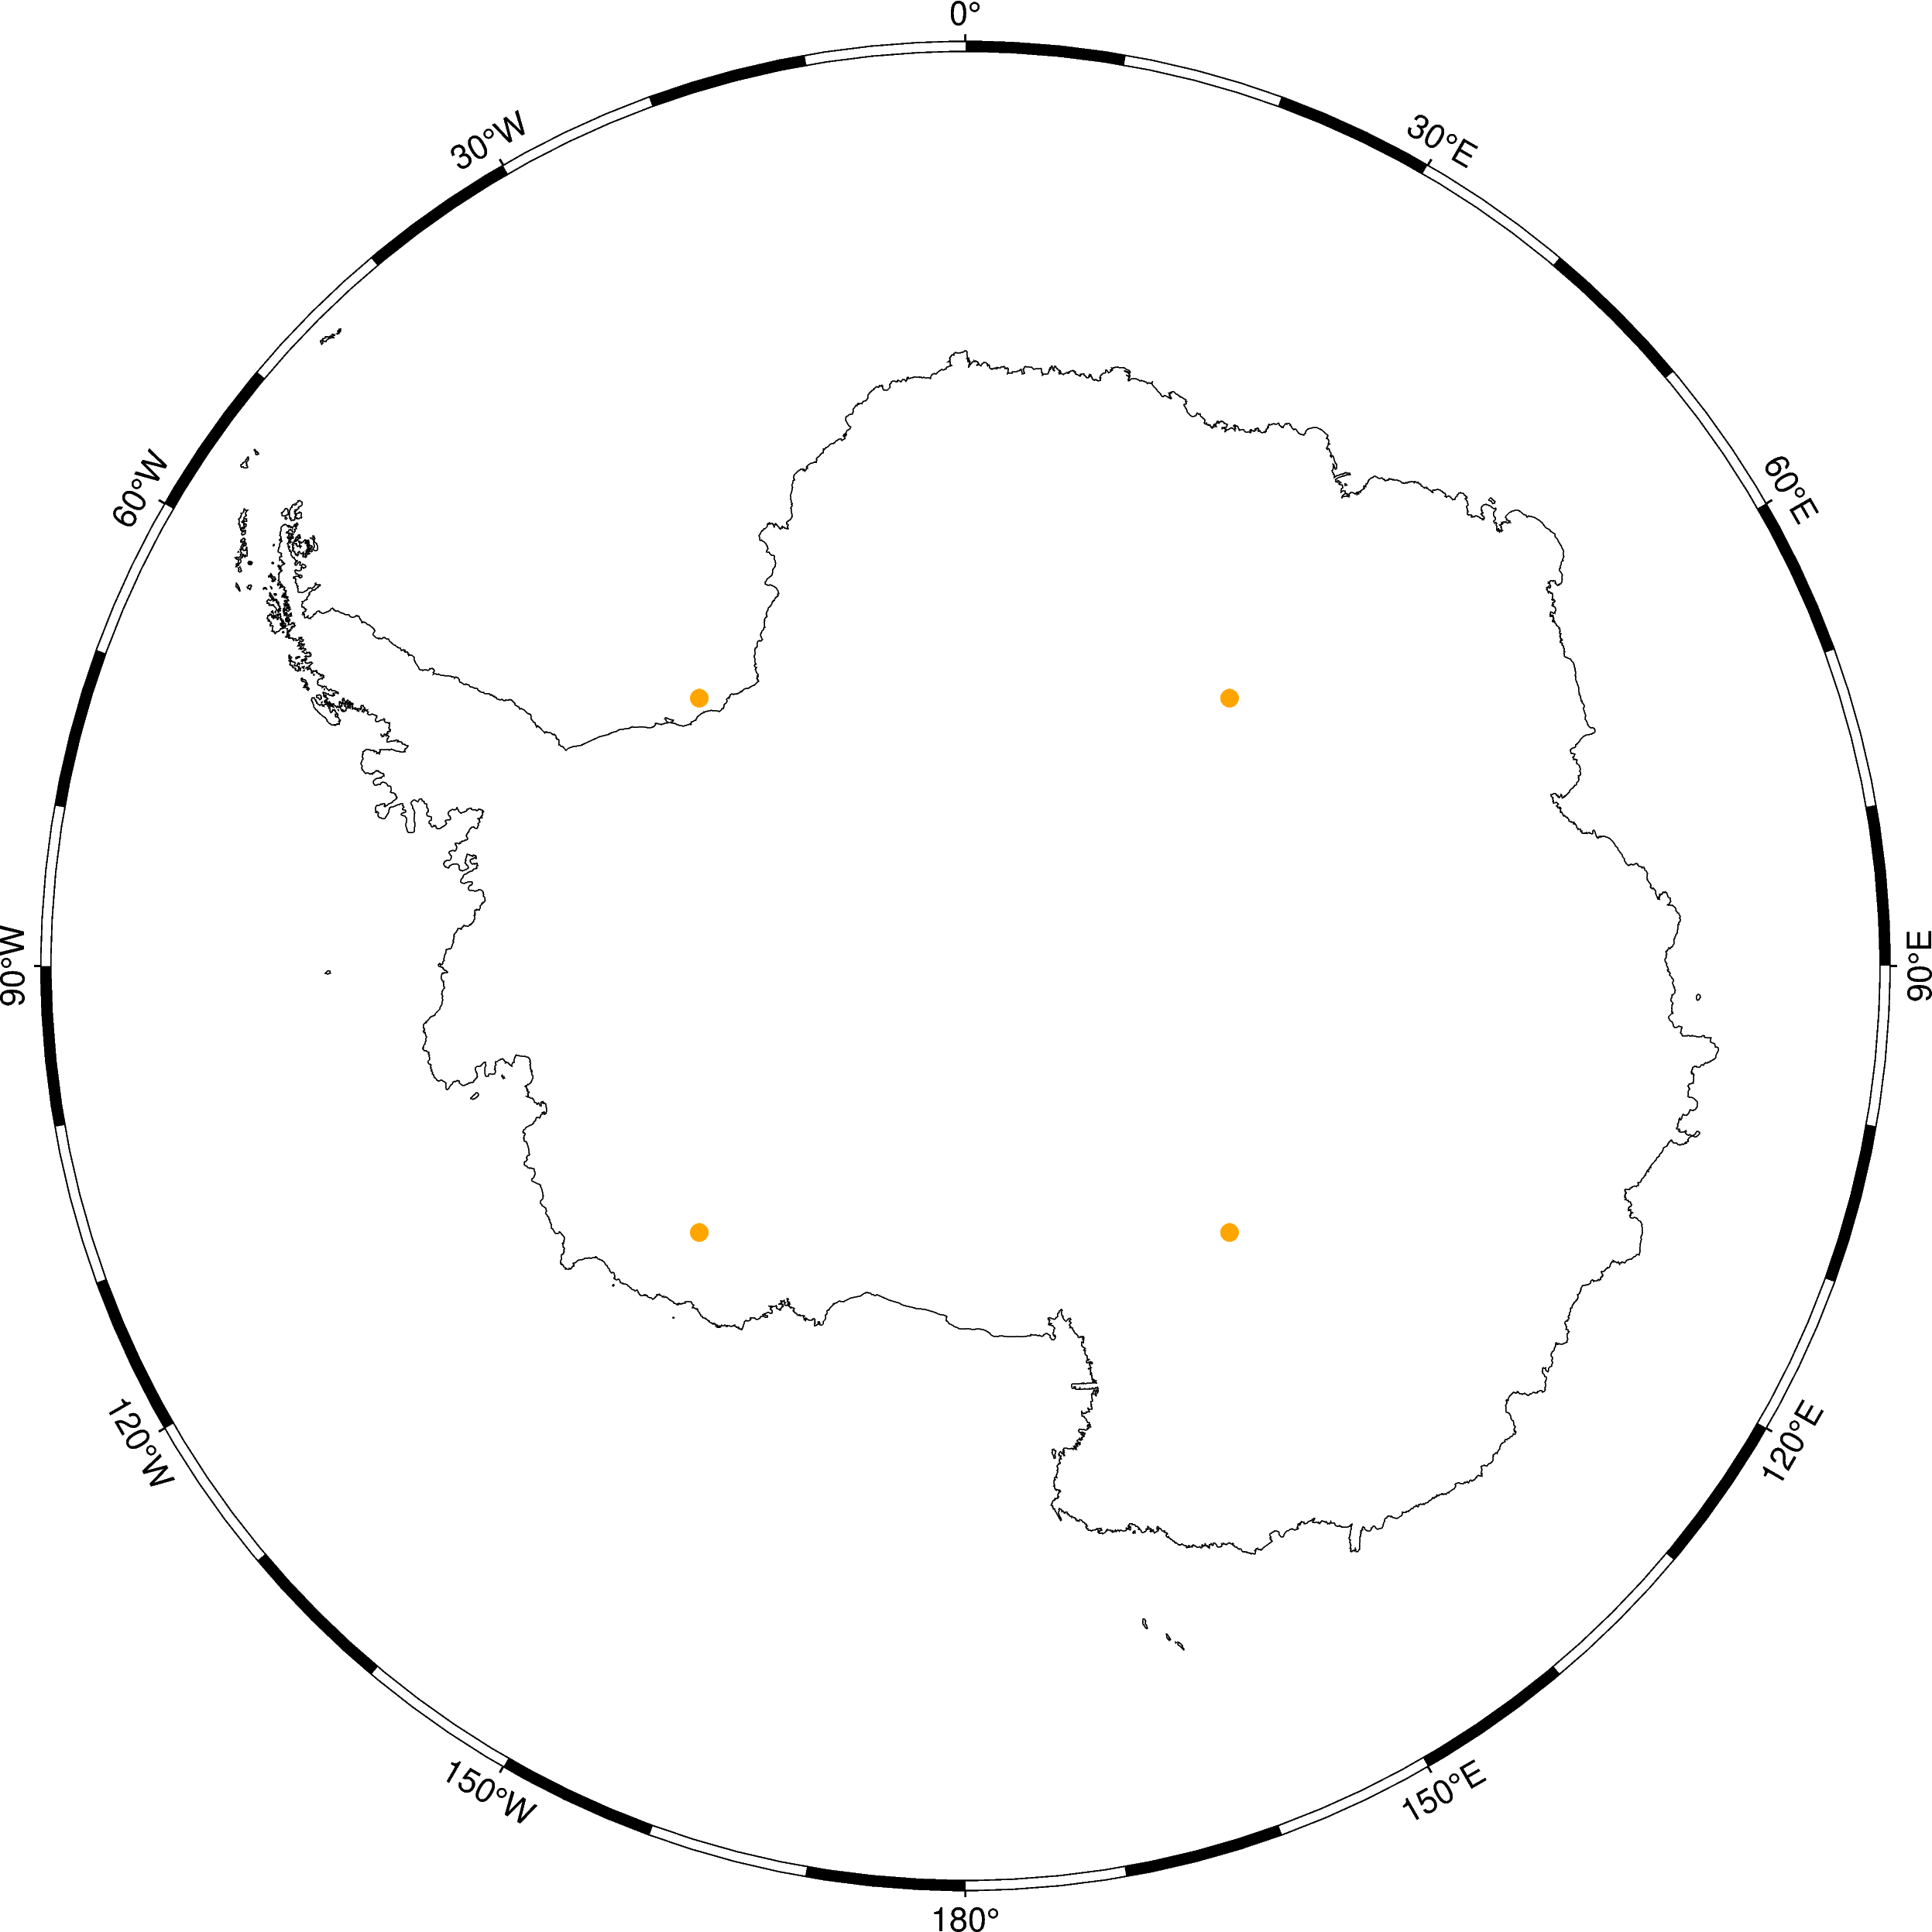

32 bits


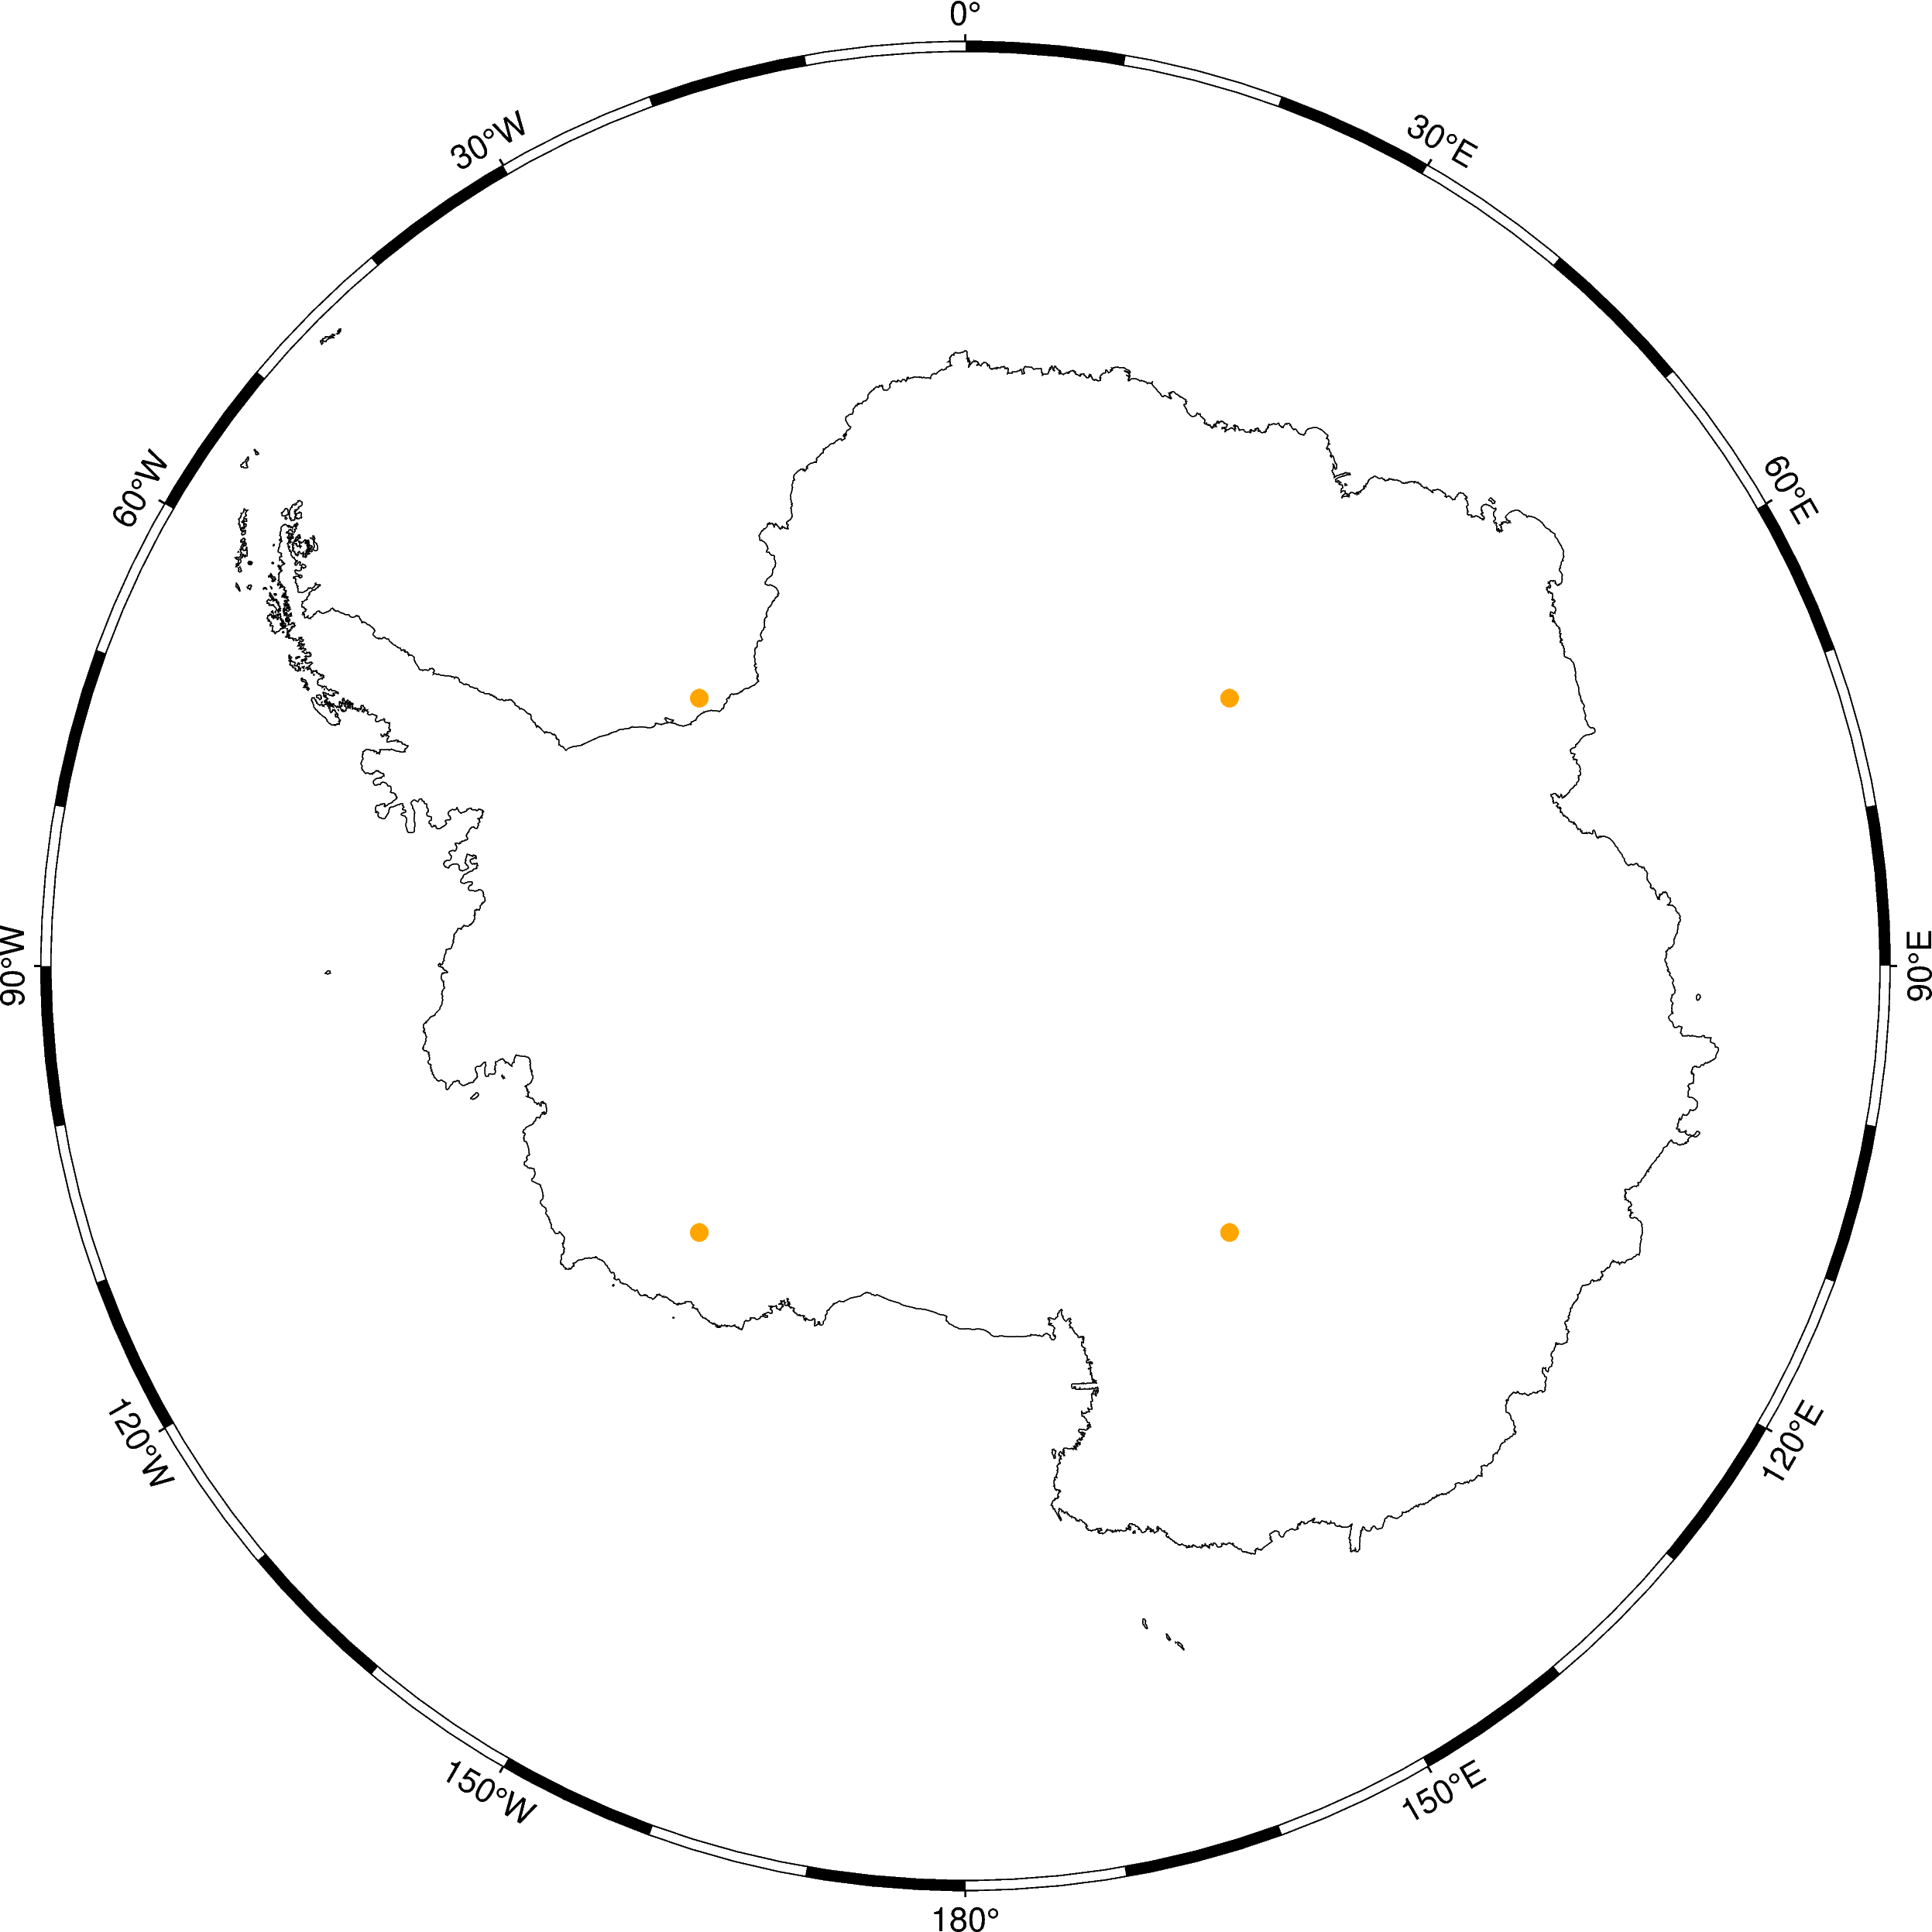

In [14]:
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()